In [3]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import csv
import datetime
import gsw
import glob
import matplotlib as mpl
import matplotlib.cm as cm
#import matplotlib.colormaps as cmaps
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1.inset_locator as inset_axes
import numpy as np
import os
import pandas as pd
import pickle
#import rasterio.plot
import scipy.io
#import seaborn as sns
import seawater
import seawater.eos80 as sw
import xarray as xr
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from shapely.geometry import LineString, MultiLineString, Point, Polygon
from shapely.ops import unary_union



mpl.style.use('seaborn-muted')
#mpl.rc('font', family ='Arial')

/tmp/ipykernel_451648/4225397793.py:35: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-muted')


In [ ]:
########################################################################################################
########################################################################################################
############################################# loading data #############################################
########################################################################################################
########################################################################################################

In [161]:
import glob

headers = []
csv_cast_lat_lon = {}
csv_ctd_data_dict = {}

# directory where the csv files are stored
csv_dir = r"/darnley/CDMeanState/Data/Final/Seal_CTD_and_Argo_type"

# can choose what files to exclude. s04i_97 has an error with oxygen readings below a certain depth, so can remove it this way
# exclude_file = "s04i_97_updated.csv"
exclude_file = "1987_bAU002712_wod_010114182O.nc_153_derivedvariables_ordered_type.csv"


for filename in glob.glob(os.path.join(csv_dir, "*.csv")):
    # can comment this line out if want all the files
    if os.path.basename(filename) != exclude_file:
        # read the csv file
        first = True
        try:
            csv_filehandle = open(filename)
            # print(filename)
            csvfile = csv.reader(csv_filehandle)
        except:
            # print("load fail")
            continue

        # get the file name without the directory path and file extension
        fn = os.path.splitext(os.path.basename(filename))[0]

        # initialize the data structure
        csv_ctd_data_dict[fn] = {}
        
        # Flag variable to check if 'time' column is found
        time_column_found = False
        
        # Flag to check if salinity < 20 is found
        low_salinity_found = False
        
        for row in csvfile:
            if first:
                header = row

                first = False
                for i in range(len(row)):
                    headers.append(row[i])
                    csv_ctd_data_dict[fn][row[i]] = []
                    
                    # Check if 'time' column exists in the header
                    if row[i] == 'time':
                        time_column_found = True

                # If 'time' column is not found, print the error and break
                if not time_column_found:
                    print(f"'time' column not found in file: {filename}")
                    break

            else:
                # Convert salinity to a float and check if it's less than 20
                salinity = float(row[2])  # Assuming salinity is at index 2
                if salinity < 20:
                    low_salinity_found = True
                    print(f"Low salinity found in file: {filename}")
                    break
                
                for i in range(len(row)):
                    csv_ctd_data_dict[fn][headers[i]].append(float(row[i]))

        csv_cast_lat_lon[fn] = {'lat': np.mean(csv_ctd_data_dict[fn]['latitude']), 'lon': np.mean(csv_ctd_data_dict[fn]['longitude'])}

# Print a message if no files with low salinity were found
if not low_salinity_found:
    print("No files with salinity < 20 were found.")

print(csv_cast_lat_lon)


No files with salinity < 20 were found.
{'2016_bAU005882_wod_017871129O.nc_325_derivedvariables_ordered_type': {'lat': -65.702, 'lon': 69.86799999999997}, '2010_bUS025289_wod_015285970O.nc_101_derivedvariables_ordered_type': {'lat': -65.981674, 'lon': 71.21315000000001}, '2017_bIN001232_wod_018153585O.nc_348_derivedvariables_ordered_type': {'lat': -65.965, 'lon': 64.149}, '2022_bAU006636_wod_021308761O.nc_684_derivedvariables_ordered_type': {'lat': -66.76154999999999, 'lon': 64.3392}, 'cnv_subset_PS128_033_01_DOWN_1m_updated_type': {'lat': -64.13699999999999, 'lon': 64.39866667000001}, '2001_bAU003608_wod_011280931O.nc_171_derivedvariables_ordered_type': {'lat': -66.33320000000002, 'lon': 64.0752}, '2022_bAU006485_wod_021968351O.nc_717_derivedvariables_ordered_type': {'lat': -65.51823000000002, 'lon': 67.99732}, '2011_bAU003979_wod_015205537O.nc_38_derivedvariables_ordered_type': {'lat': -65.86199999999997, 'lon': 69.22000000000003}, '2020_bIN001353_wod_020347777O.nc_539_derivedvariabl

In [162]:
#check it loaded all the files 
len(csv_cast_lat_lon)

1148

In [163]:
##run this code to order the dictionary by lat & lon
## i origingally did this when I had less casts and had a legend instead of a colour bar, so not really necessary, 
## but i use this dictionary in code later on so it does'nt hurt to do it or you will have to change the dictionary you call in plots below

csv_lon_ordered = sorted(csv_cast_lat_lon, key=lambda x: (csv_cast_lat_lon[x]['lon']))
csv_lat_ordered = sorted(csv_cast_lat_lon, key=lambda x: (csv_cast_lat_lon[x]['lat']))

In [164]:
#find the max depth (don't need this I was just curious)

max_depth = float('-inf')  # Initialize with negative infinity

# Iterate through top-level keys in the data dictionary
for dataset_key in csv_ctd_data_dict.keys():
    depth_values = csv_ctd_data_dict[dataset_key]['depth']
    max_depth_dataset = max(depth_values)
    
    # Update max_depth if the current dataset's max depth is greater
    if max_depth_dataset > max_depth:
        max_depth = max_depth_dataset

print("Maximum Depth:", max_depth)

Maximum Depth: 4184.780948


In [165]:
# Define the latitude range you want to plot
lat_min = -67
lat_max = -66.5

# Define the longitude range you want to plot
lon_min = 63
lon_max = 73

# Initialize empty lists for each variable
temperature_list = []
cons_temperature_list = []
salinity_list = []
abs_salinity_list = []
oxygen_list = []
latitude_list = []
longitude_list = []
pressure_list = []
depth_list = []
neutral_density_list = []
time_list = []
type_list = []


# Loop over the dictionary and extract the data for each variable
for cast in csv_ctd_data_dict.values():
    temperature_list.append(cast['temperature'])
    cons_temperature_list.append(cast['conservative temperature'])
    salinity_list.append(cast['salinity'])
    abs_salinity_list.append(cast['absolute salinity'])
    try:
        oxygen_list.append(cast['oxygen'])
    except KeyError:
        pass
    #oxygen_list.append(cast['oxygen'])
    latitude_list.append(cast['latitude'])
    longitude_list.append(cast['longitude'])
    pressure_list.append(cast['pressure'])
    depth_list.append(cast['depth'])
    neutral_density_list.append(cast['neutral density'])
    time_list.append(cast['time'])
    type_list.append(cast['type'])



# Convert the lists to NumPy arrays
temperature = np.concatenate(temperature_list)
cons_temperature = np.concatenate(cons_temperature_list)
salinity = np.concatenate(salinity_list)
abs_salinity = np.concatenate(abs_salinity_list)
oxygen = np.concatenate(oxygen_list)
latitude = np.concatenate(latitude_list)
longitude = np.concatenate(longitude_list)
pressure = np.concatenate(pressure_list)
depth = np.concatenate(depth_list)
neutral_density = np.concatenate(neutral_density_list)
time = np.concatenate(time_list)
type = np.concatenate(type_list)

In [166]:
#split data up into argo, seal & ship so can make them different markers in plots

seals_data = type == 1
ships_data = type == 2
argo_data = type == 3

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]

argo_latitude = latitude[argo_data]
argo_longitude = longitude[argo_data]
argo_cons_temperature = cons_temperature[argo_data]
argo_abs_salinity = abs_salinity[argo_data]
argo_depth = depth[argo_data]
argo_neutral_density = neutral_density[argo_data]
argo_time = time[argo_data]

In [14]:
### the argo data is a bit weird and has some NaNs so this code is to get rid of them

nan_indices = np.isnan(argo_abs_salinity)
print("Indices of NaN values in argo_cons_temperature:", np.where(nan_indices)[0])

Indices of NaN values in argo_cons_temperature: [   994   1000   1006 ... 691995 693966 694852]


In [16]:
# Create a mask to identify rows with NaN values in argo_cons_temperature
nan_mask = np.isnan(argo_cons_temperature)

print(nan_mask)

# Apply the mask to all argo data arrays

argo_latitude = argo_latitude[~nan_mask]
argo_longitude = argo_longitude[~nan_mask]
argo_cons_temperature = argo_cons_temperature[~nan_mask]
argo_abs_salinity = argo_abs_salinity[~nan_mask]
argo_depth = argo_depth[~nan_mask]
argo_neutral_density = argo_neutral_density[~nan_mask]
argo_time = argo_time[~nan_mask]

[False False False ... False False False]


In [24]:
nan_indices = np.isnan(argo_time)
print("Indices of NaN values in argo_cons_temperature:", np.where(nan_indices)[0])

Indices of NaN values in argo_cons_temperature: []


In [ ]:
########################################################################################################
########################################################################################################
######################################## load plotting components ######################################
########################################################################################################
########################################################################################################

In [4]:
# Calculate the potential density lines if needed 
sa = np.arange(33, 35, .1)
#comment out these 3 lines if you are using the neutral density contours made in matlab 
# y = np.arange(-2, 3, .2)
# X, Y = np.meshgrid(x, y)
# Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t

In [5]:
##plotting the freezing point line 
#calculate the freezing point of salt water at 1 atm pressure
#sa is the salinity range of this graph calculated using arange just above 
FP0=seawater.eos80.fp(sa, 0)

In [6]:
#this is the code for neutral density contours made in matlab using the TSgamfits code from laura HB
# Load the .mat file into Python using scipy.io.loadmat()
import scipy.io
data = scipy.io.loadmat('neu_dens_contours.mat')
# Extract the x and y variables from the data dictionary
x = data['x']
y = data['y']

In [7]:
#load colour maps
cmap_temp = cmocean.cm.thermal
cmap_salt = cmocean.cm.haline
cmap_dens = cmocean.cm.dense
cmap_deep = cmocean.cm.deep
cmap_ice = cmocean.cm.ice

# #old way of getting these that got updated
#cmap_temp = plt.cm.get_cmap('cmo.thermal')
# cmap_salt = plt.cm.get_cmap('cmo.haline')
# cmap_dens = plt.cm.get_cmap('cmo.dense')
# cmap_deep = plt.cm.get_cmap('cmo.deep')


In [8]:
# Load the neutral density contours
# these contours were calculated in the 'neu_dens_contours_calculation.ipynb' file
with open('neu_dens_contours.pkl', 'rb') as file:
    data = pickle.load(file)

# Access the variables
x_curve1 = data['x_curve1']
y_curve1 = data['y_curve1']
x_curve2 = data['x_curve2']
y_curve2 = data['y_curve2']

In [ ]:
########################################################################################################
########################################################################################################
############################################ simple TS plot ############################################
########################################################################################################
########################################################################################################

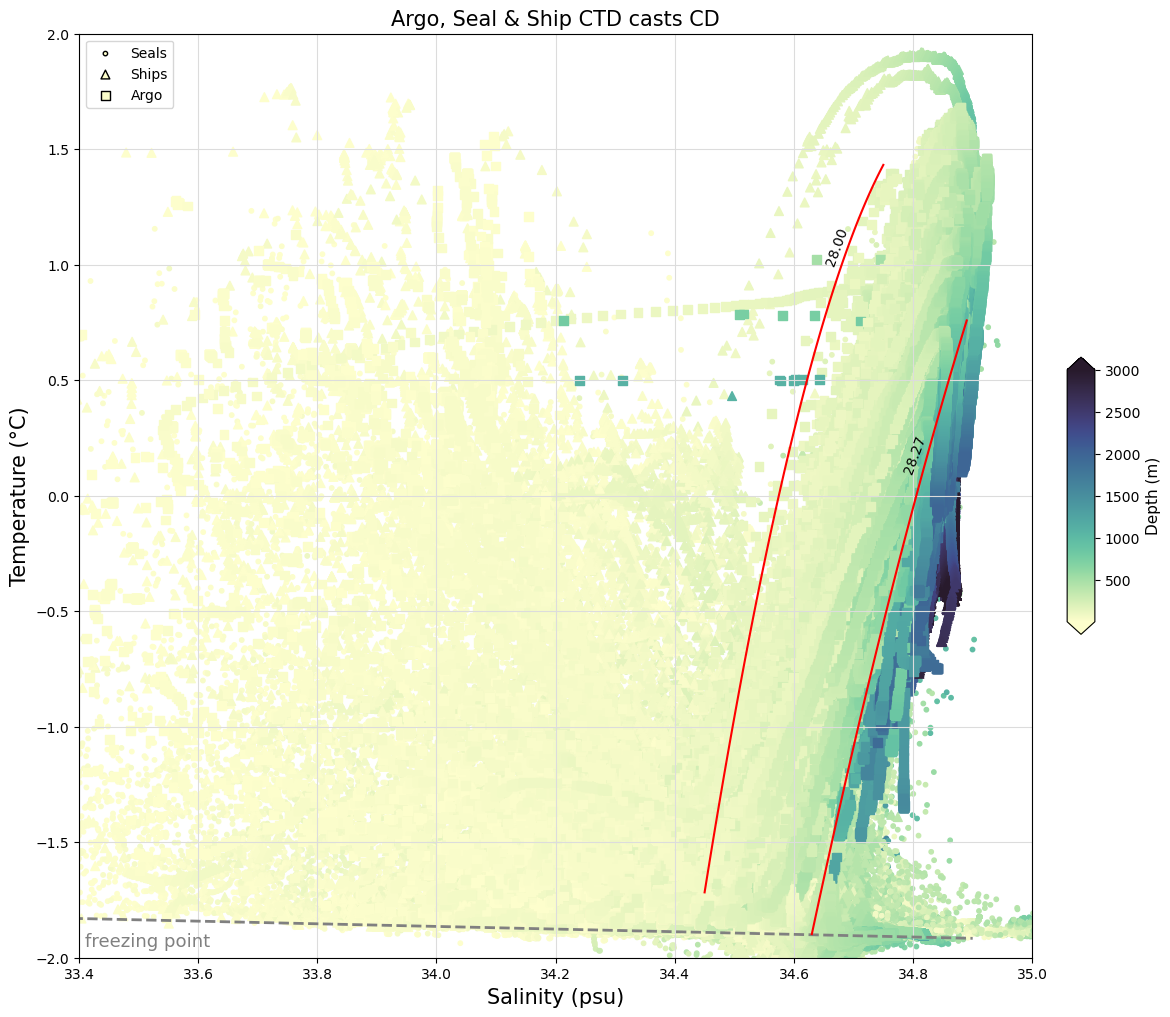

In [16]:
##TS plot

#set the size of the figure
plt.figure(figsize=(15, 12)) 


# Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter = plt.scatter(seals_abs_salinity, seals_cons_temperature,
                           s=10, c=seals_depth, cmap=cmap_deep, vmax = 3000, marker='o', label='Seals')

ships_scatter = plt.scatter(ships_abs_salinity, ships_cons_temperature,
                           s=40, c=ships_depth, cmap=cmap_deep, vmax = 3000, marker='^', label='Ships')

argo_scatter = plt.scatter(argo_abs_salinity, argo_cons_temperature,
                           s=40, c=argo_depth, cmap=cmap_deep, vmax=3000, marker='s', label='Argo')



#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.78,0.1,'28.27', rotation=70, fontsize=10)
plt.text(34.65,1,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.95,'freezing point', fontsize=13, color = 'gray')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Salinity (psu)',  fontsize=15)
plt.ylabel('Temperature (°C)',  fontsize=15)
plt.title('Argo, Seal & Ship CTD casts CD',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
cbar = plt.colorbar(seals_scatter, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar.set_label('Depth (m)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')




# DENSITY LINES 

# Plot the potential density contour lines
## comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')

# This plots the old neu dens lines calculated from  matlab 
# plt.plot(x, y, 'k', linewidth = '2.5')

# Neutral density lines custom to my data set from 'neu_dens_contours_calculation.ipynb'
plt.plot(x_curve1, y_curve1, color='red')
plt.plot(x_curve2, y_curve2, color='red')




plt.show()

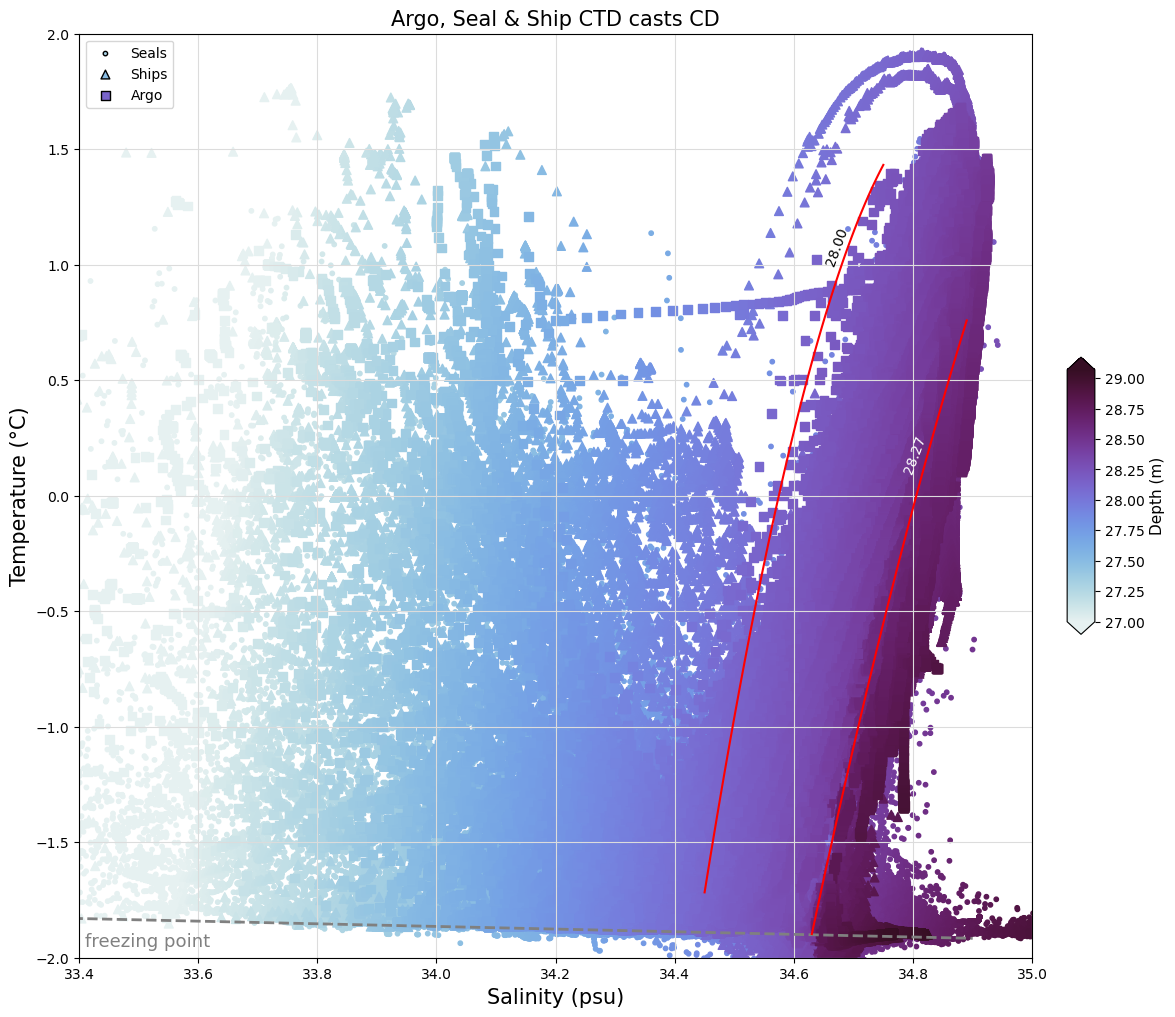

In [18]:
##TS plot

#set the size of the figure
plt.figure(figsize=(15, 12)) 


# Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter = plt.scatter(seals_abs_salinity, seals_cons_temperature,
                           s=10, c=seals_neutral_density, cmap=cmap_dens, vmin = 27, marker='o', label='Seals')

ships_scatter = plt.scatter(ships_abs_salinity, ships_cons_temperature,
                           s=40, c=ships_neutral_density, cmap=cmap_dens, vmin = 27, marker='^', label='Ships')

argo_scatter = plt.scatter(argo_abs_salinity, argo_cons_temperature,
                           s=40, c=argo_neutral_density, cmap=cmap_dens, vmin = 27, marker='s', label='Argo')



#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.78,0.1,'28.27', rotation=70, fontsize=10, color = 'white')
plt.text(34.65,1,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.95,'freezing point', fontsize=13, color = 'gray')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Salinity (psu)',  fontsize=15)
plt.ylabel('Temperature (°C)',  fontsize=15)
plt.title('Argo, Seal & Ship CTD casts CD',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
cbar = plt.colorbar(seals_scatter, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar.set_label('Depth (m)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')




# DENSITY LINES 

# Plot the potential density contour lines
## comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')

# This plots the old neu dens lines calculated from  matlab 
# plt.plot(x, y, 'k', linewidth = '2.5')

# Neutral density lines custom to my data set from 'neu_dens_contours_calculation.ipynb'
plt.plot(x_curve1, y_curve1, color='red')
plt.plot(x_curve2, y_curve2, color='red')




plt.show()

/tmp/ipykernel_345744/931639064.py:58: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')


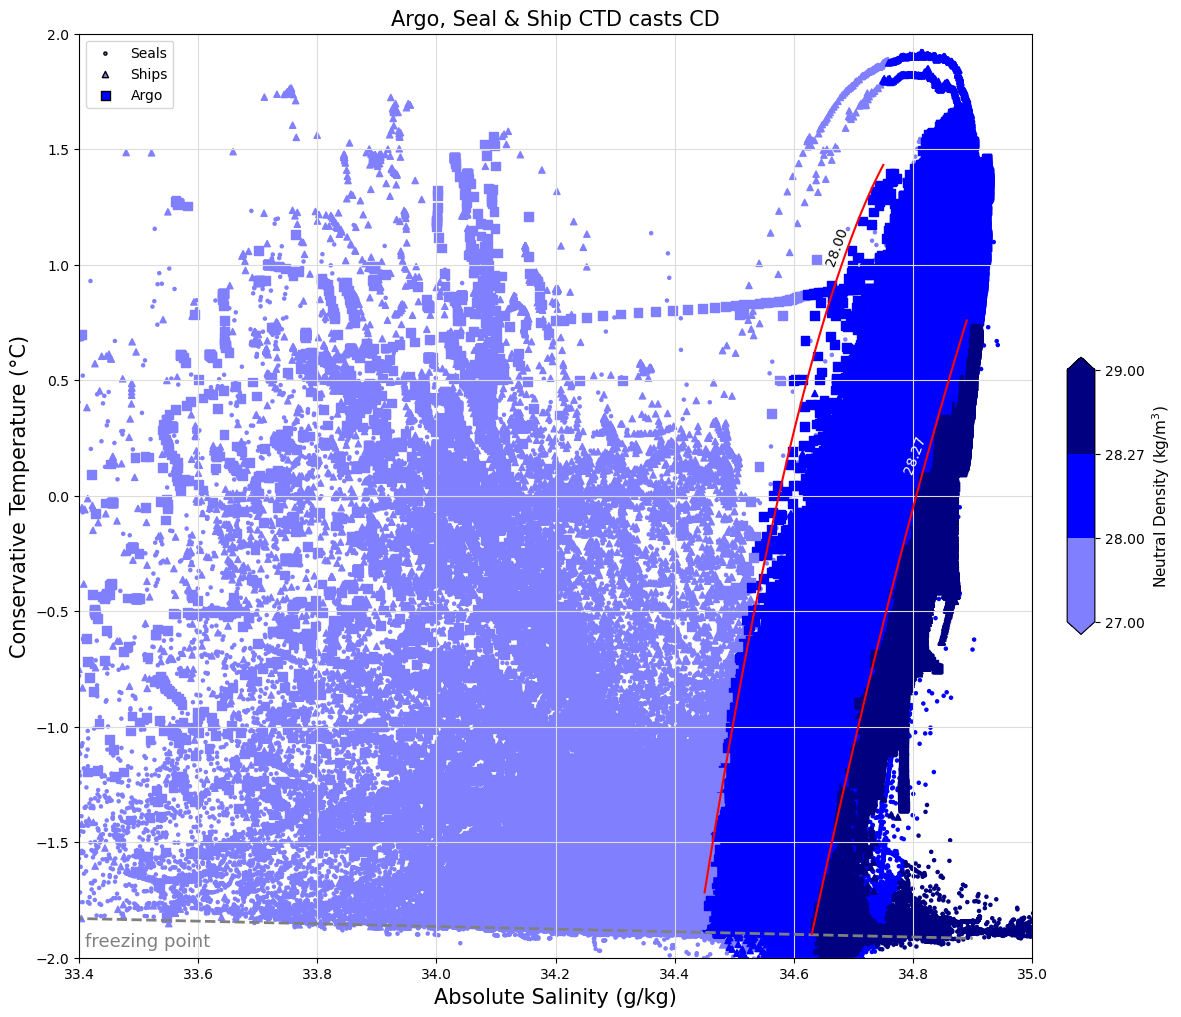

In [20]:
#set the size of the figure
plt.figure(figsize=(15, 12)) 


# Define custom color boundaries
vmin = 27
vmax1 = 28
vmax2 = 28.27
vmax3 = 29


# Define colors for different ranges
#colors = [(0.7, 0.7, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
colors = [(0.5, 0.5, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
#colors = [(0.7, 0.7, 0.7), (0, 0, 1), (0.3, 0.3, 0.3)]  # Light blue, blue, dark blue
#cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
cmap_custom = mcolors.ListedColormap(colors)

# Normalize the colormap
norm = mcolors.BoundaryNorm([vmin, vmax1, vmax2, vmax3], cmap_custom.N)


# Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter = plt.scatter(seals_abs_salinity, seals_cons_temperature,
                           s=5, c=seals_neutral_density, cmap=cmap_custom, vmin = 27.5, marker='o', label='Seals')

ships_scatter = plt.scatter(ships_abs_salinity, ships_cons_temperature,
                           s=20, c=ships_neutral_density, cmap=cmap_custom, vmin = 27.5, marker='^', label='Ships')

argo_scatter = plt.scatter(argo_abs_salinity, argo_cons_temperature, 
                           s=40, c=argo_neutral_density, cmap=cmap_custom, vmin=27.5, marker='s', label='Argo')



#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.78,0.1,'28.27', rotation=70, fontsize=10, color = 'white')
plt.text(34.65,1,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.95,'freezing point', fontsize=13, color = 'gray')



#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Absolute Salinity (g/kg)',  fontsize=15)
plt.ylabel('Conservative Temperature (°C)',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
#cbar = plt.colorbar(seals_scatter, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_custom),orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')



# DENSITY LINES 

# Plot the potential density contour lines
## comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')

# This plots the old neu dens lines calculated from  matlab 
# plt.plot(x, y, 'k', linewidth = '2.5')

# Neutral density lines custom to my data set from 'neu_dens_contours_calculation.ipynb'
plt.plot(x_curve1, y_curve1, color='red')
plt.plot(x_curve2, y_curve2, color='red')


# Add a dynamic title
plt.title(f'Argo, Seal & Ship CTD casts CD', fontsize=15)

plt.show()

In [ ]:
########################################################################################################
########################################################################################################
############################################ visualise data ############################################
########################################################################################################
########################################################################################################

In [9]:
#load bathymetry data

# Open the NetCDF file with xarray
gebco_full = xr.open_dataset('../Data/Final/bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')


<Figure size 640x480 with 0 Axes>

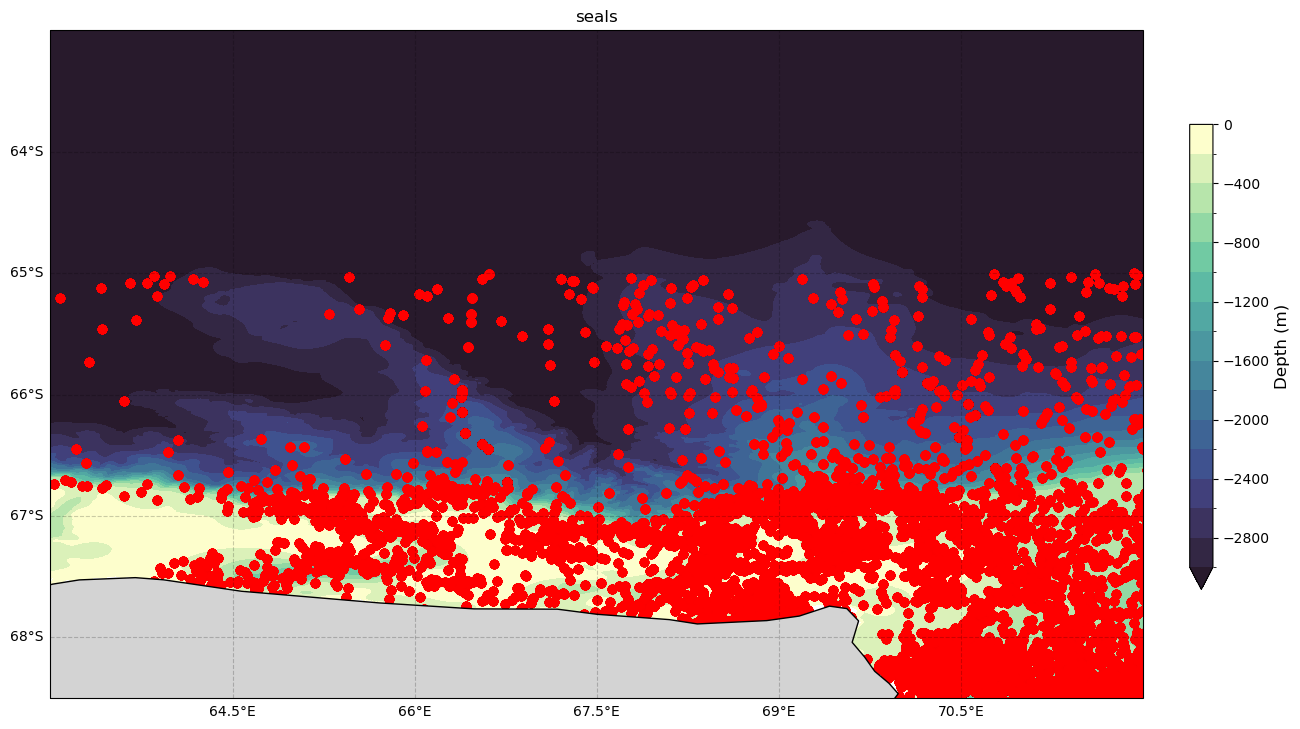

In [13]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot the contour polygon
ax.scatter(seals_longitude, seals_latitude, color='red')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.title('seals')

plt.show()

<Figure size 640x480 with 0 Axes>

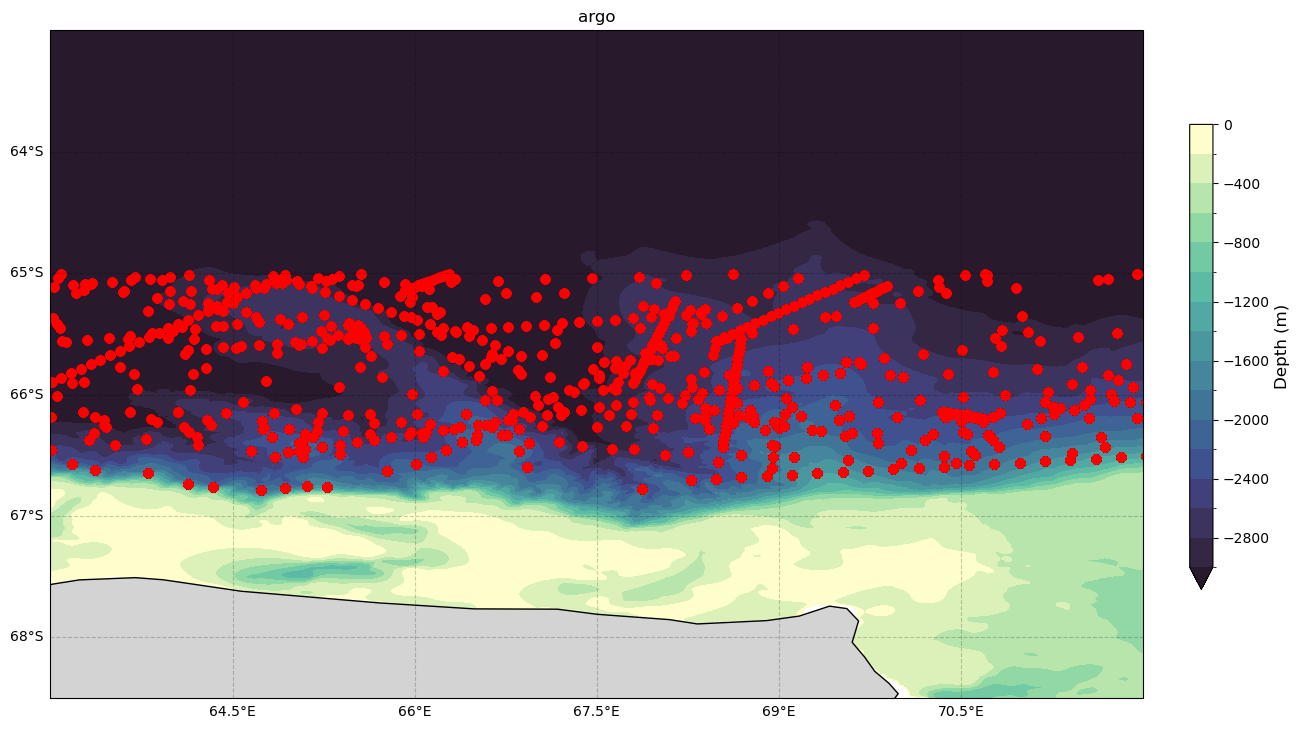

In [47]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot the contour polygon
ax.scatter(argo_longitude, argo_latitude, color='red')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.title('argo')

plt.show()

<Figure size 640x480 with 0 Axes>

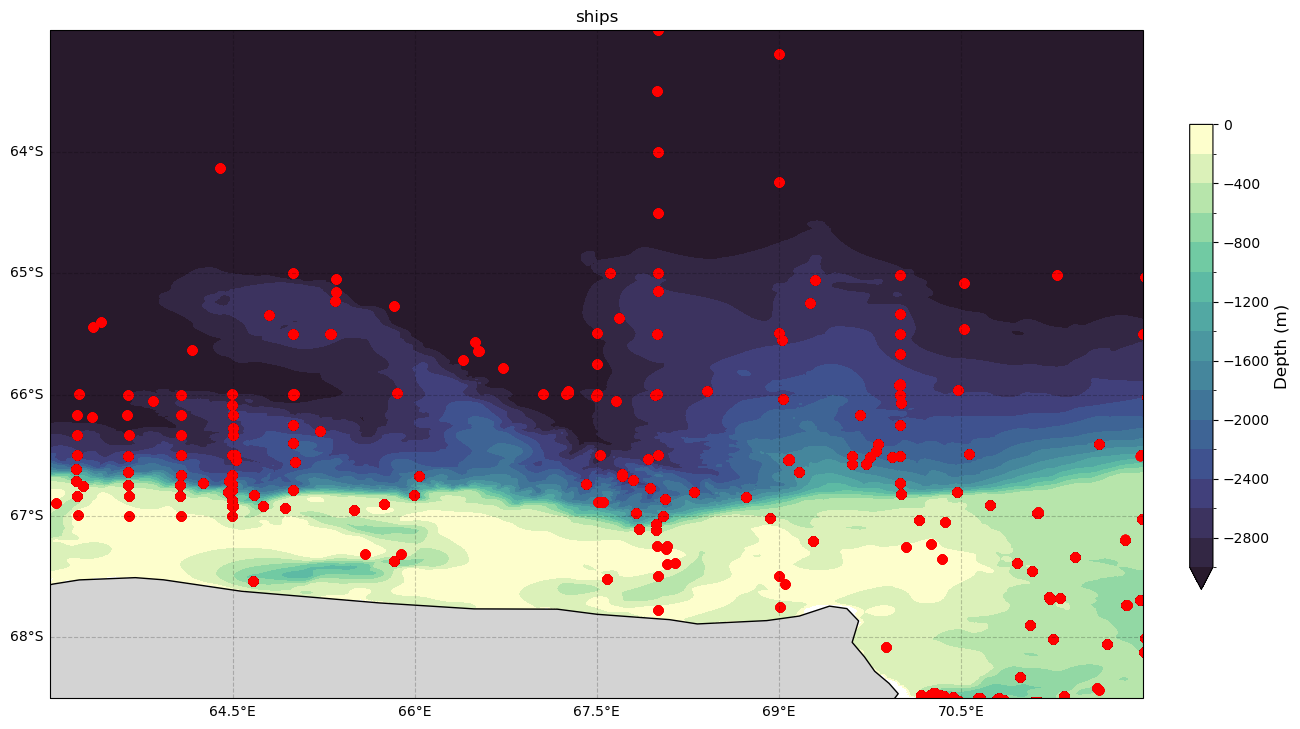

In [16]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot the contour polygon
ax.scatter(ships_longitude, ships_latitude, color='red')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.title('ships')

plt.show()

In [ ]:
########################################################################################################
########################################################################################################
####################################### create shelf contour mask ######################################
########################################################################################################
########################################################################################################

In [10]:
#load in the 600m contour 
# this was calculated in the notebook 'calculating_depth_contours.ipynb'
shelf_contour = np.load('contour_coordinates_shelf_600m.npy')

In [11]:
# Load in the shelf polygon coordinates from the CSV
polygon_shelf_coords = pd.read_csv('polygon_shelf.csv')

# Create a Shapely Polygon from the coordinates
polygon_shelf = Polygon(zip(polygon_shelf_coords['X'], polygon_shelf_coords['Y']))

# Extract X and Y coordinates
x = polygon_shelf_coords['X'].tolist()
y = polygon_shelf_coords['Y'].tolist()

<Figure size 640x480 with 0 Axes>

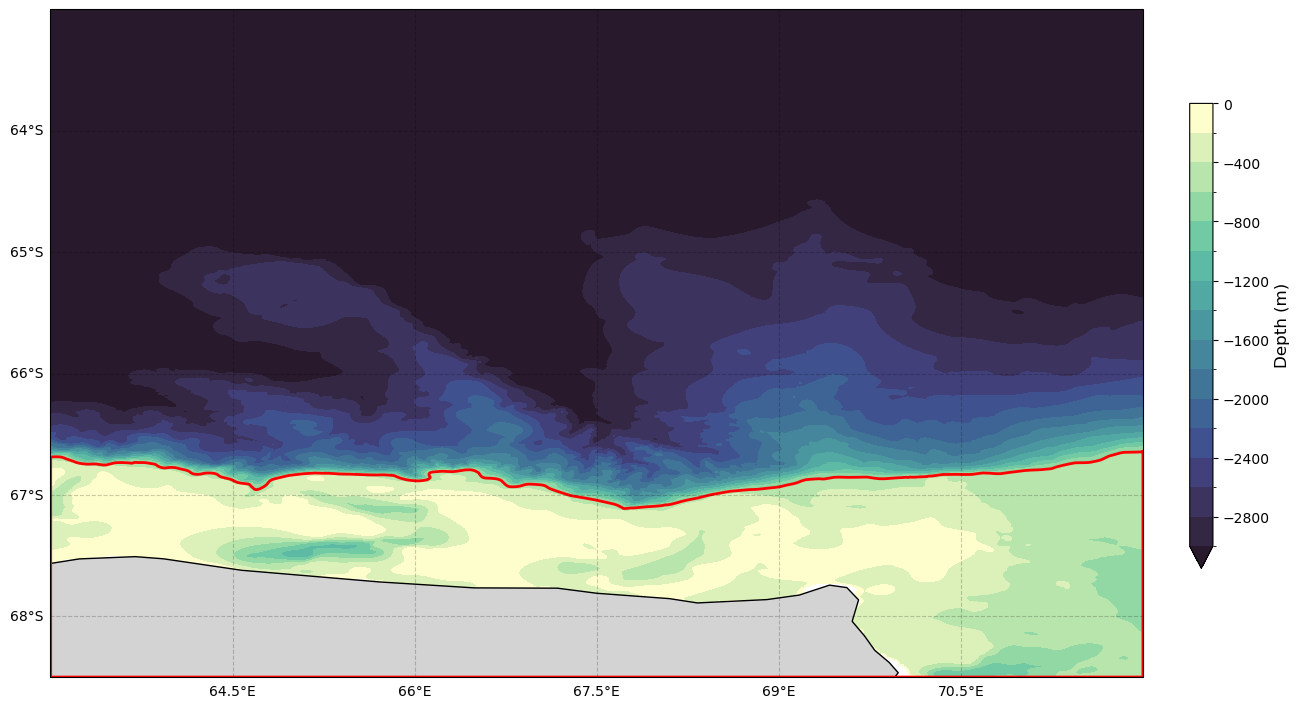

In [10]:
#This plots the polygon on the map to check it works

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Add a contour line for the 600m isobath
##contour_line_coordinates comes from 'CTD mapping seals and CTD with type' notebook. 
#ax.plot(contour_line_coordinates[:, 0], contour_line_coordinates[:, 1], color='white', linewidth=3)

# # Plot the result using Matplotlib
# x, y = polygon.exterior.xy

# Plot the contour polygon
ax.plot(x, y, color='red', linewidth=2)

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.show()

In [175]:
#define east, central & west boundaries. These values come from looking at the data on a spatial view
#and by eye finding natural areas of division 

#note, make sure to comment out the argo in range calculations in the code below. There r no argo measurements on the shelf and the code can't deal with that

# #west
# lon_min = 63
# lon_max = 66.5

# #central
# lon_min = 66.5
# lon_max = 70

# #east
lon_min = 70
lon_max = 72



In [230]:
#this crops the data with the shelf polygon and finds data inside, and outside of this polygon
#Choose if you want east, central or west by changing the cell above

In [176]:
################################ SEALS ################################
# Initialize lists to store indices for data within and outside the polygon
seals_indices_in_range = []
seals_indices_out_range = []

# Loop through your data points (assuming latitude and longitude are numpy arrays)
for i in range(len(seals_latitude)):
    latitude = seals_latitude[i]
    longitude = seals_longitude[i]
    point = Point(longitude, latitude)
    
    # # Check if the point is within the polygon (use this if you just want on shelf, slope & offshore)
    # if polygon_shelf.contains(point):
    #     seals_indices_in_range.append(i)
    # else:
    #     seals_indices_out_range.append(i)
    
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_shelf.contains(point) and lon_min <= longitude <= lon_max:
        seals_indices_in_range.append(i)
    else:
        seals_indices_out_range.append(i)

# Convert the index lists to NumPy arrays for indexing
seals_indices_in_range = np.array(seals_indices_in_range)
seals_indices_out_range = np.array(seals_indices_out_range)

# Crop the data based on the indices
seals_cons_temperature_in_range = seals_cons_temperature[seals_indices_in_range]
seals_abs_salinity_in_range = seals_abs_salinity[seals_indices_in_range]
seals_depth_in_range = seals_depth[seals_indices_in_range]
seals_neutral_density_in_range = seals_neutral_density[seals_indices_in_range]
seals_time_in_range = seals_time[seals_indices_in_range]
seals_lat_in_range = seals_latitude[seals_indices_in_range]
seals_lon_in_range = seals_longitude[seals_indices_in_range]

seals_cons_temperature_out_range = seals_cons_temperature[seals_indices_out_range]
seals_abs_salinity_out_range = seals_abs_salinity[seals_indices_out_range]
seals_depth_out_range = seals_depth[seals_indices_out_range]
seals_neutral_density_out_range = seals_neutral_density[seals_indices_out_range]
seals_time_out_range = seals_time[seals_indices_out_range]
seals_lat_out_range = seals_latitude[seals_indices_out_range]
seals_lon_out_range = seals_longitude[seals_indices_out_range]


In [177]:
################################ SHIPS ################################

# Initialize lists to store indices for data within and outside the polygon
ships_indices_in_range = []
ships_indices_out_range = []

for i in range(len(ships_latitude)):
    latitude = ships_latitude[i]
    longitude = ships_longitude[i]
    point = Point(longitude, latitude)
    
    # # Check if the point is within the polygon (use this if you just want on shelf, slope & offshore)
    # if polygon_shelf.contains(point):
    #     ships_indices_in_range.append(i)
    # else:
    #     ships_indices_out_range.append(i)
    
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_shelf.contains(point) and lon_min <= longitude <= lon_max:
        ships_indices_in_range.append(i)
    else:
        ships_indices_out_range.append(i)

# Convert the index lists to NumPy arrays for indexing
ships_indices_in_range = np.array(ships_indices_in_range)
ships_indices_out_range = np.array(ships_indices_out_range)

# Crop the data based on the indices
ships_cons_temperature_in_range = ships_cons_temperature[ships_indices_in_range]
ships_abs_salinity_in_range = ships_abs_salinity[ships_indices_in_range]
ships_depth_in_range = ships_depth[ships_indices_in_range]
ships_neutral_density_in_range = ships_neutral_density[ships_indices_in_range]
ships_time_in_range = ships_time[ships_indices_in_range]
ships_lat_in_range = ships_latitude[ships_indices_in_range]
ships_lon_in_range = ships_longitude[ships_indices_in_range]

ships_cons_temperature_out_range = ships_cons_temperature[ships_indices_out_range]
ships_abs_salinity_out_range = ships_abs_salinity[ships_indices_out_range]
ships_depth_out_range = ships_depth[ships_indices_out_range]
ships_neutral_density_out_range = ships_neutral_density[ships_indices_out_range]
ships_time_out_range = ships_time[ships_indices_out_range]
ships_lat_out_range = ships_latitude[ships_indices_out_range]
ships_lon_out_range = ships_longitude[ships_indices_out_range]

In [178]:
################################ ARGO ################################

# Initialize lists to store indices for data within and outside the polygon
argo_indices_in_range = []
argo_indices_out_range = []

for i in range(len(argo_latitude)):
    latitude = argo_latitude[i]
    longitude = argo_longitude[i]
    point = Point(longitude, latitude)
    
    # # Check if the point is within the polygon (use this if you just want on shelf, slope & offshore)
    # if polygon_shelf.contains(point):
    #     argo_indices_in_range.append(i)
    # else:
    #     argo_indices_out_range.append(i)
    
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_shelf.contains(point) and lon_min <= longitude <= lon_max:
        argo_indices_in_range.append(i)
    else:
        argo_indices_out_range.append(i)

# Convert the index lists to NumPy arrays for indexing
argo_indices_in_range = np.array(argo_indices_in_range)
argo_indices_out_range = np.array(argo_indices_out_range)

# Crop the data based on the indices
# argo_cons_temperature_in_range = argo_cons_temperature[argo_indices_in_range]
# argo_abs_salinity_in_range = argo_abs_salinity[argo_indices_in_range]
# argo_depth_in_range = argo_depth[argo_indices_in_range]
# argo_neutral_density_in_range = argo_neutral_density[argo_indices_in_range]
# argo_time_in_range = argo_time[argo_indices_in_range]
# argo_lat_in_range = argo_latitude[argo_indices_in_range]
# argo_lon_in_range = argo_longitude[argo_indices_in_range]

argo_cons_temperature_out_range = argo_cons_temperature[argo_indices_out_range]
argo_abs_salinity_out_range = argo_abs_salinity[argo_indices_out_range]
argo_depth_out_range = argo_depth[argo_indices_out_range]
argo_neutral_density_out_range = argo_neutral_density[argo_indices_out_range]
argo_time_out_range = argo_time[argo_indices_out_range]
argo_lat_out_range = argo_latitude[argo_indices_out_range]
argo_lon_out_range = argo_longitude[argo_indices_out_range]

In [59]:
# export shelf west

# Create a dictionary to store the values
data = {
    "seals_cons_temperature_in_range": seals_cons_temperature_in_range,
    "seals_abs_salinity_in_range": seals_abs_salinity_in_range,
    "seals_depth_in_range": seals_depth_in_range,
    "seals_neutral_density_in_range": seals_neutral_density_in_range,
    "seals_time_in_range": seals_time_in_range,
    "seals_lat_in_range": seals_lat_in_range,
    "seals_lon_in_range": seals_lon_in_range,
    "seals_cons_temperature_out_range": seals_cons_temperature_out_range,
    "seals_abs_salinity_out_range": seals_abs_salinity_out_range,
    "seals_depth_out_range": seals_depth_out_range,
    "seals_neutral_density_out_range": seals_neutral_density_out_range,
    "seals_time_out_range": seals_time_out_range,
    "seals_lat_out_range": seals_lat_out_range,
    "seals_lon_out_range": seals_lon_out_range,
    "ships_cons_temperature_in_range": ships_cons_temperature_in_range,
    "ships_abs_salinity_in_range": ships_abs_salinity_in_range,
    "ships_depth_in_range": ships_depth_in_range,
    "ships_neutral_density_in_range": ships_neutral_density_in_range,
    "ships_time_in_range": ships_time_in_range,
    "ships_lat_in_range": ships_lat_in_range,
    "ships_lon_in_range": ships_lon_in_range,
    "ships_cons_temperature_out_range": ships_cons_temperature_out_range,
    "ships_abs_salinity_out_range": ships_abs_salinity_out_range,
    "ships_depth_out_range": ships_depth_out_range,
    "ships_neutral_density_out_range": ships_neutral_density_out_range,
    "ships_time_out_range": ships_time_out_range,
    "ships_lat_out_range": ships_lat_out_range,
    "ships_lon_out_range": ships_lon_out_range,
    "argo_cons_temperature_in_range": argo_cons_temperature_in_range,
    "argo_abs_salinity_in_range": argo_abs_salinity_in_range,
    "argo_depth_in_range": argo_depth_in_range,
    "argo_neutral_density_in_range": argo_neutral_density_in_range,
    "argo_time_in_range": argo_time_in_range,
    "argo_lat_in_range": argo_lat_in_range,
    "argo_lon_in_range": argo_lon_in_range,
    "argo_cons_temperature_out_range": argo_cons_temperature_out_range,
    "argo_abs_salinity_out_range": argo_abs_salinity_out_range,
    "argo_depth_out_range": argo_depth_out_range,
    "argo_neutral_density_out_range": argo_neutral_density_out_range,
    "argo_time_out_range": argo_time_out_range,
    "argo_lat_out_range": argo_lat_out_range
}


# Save the data to a file using pickle
with open('shelf_west_seals_ships_argo_data.pkl', 'wb') as file:
    pickle.dump(data, file)

In [64]:
# export shelf central

# Create a dictionary to store the values
data = {
    "seals_cons_temperature_in_range": seals_cons_temperature_in_range,
    "seals_abs_salinity_in_range": seals_abs_salinity_in_range,
    "seals_depth_in_range": seals_depth_in_range,
    "seals_neutral_density_in_range": seals_neutral_density_in_range,
    "seals_time_in_range": seals_time_in_range,
    "seals_lat_in_range": seals_lat_in_range,
    "seals_lon_in_range": seals_lon_in_range,
    "seals_cons_temperature_out_range": seals_cons_temperature_out_range,
    "seals_abs_salinity_out_range": seals_abs_salinity_out_range,
    "seals_depth_out_range": seals_depth_out_range,
    "seals_neutral_density_out_range": seals_neutral_density_out_range,
    "seals_time_out_range": seals_time_out_range,
    "seals_lat_out_range": seals_lat_out_range,
    "seals_lon_out_range": seals_lon_out_range,
    "ships_cons_temperature_in_range": ships_cons_temperature_in_range,
    "ships_abs_salinity_in_range": ships_abs_salinity_in_range,
    "ships_depth_in_range": ships_depth_in_range,
    "ships_neutral_density_in_range": ships_neutral_density_in_range,
    "ships_time_in_range": ships_time_in_range,
    "ships_lat_in_range": ships_lat_in_range,
    "ships_lon_in_range": ships_lon_in_range,
    "ships_cons_temperature_out_range": ships_cons_temperature_out_range,
    "ships_abs_salinity_out_range": ships_abs_salinity_out_range,
    "ships_depth_out_range": ships_depth_out_range,
    "ships_neutral_density_out_range": ships_neutral_density_out_range,
    "ships_time_out_range": ships_time_out_range,
    "ships_lat_out_range": ships_lat_out_range,
    "ships_lon_out_range": ships_lon_out_range,
    "argo_cons_temperature_in_range": argo_cons_temperature_in_range,
    "argo_abs_salinity_in_range": argo_abs_salinity_in_range,
    "argo_depth_in_range": argo_depth_in_range,
    "argo_neutral_density_in_range": argo_neutral_density_in_range,
    "argo_time_in_range": argo_time_in_range,
    "argo_lat_in_range": argo_lat_in_range,
    "argo_lon_in_range": argo_lon_in_range,
    "argo_cons_temperature_out_range": argo_cons_temperature_out_range,
    "argo_abs_salinity_out_range": argo_abs_salinity_out_range,
    "argo_depth_out_range": argo_depth_out_range,
    "argo_neutral_density_out_range": argo_neutral_density_out_range,
    "argo_time_out_range": argo_time_out_range,
    "argo_lat_out_range": argo_lat_out_range
}


# Save the data to a file using pickle
with open('shelf_central_seals_ships_argo_data.pkl', 'wb') as file:
    pickle.dump(data, file)

In [179]:
# export shelf east

# Create a dictionary to store the values
data = {
    "seals_cons_temperature_in_range": seals_cons_temperature_in_range,
    "seals_abs_salinity_in_range": seals_abs_salinity_in_range,
    "seals_depth_in_range": seals_depth_in_range,
    "seals_neutral_density_in_range": seals_neutral_density_in_range,
    "seals_time_in_range": seals_time_in_range,
    "seals_lat_in_range": seals_lat_in_range,
    "seals_lon_in_range": seals_lon_in_range,
    "seals_cons_temperature_out_range": seals_cons_temperature_out_range,
    "seals_abs_salinity_out_range": seals_abs_salinity_out_range,
    "seals_depth_out_range": seals_depth_out_range,
    "seals_neutral_density_out_range": seals_neutral_density_out_range,
    "seals_time_out_range": seals_time_out_range,
    "seals_lat_out_range": seals_lat_out_range,
    "seals_lon_out_range": seals_lon_out_range,
    "ships_cons_temperature_in_range": ships_cons_temperature_in_range,
    "ships_abs_salinity_in_range": ships_abs_salinity_in_range,
    "ships_depth_in_range": ships_depth_in_range,
    "ships_neutral_density_in_range": ships_neutral_density_in_range,
    "ships_time_in_range": ships_time_in_range,
    "ships_lat_in_range": ships_lat_in_range,
    "ships_lon_in_range": ships_lon_in_range,
    "ships_cons_temperature_out_range": ships_cons_temperature_out_range,
    "ships_abs_salinity_out_range": ships_abs_salinity_out_range,
    "ships_depth_out_range": ships_depth_out_range,
    "ships_neutral_density_out_range": ships_neutral_density_out_range,
    "ships_time_out_range": ships_time_out_range,
    "ships_lat_out_range": ships_lat_out_range,
    "ships_lon_out_range": ships_lon_out_range,
    "argo_cons_temperature_in_range": argo_cons_temperature_in_range,
    "argo_abs_salinity_in_range": argo_abs_salinity_in_range,
    "argo_depth_in_range": argo_depth_in_range,
    "argo_neutral_density_in_range": argo_neutral_density_in_range,
    "argo_time_in_range": argo_time_in_range,
    "argo_lat_in_range": argo_lat_in_range,
    "argo_lon_in_range": argo_lon_in_range,
    "argo_cons_temperature_out_range": argo_cons_temperature_out_range,
    "argo_abs_salinity_out_range": argo_abs_salinity_out_range,
    "argo_depth_out_range": argo_depth_out_range,
    "argo_neutral_density_out_range": argo_neutral_density_out_range,
    "argo_time_out_range": argo_time_out_range,
    "argo_lat_out_range": argo_lat_out_range
}


# Save the data to a file using pickle
with open('shelf_east_seals_ships_argo_data.pkl', 'wb') as file:
    pickle.dump(data, file)

In [12]:
# Load shelf west data
with open('shelf_west_seals_ships_argo_data.pkl', 'rb') as file:
    data = pickle.load(file)

#west
lon_min = 63
lon_max = 66.5

In [125]:
# Load shelf central data
with open('shelf_central_seals_ships_argo_data.pkl', 'rb') as file:
    data = pickle.load(file)

#central
lon_min = 66.5
lon_max = 70

In [180]:
# Load shelf east data
with open('shelf_east_seals_ships_argo_data.pkl', 'rb') as file:
    data = pickle.load(file)

#east
lon_min = 70
lon_max = 72

In [13]:
## access the variables

# Seals data
seals_cons_temperature_in_range = data["seals_cons_temperature_in_range"]
seals_abs_salinity_in_range = data["seals_abs_salinity_in_range"]
seals_depth_in_range = data["seals_depth_in_range"]
seals_neutral_density_in_range = data["seals_neutral_density_in_range"]
seals_time_in_range = data["seals_time_in_range"]
seals_lat_in_range = data["seals_lat_in_range"]
seals_lon_in_range = data["seals_lon_in_range"]
seals_cons_temperature_out_range = data["seals_cons_temperature_out_range"]
seals_abs_salinity_out_range = data["seals_abs_salinity_out_range"]
seals_depth_out_range = data["seals_depth_out_range"]
seals_neutral_density_out_range = data["seals_neutral_density_out_range"]
seals_time_out_range = data["seals_time_out_range"]
seals_lat_out_range = data["seals_lat_out_range"]
seals_lon_out_range = data["seals_lon_out_range"]

# Ships data
ships_cons_temperature_in_range = data["ships_cons_temperature_in_range"]
ships_abs_salinity_in_range = data["ships_abs_salinity_in_range"]
ships_depth_in_range = data["ships_depth_in_range"]
ships_neutral_density_in_range = data["ships_neutral_density_in_range"]
ships_time_in_range = data["ships_time_in_range"]
ships_lat_in_range = data["ships_lat_in_range"]
ships_lon_in_range = data["ships_lon_in_range"]
ships_cons_temperature_out_range = data["ships_cons_temperature_out_range"]
ships_abs_salinity_out_range = data["ships_abs_salinity_out_range"]
ships_depth_out_range = data["ships_depth_out_range"]
ships_neutral_density_out_range = data["ships_neutral_density_out_range"]
ships_time_out_range = data["ships_time_out_range"]
ships_lat_out_range = data["ships_lat_out_range"]
ships_lon_out_range = data["ships_lon_out_range"]

# Argo data
argo_cons_temperature_in_range = data["argo_cons_temperature_in_range"]
argo_abs_salinity_in_range = data["argo_abs_salinity_in_range"]
argo_depth_in_range = data["argo_depth_in_range"]
argo_neutral_density_in_range = data["argo_neutral_density_in_range"]
argo_time_in_range = data["argo_time_in_range"]
argo_lat_in_range = data["argo_lat_in_range"]
argo_lon_in_range = data["argo_lon_in_range"]
argo_cons_temperature_out_range = data["argo_cons_temperature_out_range"]
argo_abs_salinity_out_range = data["argo_abs_salinity_out_range"]
argo_depth_out_range = data["argo_depth_out_range"]
argo_neutral_density_out_range = data["argo_neutral_density_out_range"]
argo_time_out_range = data["argo_time_out_range"]
argo_lat_out_range = data["argo_lat_out_range"]

In [182]:
print(ships_depth_in_range)
len(ships_cons_temperature_in_range)

[  3.96008837   5.94010374   7.9200999  ... 699.70105454 701.6742482
 703.64742305]


7591

<Figure size 640x480 with 0 Axes>

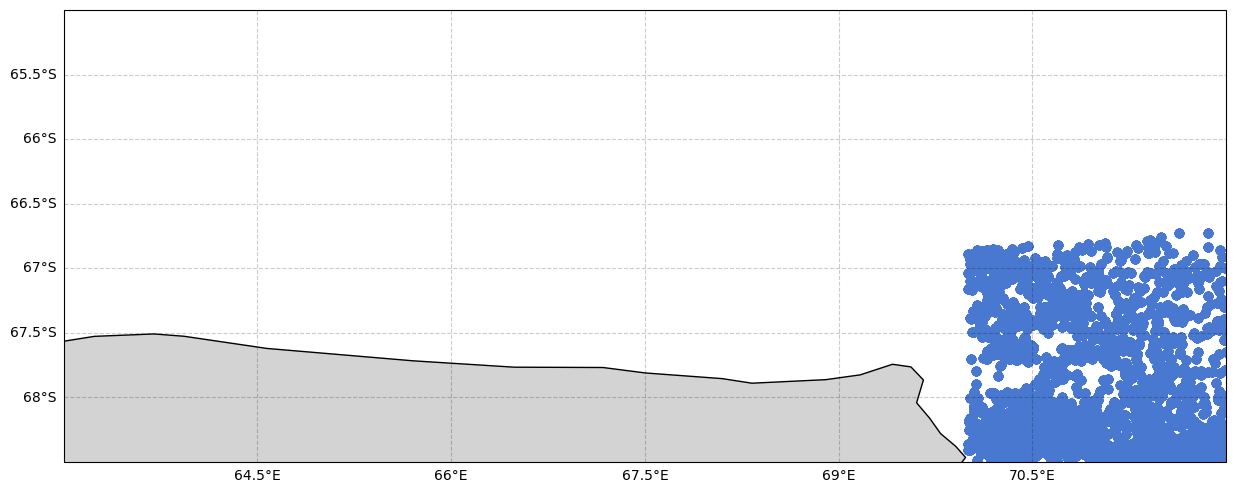

In [183]:
#Check the data has been cropped correctly


# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -65])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
#im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

plt.scatter(seals_lon_in_range, seals_lat_in_range)

ax = plt.gca()

plt.show()

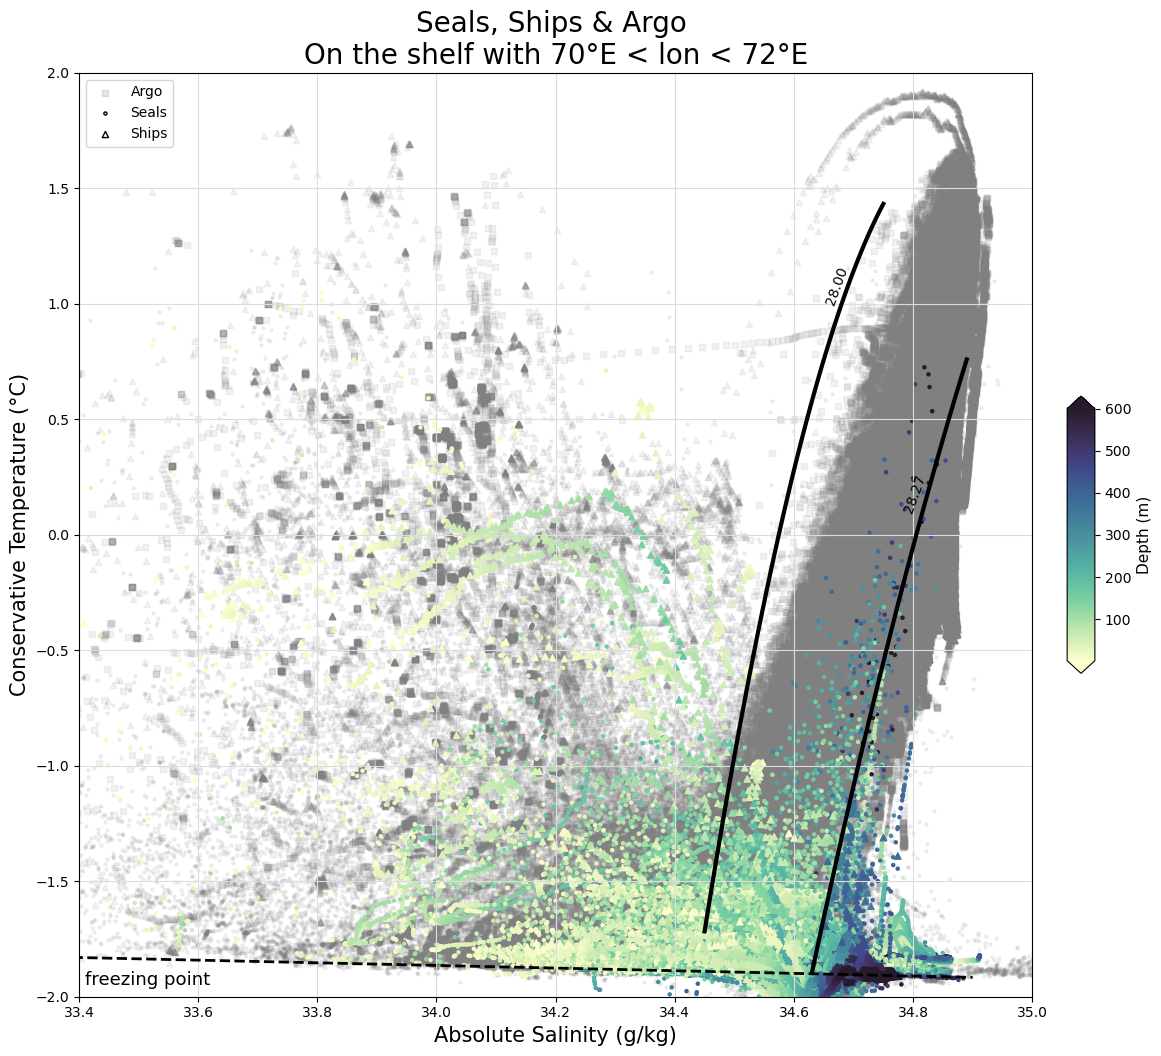

In [184]:
########################################################################################################################
####################################################plotting############################################################
########################################################################################################################


#set the size of the figure
plt.figure(figsize=(15, 12)) 


# Define custom color boundaries
vmin1 = 27
vmax2 = 28
vmax3 = 28.27
vmax4 = 29


# Define colors for different ranges
#colors = [(0.7, 0.7, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
colors = [(0.5, 0.5, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
#colors = [(0.7, 0.7, 0.7), (0, 0, 1), (0.3, 0.3, 0.3)]  # Light blue, blue, dark blue
#cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
cmap_custom = mcolors.ListedColormap(colors)

# Normalize the colormap
norm = mcolors.BoundaryNorm([vmin1, vmax2, vmax3, vmax4], cmap_custom.N)





# # Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter_out_range = plt.scatter(seals_abs_salinity_out_range, seals_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=5, marker='o')

ships_scatter_out_range = plt.scatter(ships_abs_salinity_out_range, ships_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=20, marker='^')

argo_scatter_out_range = plt.scatter(argo_abs_salinity_out_range, argo_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=20, marker='s', label='Argo')


seals_scatter_in_range = plt.scatter(seals_abs_salinity_in_range, seals_cons_temperature_in_range,
                           s=5, c=seals_depth_in_range, cmap=cmap_deep, vmax=600, marker='o', label='Seals')

ships_scatter_in_range = plt.scatter(ships_abs_salinity_in_range, ships_cons_temperature_in_range,
                           s=20, c=ships_depth_in_range, cmap=cmap_deep, vmax=600, marker='^', label='Ships')

#argo_scatter_in_range = plt.scatter(argo_abs_salinity_in_range, argo_cons_temperature_in_range,
#                           s=20, c=argo_depth_in_range, cmap=cmap_deep, vmax=600, marker='s', label='Argo')





#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'black', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.78,0.1,'28.27', rotation=70, fontsize=10)
plt.text(34.65,1,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.95,'freezing point', fontsize=13, color = 'black')

#Plot the potential density contour lines
# comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Absolute Salinity (g/kg)',  fontsize=15)
plt.ylabel('Conservative Temperature (°C)',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
cbar = plt.colorbar(seals_scatter_in_range, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_custom),orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)
cbar.set_label('Depth (m)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')


plt.plot(x_curve1, y_curve1, color='black', linewidth=3, label='Contour Line')
plt.plot(x_curve2, y_curve2, color='black', linewidth=3, label='Contour Line')

# Add a dynamic title
#plt.title(f'Seals & ships \nLat {lat_min} to {lat_max} & Lon {lon_min} to {lon_max}', fontsize=20)
plt.title(f'Seals, Ships & Argo \nOn the shelf with {lon_min}°E < lon < {lon_max}°E', fontsize=20)

plt.show()

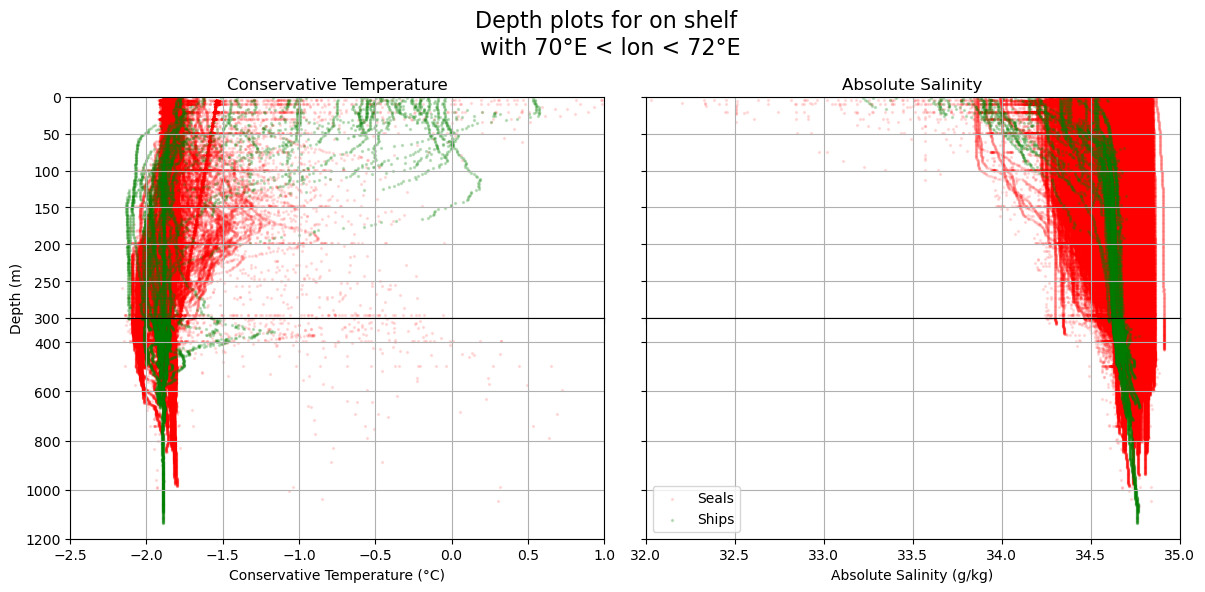

In [185]:
# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))


# Plot Temperature vs. Depth on the top left subplot (ax1)
ax1.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='red', alpha=0.1, s=2, label='Seals')
ax1.scatter(ships_cons_temperature_in_range, ships_depth_in_range, c='green', alpha=0.2, s=2, label='Ships')
# ax2.scatter(argo_cons_temperature_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 300)
ax1.set_xlim(-2.5, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom left subplot (ax3)
ax3.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='red', alpha=0.1, s=2, label='Seals')
ax3.scatter(ships_cons_temperature_in_range, ships_depth_in_range, c='green', alpha=0.2, s=2, label='Ships')
# ax3.scatter(argo_cons_temperature_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(300, 1200)
ax3.set_xlim(-2.5, 1)
ax3.invert_yaxis()  # Flip the y-axis


# Plot Salinity vs. Depth on the top right subplot (ax2)
ax2.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='red', alpha=0.1, s=2, label='Seals')
ax2.scatter(ships_abs_salinity_in_range, ships_depth_in_range, c='green', alpha=0.2, s=2, label='Ships')
# ax2.scatter(argo_abs_salinity_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 300)
ax2.set_xlim(32, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom right subplot (ax4)
ax4.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='red', alpha=0.1, s=2, label='Seals')
ax4.scatter(ships_abs_salinity_in_range, ships_depth_in_range, c='green', alpha=0.2, s=2, label='Ships')
# ax4.scatter(argo_abs_salinity_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(300, 1200)
ax4.set_xlim(32, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')



# Add a large title that spans both subplots
fig.suptitle(f'Depth plots for on shelf \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

#Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


In [186]:
# Find ship casts with maximum depth greater than 800m
max_depths = []
start_index = 0

for i in range(1, len(ships_depth_in_range)):
    if ships_depth_in_range[i] < ships_depth_in_range[i - 1]:
        max_depths.append((start_index, i - 1, ships_depth_in_range[start_index:i].max()))
        start_index = i

# Check if the last cast is also a problematic cast
if ships_depth_in_range[-1] < ships_depth_in_range[-2]:
    max_depths.append((start_index, len(ships_depth_in_range) - 1, ships_depth_in_range[start_index:].max()))

# Identify and remove casts with max depth > 800m
casts_to_remove = [cast for cast in max_depths if cast[2] > 800]

print(max_depths)
print(casts_to_remove)

[(0, 203, 405.510923689659), (204, 415, 419.337742389243), (416, 667, 498.383090693409), (668, 866, 397.600349209479), (867, 1139, 541.824099772748), (1140, 1389, 494.400478844815), (1390, 1605, 427.262831964847), (1606, 2181, 1137.28968027152), (2182, 2424, 480.572097315845), (2425, 2577, 302.70567933897), (2578, 2652, 148.448124134718), (2653, 2989, 666.185395414173), (2990, 3149, 316.566422357878), (3150, 3265, 229.564526038816), (3266, 3423, 312.619549434071), (3424, 3672, 492.411214665809), (3673, 3848, 348.172103268023), (3849, 3929, 160.324537112787), (3930, 4017, 174.160524991437), (4018, 4071, 106.898804875748), (4072, 4147, 152.402063969852), (4148, 4231, 166.259779633249), (4232, 4308, 152.412898013894), (4309, 4550, 478.630625115417), (4551, 4784, 462.797929679194), (4785, 4813, 57.4101458298001), (4814, 4935, 241.40921201931), (4936, 5211, 547.708295529811), (5212, 5539, 650.397808602239), (5540, 5543, 53.4556259259492), (5544, 6096, 1091.99614673547), (6097, 6223, 251.321

In [187]:
# Extract start and end points from casts_to_remove
indices_to_remove = np.concatenate([np.arange(start, end + 1) for start, end, _ in casts_to_remove])

# Create new NumPy arrays without the specified indices
ships_depth_in_range_cleaned = np.delete(ships_depth_in_range, indices_to_remove)
ships_cons_temperature_in_range_cleaned = np.delete(ships_cons_temperature_in_range, indices_to_remove)
ships_abs_salinity_in_range_cleaned = np.delete(ships_abs_salinity_in_range, indices_to_remove)
len(ships_depth_in_range_cleaned)

6462

In [188]:
# Find seal casts with maximum depth greater than 800m
max_depths = []
start_index = 0

for i in range(1, len(seals_depth_in_range)):
    if seals_depth_in_range[i] < seals_depth_in_range[i - 1]:
        max_depths.append((start_index, i - 1, seals_depth_in_range[start_index:i].max()))
        start_index = i

# Check if the last cast is also a problematic cast
if seals_depth_in_range[-1] < seals_depth_in_range[-2]:
    max_depths.append((start_index, len(seals_depth_in_range) - 1, seals_depth_in_range[start_index:].max()))

# Identify and remove casts with max depth > 800m
casts_to_remove = [cast for cast in max_depths if cast[2] > 800]

print(max_depths)
print(casts_to_remove)

[(0, 7, 395.60725033737), (8, 23, 774.672038630718), (24, 39, 320.501293640188), (40, 55, 286.892646071368), (56, 71, 263.165393113792), (72, 87, 298.756946558527), (88, 103, 286.895170867916), (104, 119, 282.939814022025), (120, 135, 243.390283225498), (136, 151, 229.545936554649), (152, 167, 205.812350807442), (168, 183, 209.768323383469), (184, 199, 237.45751084462), (200, 215, 277.007506679611), (216, 231, 225.591221303722), (232, 239, 197.899892700161), (240, 255, 241.411257775705), (256, 271, 257.232094116198), (272, 287, 277.007035780468), (288, 303, 271.075672000258), (304, 319, 308.643257736153), (320, 335, 280.962794318363), (336, 343, 296.779683941803), (344, 359, 239.435058490098), (360, 375, 251.299651619323), (376, 391, 237.457598493457), (392, 407, 241.412894030351), (408, 423, 247.346013293411), (424, 439, 251.300800121848), (440, 455, 286.892892319063), (456, 471, 273.051996646141), (472, 487, 300.73229722796), (488, 503, 334.338502665231), (504, 519, 296.776903559913)

In [189]:
# Extract start and end points from casts_to_remove
indices_to_remove = np.concatenate([np.arange(start, end + 1) for start, end, _ in casts_to_remove])

# Create new NumPy arrays without the specified indices
seals_depth_in_range_cleaned = np.delete(seals_depth_in_range, indices_to_remove)
seals_cons_temperature_in_range_cleaned = np.delete(seals_cons_temperature_in_range, indices_to_remove)
seals_abs_salinity_in_range_cleaned = np.delete(seals_abs_salinity_in_range, indices_to_remove)
len(seals_depth_in_range)
len(seals_depth_in_range_cleaned)

357932

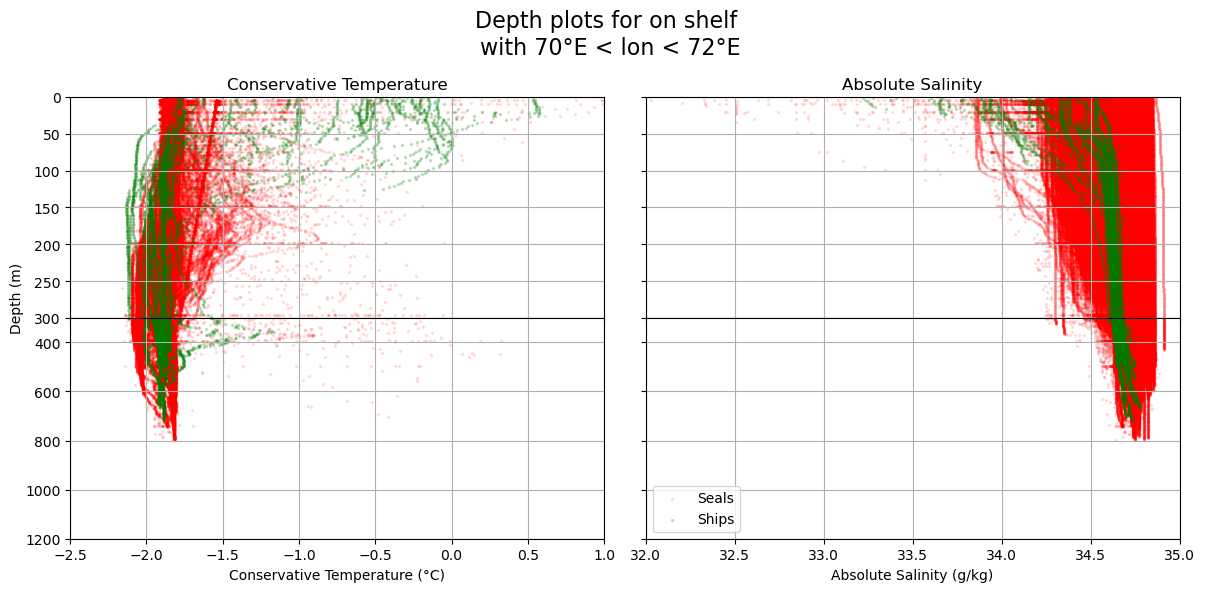

In [190]:
# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))


# Plot Temperature vs. Depth on the top left subplot (ax1)
ax1.scatter(seals_cons_temperature_in_range_cleaned, seals_depth_in_range_cleaned, c='red', alpha=0.1, s=2, label='Seals')
ax1.scatter(ships_cons_temperature_in_range_cleaned, ships_depth_in_range_cleaned, c='green', alpha=0.2, s=2, label='Ships')
# ax2.scatter(argo_cons_temperature_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 300)
ax1.set_xlim(-2.5, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom left subplot (ax3)
ax3.scatter(seals_cons_temperature_in_range_cleaned, seals_depth_in_range_cleaned, c='red', alpha=0.1, s=2, label='Seals')
ax3.scatter(ships_cons_temperature_in_range_cleaned, ships_depth_in_range_cleaned, c='green', alpha=0.2, s=2, label='Ships')
# ax3.scatter(argo_cons_temperature_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(300, 1200)
ax3.set_xlim(-2.5, 1)
ax3.invert_yaxis()  # Flip the y-axis


# Plot Salinity vs. Depth on the top right subplot (ax2)
ax2.scatter(seals_abs_salinity_in_range_cleaned, seals_depth_in_range_cleaned, c='red', alpha=0.1, s=2, label='Seals')
ax2.scatter(ships_abs_salinity_in_range_cleaned, ships_depth_in_range_cleaned, c='green', alpha=0.2, s=2, label='Ships')
# ax2.scatter(argo_abs_salinity_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 300)
ax2.set_xlim(32, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom right subplot (ax4)
ax4.scatter(seals_abs_salinity_in_range_cleaned, seals_depth_in_range_cleaned, c='red', alpha=0.1, s=2, label='Seals')
ax4.scatter(ships_abs_salinity_in_range_cleaned, ships_depth_in_range_cleaned, c='green', alpha=0.2, s=2, label='Ships')
# ax4.scatter(argo_abs_salinity_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(300, 1200)
ax4.set_xlim(32, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')



# Add a large title that spans both subplots
fig.suptitle(f'Depth plots for on shelf \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

#Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


In [191]:
#calculate mean line 

# Combine the data for both seals and ships
all_depths = np.concatenate((seals_depth_in_range_cleaned, ships_depth_in_range_cleaned))
all_salinity = np.concatenate((seals_abs_salinity_in_range_cleaned, ships_abs_salinity_in_range_cleaned))
all_temperature = np.concatenate((seals_cons_temperature_in_range_cleaned, ships_cons_temperature_in_range_cleaned))

# Define depth bins with 10-meter width
depth_bins = np.arange(0, np.max(all_depths) + 25, 25)

# Assign each depth value to a bin
depth_bin_indices = np.digitize(all_depths, depth_bins)

# Calculate the mean or median salinity and temperature for each depth bin
mean_salinity = [np.nanmean(all_salinity[depth_bin_indices == i]) for i in range(1, len(depth_bins)+1)]
mean_temperature = [np.nanmean(all_temperature[depth_bin_indices == i]) for i in range(1, len(depth_bins)+1)]
mean_depths = (depth_bins[depth_bin_indices] + depth_bins[depth_bin_indices-1])*0.5

/tmp/ipykernel_446986/2333015048.py:15: RuntimeWarning: Mean of empty slice
  mean_salinity = [np.nanmean(all_salinity[depth_bin_indices == i]) for i in range(1, len(depth_bins)+1)]
/tmp/ipykernel_446986/2333015048.py:16: RuntimeWarning: Mean of empty slice
  mean_temperature = [np.nanmean(all_temperature[depth_bin_indices == i]) for i in range(1, len(depth_bins)+1)]


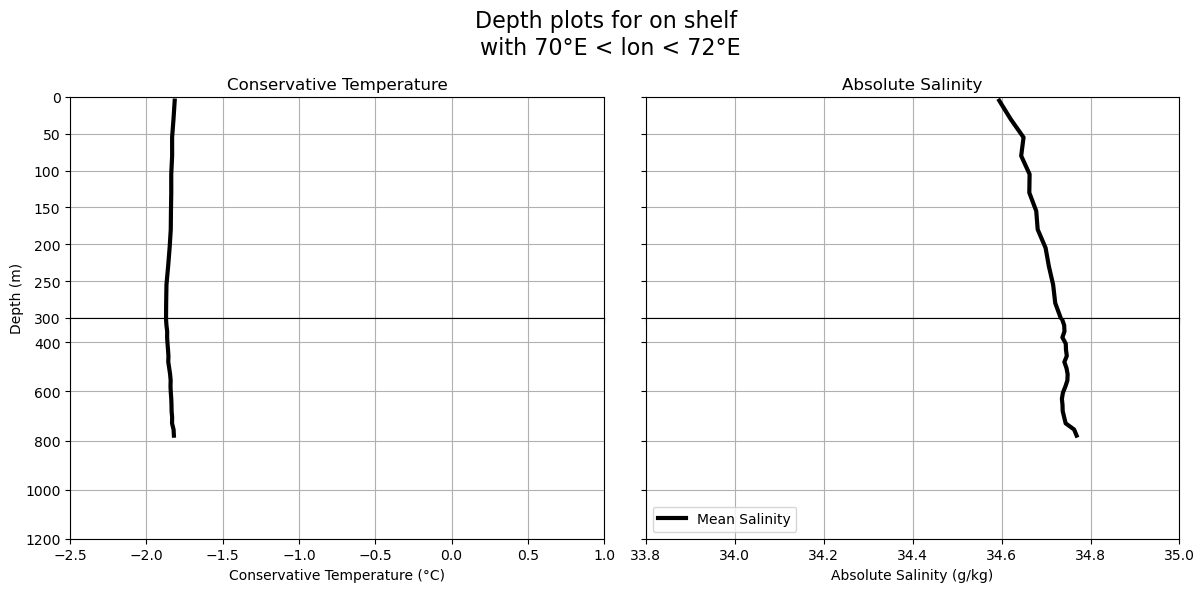

In [192]:
# Visualise mean 


# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))


# Plot Temperature vs. Depth on the top right subplot (ax2)
ax1.plot(mean_temperature, depth_bins+5, label='Mean Temperature', color = 'black', linewidth = 3)
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 300)
ax1.set_xlim(-2.5, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom right subplot (ax4)
ax3.plot(mean_temperature, depth_bins+5, label='Mean Temperature', color = 'black', linewidth = 3)
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(300, 1200)
ax3.set_xlim(-2.5, 1)
ax3.invert_yaxis()  # Flip the y-axis


# Plot Salinity vs. Depth on the top left subplot (ax1)
ax2.plot(mean_salinity, depth_bins+5, label='Mean Salinity', color = 'black', linewidth = 3)
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 300)
ax2.set_xlim(33.8, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom left subplot (ax3)
ax4.plot(mean_salinity, depth_bins+5, label='Mean Salinity', color = 'black', linewidth = 3)
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(300, 1200)
ax4.set_xlim(33.8, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')



# Add a large title that spans both subplots
fig.suptitle(f'Depth plots for on shelf \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

#Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


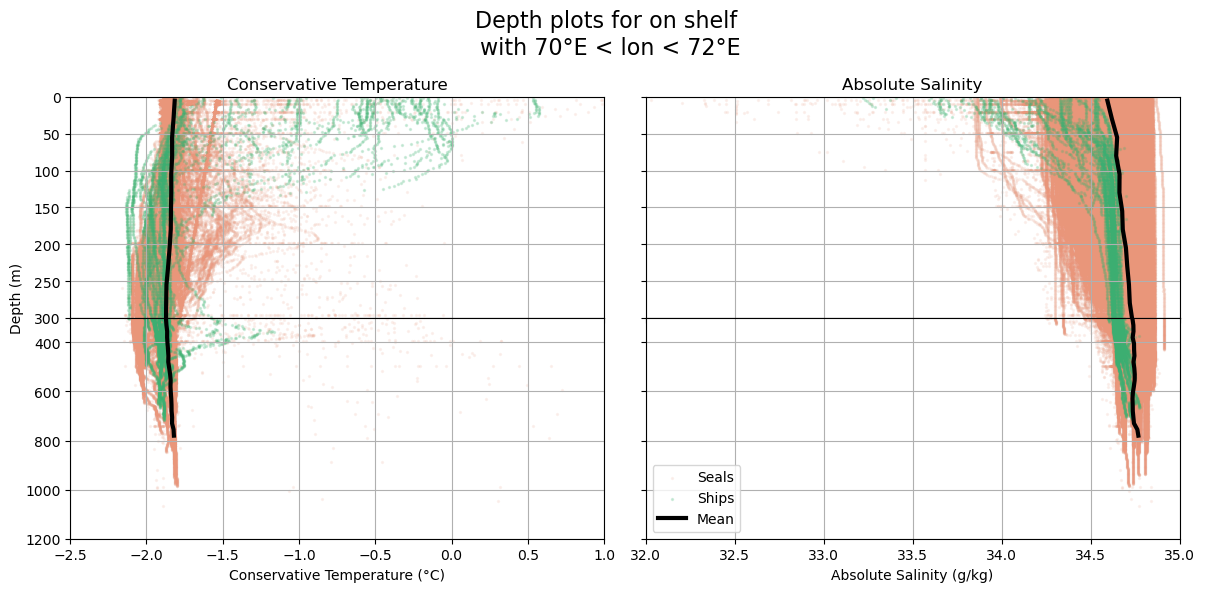

In [193]:
# Combine mean & raw data


# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))


# Plot Temperature vs. Depth on the top left subplot (ax1)
ax1.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='darksalmon', alpha=0.1, s=2, label='Seals')
ax1.scatter(ships_cons_temperature_in_range_cleaned, ships_depth_in_range_cleaned, c='mediumseagreen', alpha=0.2, s=2, label='Ships')
# ax2.scatter(argo_cons_temperature_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax1.plot(mean_temperature, depth_bins+5, label='Mean Temperature', color = 'black', linewidth = 3)
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 300)
ax1.set_xlim(-2.5, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom left subplot (ax3)
ax3.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='darksalmon', alpha=0.1, s=2, label='Seals')
ax3.scatter(ships_cons_temperature_in_range_cleaned, ships_depth_in_range_cleaned, c='mediumseagreen', alpha=0.2, s=2, label='Ships')
# ax3.scatter(argo_cons_temperature_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax3.plot(mean_temperature, depth_bins+5, label='Mean Temperature', color = 'black', linewidth = 3)
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(300, 1200)
ax3.set_xlim(-2.5, 1)
ax3.invert_yaxis()  # Flip the y-axis


# Plot Salinity vs. Depth on the top right subplot (ax2)
ax2.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='darksalmon', alpha=0.1, s=2, label='Seals')
ax2.scatter(ships_abs_salinity_in_range_cleaned, ships_depth_in_range_cleaned, c='mediumseagreen', alpha=0.2, s=2, label='Ships')
# ax2.scatter(argo_abs_salinity_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax2.plot(mean_salinity, depth_bins+5, label='Mean', color = 'black', linewidth = 3)
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 300)
ax2.set_xlim(32, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom right subplot (ax4)
ax4.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='darksalmon', alpha=0.1, s=2, label='Seals')
ax4.scatter(ships_abs_salinity_in_range_cleaned, ships_depth_in_range_cleaned, c='mediumseagreen', alpha=0.2, s=2, label='Ships')
# ax4.scatter(argo_abs_salinity_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax4.plot(mean_salinity, depth_bins+5, label='Mean', color = 'black', linewidth = 3)
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(300, 1200)
ax4.set_xlim(32, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')



# Add a large title that spans both subplots
fig.suptitle(f'Depth plots for on shelf \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

#Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


In [124]:
# west
average_abs_salinity_shelf_west = mean_salinity
average_cons_temperature_shelf_west = mean_temperature
average_depth_shelf_west = depth_bins+5

In [139]:
# central
average_abs_salinity_shelf_central = mean_salinity
average_cons_temperature_shelf_central = mean_temperature
average_depth_shelf_central = depth_bins+5

In [194]:
# east
average_abs_salinity_shelf_east = mean_salinity
average_cons_temperature_shelf_east = mean_temperature
average_depth_shelf_east = depth_bins+5

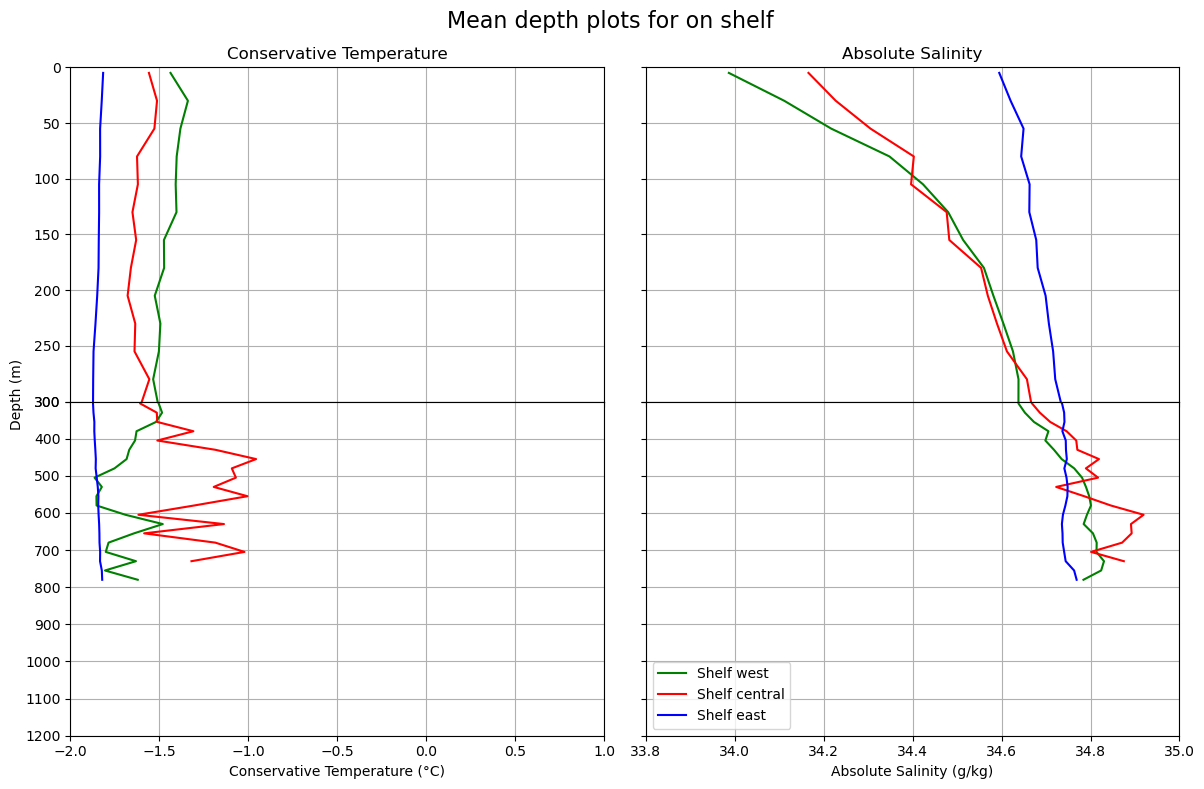

In [275]:
# Combine all means


# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))


# Plot Temperature vs. Depth on the top left subplot (ax1)
ax1.plot(average_cons_temperature_shelf_west, average_depth_shelf_west, color='green', label='Shelf west')
ax1.plot(average_cons_temperature_shelf_central, average_depth_shelf_central, color='red', label='Shelf central')
ax1.plot(average_cons_temperature_shelf_east, average_depth_shelf_east, color='blue', label='Shelf east')
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 300)
ax1.set_xlim(-2, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom left subplot (ax3)
ax3.plot(average_cons_temperature_shelf_west, average_depth_shelf_west, color='green', label='Shelf west')
ax3.plot(average_cons_temperature_shelf_central, average_depth_shelf_central, color='red', label='Shelf central')
ax3.plot(average_cons_temperature_shelf_east, average_depth_shelf_east, color='blue', label='Shelf east')
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(300, 1200)
ax3.set_xlim(-2, 1)
ax3.invert_yaxis()  # Flip the y-axis


# Plot Salinity vs. Depth on the top right subplot (ax2)
ax2.plot(average_abs_salinity_shelf_west, average_depth_shelf_west, color='green', label='Shelf west')
ax2.plot(average_abs_salinity_shelf_central, average_depth_shelf_central, color='red', label='Shelf central')
ax2.plot(average_abs_salinity_shelf_east, average_depth_shelf_east, color='blue', label='Shelf east')
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 300)
ax2.set_xlim(33.8, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom right subplot (ax4)
ax4.plot(average_abs_salinity_shelf_west, average_depth_shelf_west, color='green', label='Shelf west')
ax4.plot(average_abs_salinity_shelf_central, average_depth_shelf_central, color='red', label='Shelf central')
ax4.plot(average_abs_salinity_shelf_east, average_depth_shelf_east, color='blue', label='Shelf east')
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(300, 1200)
ax4.set_xlim(33.8, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')



# Add a large title that spans both subplots
fig.suptitle(f'Mean depth plots for on shelf', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

#Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


In [ ]:
########################################################################################################
########################################################################################################
####################################### create slope contour mask ######################################
########################################################################################################
########################################################################################################

In [14]:
#load in the 2000m contour 
# this was calculated in the notebook 'calculating_depth_contours.ipynb'
slope_contour = np.load('contour_coordinates_slope_2000m.npy')

In [15]:
# Load in the shelf polygon coordinates from the CSV
polygon_slope_coords = pd.read_csv('polygon_slope.csv')

# Create a Shapely Polygon from the coordinates
polygon_slope = Polygon(zip(polygon_slope_coords['X'], polygon_slope_coords['Y']))

# Extract X and Y coordinates
x = polygon_slope_coords['X'].tolist()
y = polygon_slope_coords['Y'].tolist()

<Figure size 640x480 with 0 Axes>

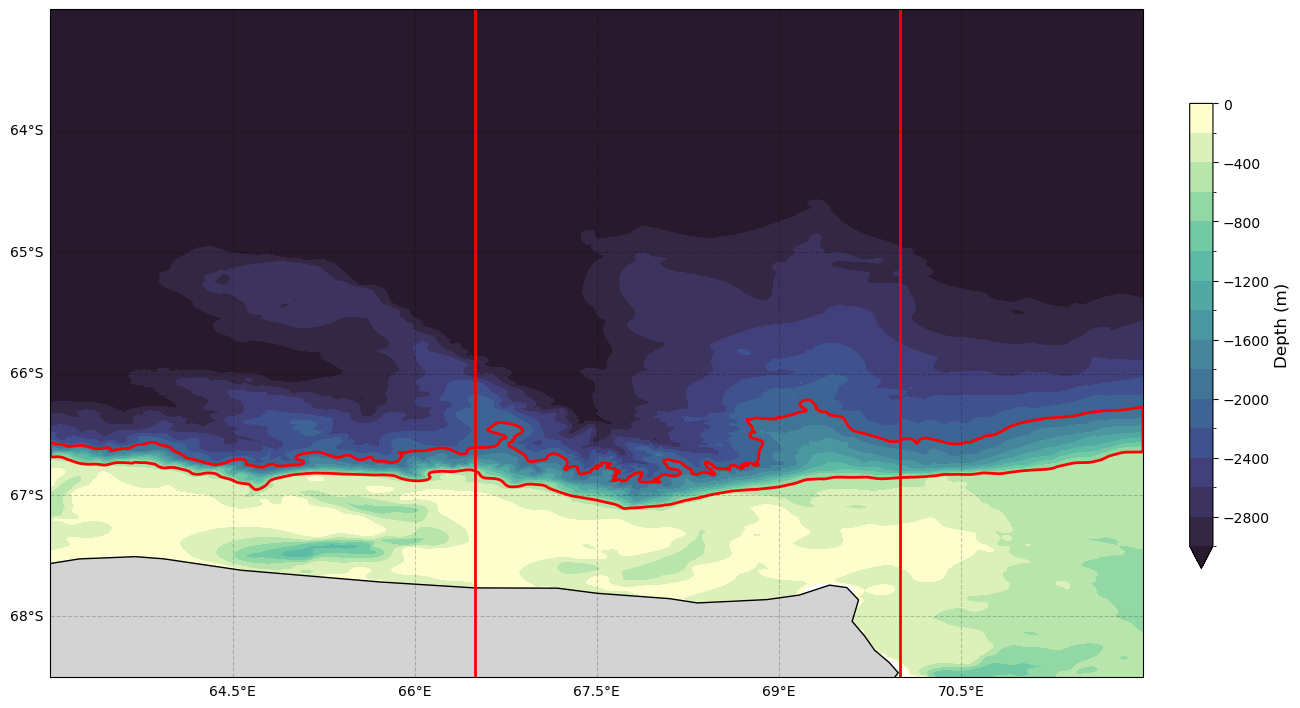

In [198]:
#This plots the polygon on the map to check it works

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Add a contour line for the 600m isobath
##contour_line_coordinates comes from 'CTD mapping seals and CTD with type' notebook. 
#ax.plot(contour_line_coordinates[:, 0], contour_line_coordinates[:, 1], color='white', linewidth=3)

# # Plot the result using Matplotlib
# x, y = polygon.exterior.xy

# Plot the contour polygon
ax.plot(x, y, color='red', linewidth=2)

# Add red lines at longitude 66.5 and 70
ax.axvline(66.5, color='red', linewidth=2)
ax.axvline(70, color='red', linewidth=2)


# Create a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.show()

In [50]:
# #west
# lon_min = 63
# lon_max = 66.5

# #central
# lon_min = 66.5
# lon_max = 70

#east
lon_min = 70
lon_max = 72

In [ ]:
#this crops the data with the slope polygon and finds data inside, and outside of this polygon
#Choose is you want east, central or west by changing the cell above

In [51]:
################################ SEALS ################################
# Initialize lists to store indices for data within and outside the polygon
seals_indices_in_range = []
seals_indices_out_range = []

# Loop through your data points (assuming latitude and longitude are numpy arrays)
for i in range(len(seals_latitude)):
    latitude = seals_latitude[i]
    longitude = seals_longitude[i]
    point = Point(longitude, latitude)
    
    # # Check if the point is within the polygon (use this if you just want on slope, slope & offshore)
    # if polygon_slope.contains(point):
    #     seals_indices_in_range.append(i)
    # else:
    #     seals_indices_out_range.append(i)
    
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_slope.contains(point) and lon_min <= longitude <= lon_max:
        seals_indices_in_range.append(i)
    else:
        seals_indices_out_range.append(i)

# Convert the index lists to NumPy arrays for indexing
seals_indices_in_range = np.array(seals_indices_in_range)
seals_indices_out_range = np.array(seals_indices_out_range)

# Crop the data based on the indices
seals_cons_temperature_in_range = seals_cons_temperature[seals_indices_in_range]
seals_abs_salinity_in_range = seals_abs_salinity[seals_indices_in_range]
seals_depth_in_range = seals_depth[seals_indices_in_range]
seals_neutral_density_in_range = seals_neutral_density[seals_indices_in_range]
seals_time_in_range = seals_time[seals_indices_in_range]
seals_lat_in_range = seals_latitude[seals_indices_in_range]
seals_lon_in_range = seals_longitude[seals_indices_in_range]

seals_cons_temperature_out_range = seals_cons_temperature[seals_indices_out_range]
seals_abs_salinity_out_range = seals_abs_salinity[seals_indices_out_range]
seals_depth_out_range = seals_depth[seals_indices_out_range]
seals_neutral_density_out_range = seals_neutral_density[seals_indices_out_range]
seals_time_out_range = seals_time[seals_indices_out_range]
seals_lat_out_range = seals_latitude[seals_indices_out_range]
seals_lon_out_range = seals_longitude[seals_indices_out_range]


In [52]:
################################ SHIPS ################################

# Initialize lists to store indices for data within and outside the polygon
ships_indices_in_range = []
ships_indices_out_range = []

for i in range(len(ships_latitude)):
    latitude = ships_latitude[i]
    longitude = ships_longitude[i]
    point = Point(longitude, latitude)
    
    # # Check if the point is within the polygon (use this if you just want on slope, slope & offshore)
    # if polygon_slope.contains(point):
    #     ships_indices_in_range.append(i)
    # else:
    #     ships_indices_out_range.append(i)
    
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_slope.contains(point) and lon_min <= longitude <= lon_max:
        ships_indices_in_range.append(i)
    else:
        ships_indices_out_range.append(i)

# Convert the index lists to NumPy arrays for indexing
ships_indices_in_range = np.array(ships_indices_in_range)
ships_indices_out_range = np.array(ships_indices_out_range)

# Crop the data based on the indices
ships_cons_temperature_in_range = ships_cons_temperature[ships_indices_in_range]
ships_abs_salinity_in_range = ships_abs_salinity[ships_indices_in_range]
ships_depth_in_range = ships_depth[ships_indices_in_range]
ships_neutral_density_in_range = ships_neutral_density[ships_indices_in_range]
ships_time_in_range = ships_time[ships_indices_in_range]
ships_lat_in_range = ships_latitude[ships_indices_in_range]
ships_lon_in_range = ships_longitude[ships_indices_in_range]

ships_cons_temperature_out_range = ships_cons_temperature[ships_indices_out_range]
ships_abs_salinity_out_range = ships_abs_salinity[ships_indices_out_range]
ships_depth_out_range = ships_depth[ships_indices_out_range]
ships_neutral_density_out_range = ships_neutral_density[ships_indices_out_range]
ships_time_out_range = ships_time[ships_indices_out_range]
ships_lat_out_range = ships_latitude[ships_indices_out_range]
ships_lon_out_range = ships_longitude[ships_indices_out_range]

In [53]:
################################ ARGO ################################

# Initialize lists to store indices for data within and outside the polygon
argo_indices_in_range = []
argo_indices_out_range = []

for i in range(len(argo_latitude)):
    latitude = argo_latitude[i]
    longitude = argo_longitude[i]
    point = Point(longitude, latitude)
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_slope.contains(point) and lon_min <= longitude <= lon_max:
        argo_indices_in_range.append(i)
    else:
        argo_indices_out_range.append(i)

# Convert the index lists to NumPy arrays for indexing
argo_indices_in_range = np.array(argo_indices_in_range)
argo_indices_out_range = np.array(argo_indices_out_range)

# Crop the data based on the indices
argo_cons_temperature_in_range = argo_cons_temperature[argo_indices_in_range]
argo_abs_salinity_in_range = argo_abs_salinity[argo_indices_in_range]
argo_depth_in_range = argo_depth[argo_indices_in_range]
argo_neutral_density_in_range = argo_neutral_density[argo_indices_in_range]
argo_time_in_range = argo_time[argo_indices_in_range]
argo_lat_in_range = argo_latitude[argo_indices_in_range]
argo_lon_in_range = argo_longitude[argo_indices_in_range]

argo_cons_temperature_out_range = argo_cons_temperature[argo_indices_out_range]
argo_abs_salinity_out_range = argo_abs_salinity[argo_indices_out_range]
argo_depth_out_range = argo_depth[argo_indices_out_range]
argo_neutral_density_out_range = argo_neutral_density[argo_indices_out_range]
argo_time_out_range = argo_time[argo_indices_out_range]
argo_lat_out_range = argo_latitude[argo_indices_out_range]
argo_lon_out_range = argo_longitude[argo_indices_out_range]


In [44]:
# export slope west

# Create a dictionary to store the values
data = {
    "seals_cons_temperature_in_range": seals_cons_temperature_in_range,
    "seals_abs_salinity_in_range": seals_abs_salinity_in_range,
    "seals_depth_in_range": seals_depth_in_range,
    "seals_neutral_density_in_range": seals_neutral_density_in_range,
    "seals_time_in_range": seals_time_in_range,
    "seals_lat_in_range": seals_lat_in_range,
    "seals_lon_in_range": seals_lon_in_range,
    "seals_cons_temperature_out_range": seals_cons_temperature_out_range,
    "seals_abs_salinity_out_range": seals_abs_salinity_out_range,
    "seals_depth_out_range": seals_depth_out_range,
    "seals_neutral_density_out_range": seals_neutral_density_out_range,
    "seals_time_out_range": seals_time_out_range,
    "seals_lat_out_range": seals_lat_out_range,
    "seals_lon_out_range": seals_lon_out_range,
    "ships_cons_temperature_in_range": ships_cons_temperature_in_range,
    "ships_abs_salinity_in_range": ships_abs_salinity_in_range,
    "ships_depth_in_range": ships_depth_in_range,
    "ships_neutral_density_in_range": ships_neutral_density_in_range,
    "ships_time_in_range": ships_time_in_range,
    "ships_lat_in_range": ships_lat_in_range,
    "ships_lon_in_range": ships_lon_in_range,
    "ships_cons_temperature_out_range": ships_cons_temperature_out_range,
    "ships_abs_salinity_out_range": ships_abs_salinity_out_range,
    "ships_depth_out_range": ships_depth_out_range,
    "ships_neutral_density_out_range": ships_neutral_density_out_range,
    "ships_time_out_range": ships_time_out_range,
    "ships_lat_out_range": ships_lat_out_range,
    "ships_lon_out_range": ships_lon_out_range,
    "argo_cons_temperature_in_range": argo_cons_temperature_in_range,
    "argo_abs_salinity_in_range": argo_abs_salinity_in_range,
    "argo_depth_in_range": argo_depth_in_range,
    "argo_neutral_density_in_range": argo_neutral_density_in_range,
    "argo_time_in_range": argo_time_in_range,
    "argo_lat_in_range": argo_lat_in_range,
    "argo_lon_in_range": argo_lon_in_range,
    "argo_cons_temperature_out_range": argo_cons_temperature_out_range,
    "argo_abs_salinity_out_range": argo_abs_salinity_out_range,
    "argo_depth_out_range": argo_depth_out_range,
    "argo_neutral_density_out_range": argo_neutral_density_out_range,
    "argo_time_out_range": argo_time_out_range,
    "argo_lat_out_range": argo_lat_out_range
}


# Save the data to a file using pickle
with open('slope_west_seals_ships_argo_data.pkl', 'wb') as file:
    pickle.dump(data, file)

In [49]:
# export slope central

# Create a dictionary to store the values
data = {
    "seals_cons_temperature_in_range": seals_cons_temperature_in_range,
    "seals_abs_salinity_in_range": seals_abs_salinity_in_range,
    "seals_depth_in_range": seals_depth_in_range,
    "seals_neutral_density_in_range": seals_neutral_density_in_range,
    "seals_time_in_range": seals_time_in_range,
    "seals_lat_in_range": seals_lat_in_range,
    "seals_lon_in_range": seals_lon_in_range,
    "seals_cons_temperature_out_range": seals_cons_temperature_out_range,
    "seals_abs_salinity_out_range": seals_abs_salinity_out_range,
    "seals_depth_out_range": seals_depth_out_range,
    "seals_neutral_density_out_range": seals_neutral_density_out_range,
    "seals_time_out_range": seals_time_out_range,
    "seals_lat_out_range": seals_lat_out_range,
    "seals_lon_out_range": seals_lon_out_range,
    "ships_cons_temperature_in_range": ships_cons_temperature_in_range,
    "ships_abs_salinity_in_range": ships_abs_salinity_in_range,
    "ships_depth_in_range": ships_depth_in_range,
    "ships_neutral_density_in_range": ships_neutral_density_in_range,
    "ships_time_in_range": ships_time_in_range,
    "ships_lat_in_range": ships_lat_in_range,
    "ships_lon_in_range": ships_lon_in_range,
    "ships_cons_temperature_out_range": ships_cons_temperature_out_range,
    "ships_abs_salinity_out_range": ships_abs_salinity_out_range,
    "ships_depth_out_range": ships_depth_out_range,
    "ships_neutral_density_out_range": ships_neutral_density_out_range,
    "ships_time_out_range": ships_time_out_range,
    "ships_lat_out_range": ships_lat_out_range,
    "ships_lon_out_range": ships_lon_out_range,
    "argo_cons_temperature_in_range": argo_cons_temperature_in_range,
    "argo_abs_salinity_in_range": argo_abs_salinity_in_range,
    "argo_depth_in_range": argo_depth_in_range,
    "argo_neutral_density_in_range": argo_neutral_density_in_range,
    "argo_time_in_range": argo_time_in_range,
    "argo_lat_in_range": argo_lat_in_range,
    "argo_lon_in_range": argo_lon_in_range,
    "argo_cons_temperature_out_range": argo_cons_temperature_out_range,
    "argo_abs_salinity_out_range": argo_abs_salinity_out_range,
    "argo_depth_out_range": argo_depth_out_range,
    "argo_neutral_density_out_range": argo_neutral_density_out_range,
    "argo_time_out_range": argo_time_out_range,
    "argo_lat_out_range": argo_lat_out_range
}


# Save the data to a file using pickle
with open('slope_central_seals_ships_argo_data.pkl', 'wb') as file:
    pickle.dump(data, file)

In [54]:
# export slope east

# Create a dictionary to store the values
data = {
    "seals_cons_temperature_in_range": seals_cons_temperature_in_range,
    "seals_abs_salinity_in_range": seals_abs_salinity_in_range,
    "seals_depth_in_range": seals_depth_in_range,
    "seals_neutral_density_in_range": seals_neutral_density_in_range,
    "seals_time_in_range": seals_time_in_range,
    "seals_lat_in_range": seals_lat_in_range,
    "seals_lon_in_range": seals_lon_in_range,
    "seals_cons_temperature_out_range": seals_cons_temperature_out_range,
    "seals_abs_salinity_out_range": seals_abs_salinity_out_range,
    "seals_depth_out_range": seals_depth_out_range,
    "seals_neutral_density_out_range": seals_neutral_density_out_range,
    "seals_time_out_range": seals_time_out_range,
    "seals_lat_out_range": seals_lat_out_range,
    "seals_lon_out_range": seals_lon_out_range,
    "ships_cons_temperature_in_range": ships_cons_temperature_in_range,
    "ships_abs_salinity_in_range": ships_abs_salinity_in_range,
    "ships_depth_in_range": ships_depth_in_range,
    "ships_neutral_density_in_range": ships_neutral_density_in_range,
    "ships_time_in_range": ships_time_in_range,
    "ships_lat_in_range": ships_lat_in_range,
    "ships_lon_in_range": ships_lon_in_range,
    "ships_cons_temperature_out_range": ships_cons_temperature_out_range,
    "ships_abs_salinity_out_range": ships_abs_salinity_out_range,
    "ships_depth_out_range": ships_depth_out_range,
    "ships_neutral_density_out_range": ships_neutral_density_out_range,
    "ships_time_out_range": ships_time_out_range,
    "ships_lat_out_range": ships_lat_out_range,
    "ships_lon_out_range": ships_lon_out_range,
    "argo_cons_temperature_in_range": argo_cons_temperature_in_range,
    "argo_abs_salinity_in_range": argo_abs_salinity_in_range,
    "argo_depth_in_range": argo_depth_in_range,
    "argo_neutral_density_in_range": argo_neutral_density_in_range,
    "argo_time_in_range": argo_time_in_range,
    "argo_lat_in_range": argo_lat_in_range,
    "argo_lon_in_range": argo_lon_in_range,
    "argo_cons_temperature_out_range": argo_cons_temperature_out_range,
    "argo_abs_salinity_out_range": argo_abs_salinity_out_range,
    "argo_depth_out_range": argo_depth_out_range,
    "argo_neutral_density_out_range": argo_neutral_density_out_range,
    "argo_time_out_range": argo_time_out_range,
    "argo_lat_out_range": argo_lat_out_range
}


# Save the data to a file using pickle
with open('slope_east_seals_ships_argo_data.pkl', 'wb') as file:
    pickle.dump(data, file)

In [199]:
# Load slope west data
with open('slope_west_seals_ships_argo_data.pkl', 'rb') as file:
    data = pickle.load(file)

#west
lon_min = 63
lon_max = 66.5

In [209]:
# Load slope central data
with open('slope_central_seals_ships_argo_data.pkl', 'rb') as file:
    data = pickle.load(file)

#central
lon_min = 66.5
lon_max = 70

In [218]:
# Load slope east data
with open('slope_east_seals_ships_argo_data.pkl', 'rb') as file:
    data = pickle.load(file)

#east
lon_min = 70
lon_max = 72

In [219]:
## access the variables

# Seals data
seals_cons_temperature_in_range = data["seals_cons_temperature_in_range"]
seals_abs_salinity_in_range = data["seals_abs_salinity_in_range"]
seals_depth_in_range = data["seals_depth_in_range"]
seals_neutral_density_in_range = data["seals_neutral_density_in_range"]
seals_time_in_range = data["seals_time_in_range"]
seals_lat_in_range = data["seals_lat_in_range"]
seals_lon_in_range = data["seals_lon_in_range"]
seals_cons_temperature_out_range = data["seals_cons_temperature_out_range"]
seals_abs_salinity_out_range = data["seals_abs_salinity_out_range"]
seals_depth_out_range = data["seals_depth_out_range"]
seals_neutral_density_out_range = data["seals_neutral_density_out_range"]
seals_time_out_range = data["seals_time_out_range"]
seals_lat_out_range = data["seals_lat_out_range"]
seals_lon_out_range = data["seals_lon_out_range"]

# Ships data
ships_cons_temperature_in_range = data["ships_cons_temperature_in_range"]
ships_abs_salinity_in_range = data["ships_abs_salinity_in_range"]
ships_depth_in_range = data["ships_depth_in_range"]
ships_neutral_density_in_range = data["ships_neutral_density_in_range"]
ships_time_in_range = data["ships_time_in_range"]
ships_lat_in_range = data["ships_lat_in_range"]
ships_lon_in_range = data["ships_lon_in_range"]
ships_cons_temperature_out_range = data["ships_cons_temperature_out_range"]
ships_abs_salinity_out_range = data["ships_abs_salinity_out_range"]
ships_depth_out_range = data["ships_depth_out_range"]
ships_neutral_density_out_range = data["ships_neutral_density_out_range"]
ships_time_out_range = data["ships_time_out_range"]
ships_lat_out_range = data["ships_lat_out_range"]
ships_lon_out_range = data["ships_lon_out_range"]

# Argo data
argo_cons_temperature_in_range = data["argo_cons_temperature_in_range"]
argo_abs_salinity_in_range = data["argo_abs_salinity_in_range"]
argo_depth_in_range = data["argo_depth_in_range"]
argo_neutral_density_in_range = data["argo_neutral_density_in_range"]
argo_time_in_range = data["argo_time_in_range"]
argo_lat_in_range = data["argo_lat_in_range"]
argo_lon_in_range = data["argo_lon_in_range"]
argo_cons_temperature_out_range = data["argo_cons_temperature_out_range"]
argo_abs_salinity_out_range = data["argo_abs_salinity_out_range"]
argo_depth_out_range = data["argo_depth_out_range"]
argo_neutral_density_out_range = data["argo_neutral_density_out_range"]
argo_time_out_range = data["argo_time_out_range"]
argo_lat_out_range = data["argo_lat_out_range"]

<Figure size 640x480 with 0 Axes>

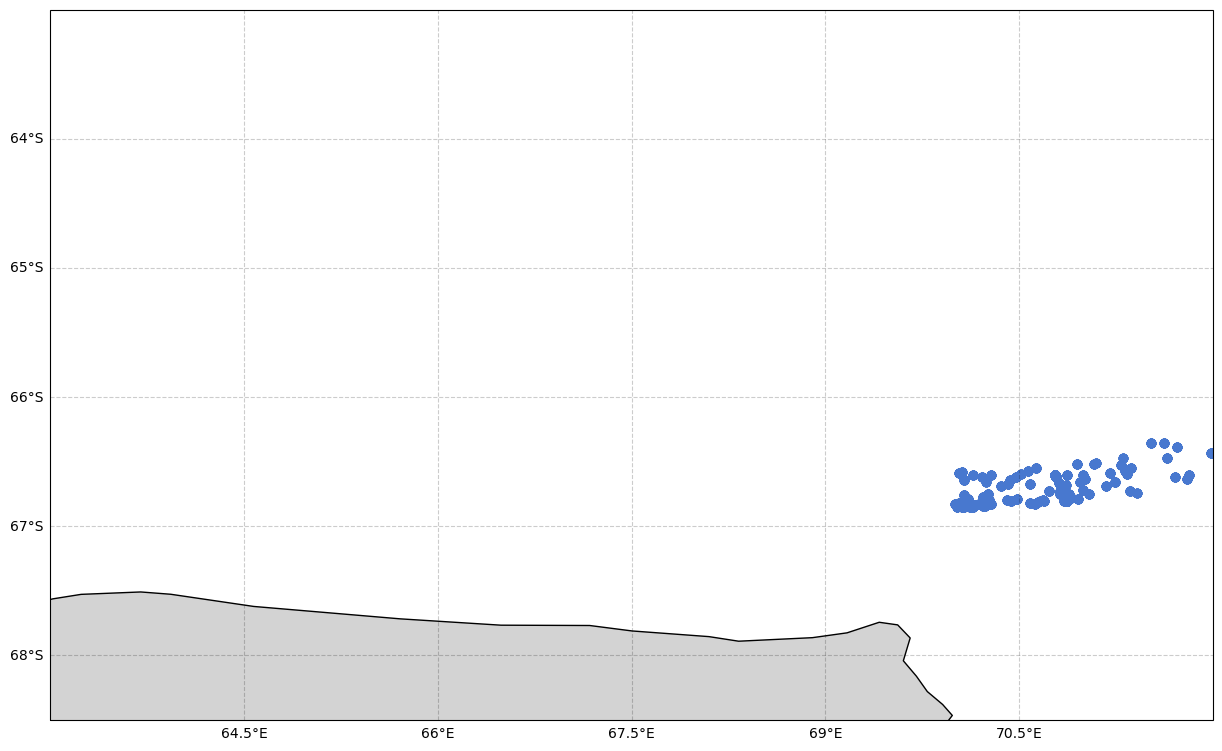

In [220]:
#Check the data has been cropped correctly


# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
#im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

plt.scatter(seals_lon_in_range, seals_lat_in_range)

ax = plt.gca()

plt.show()

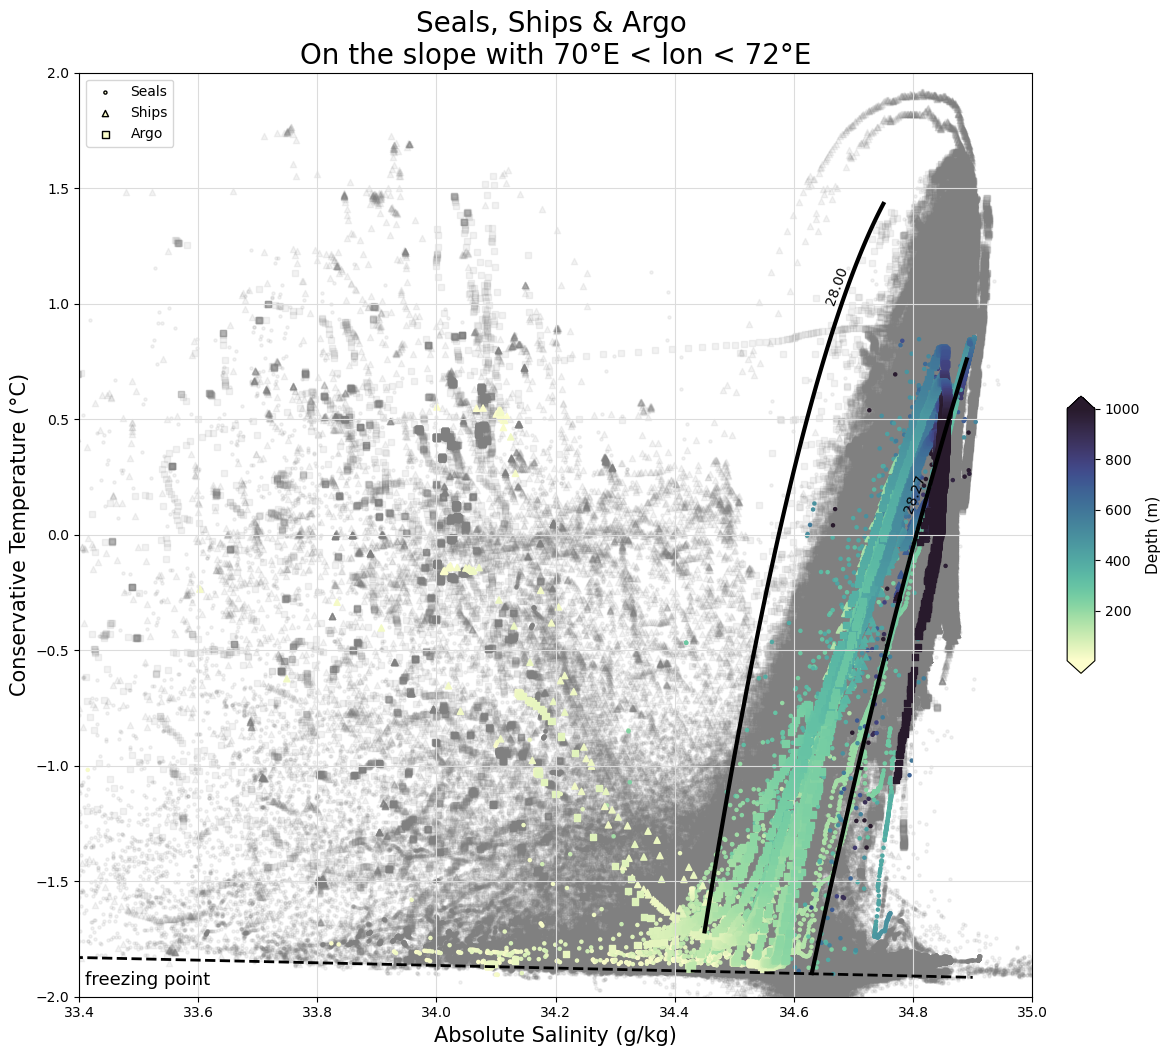

In [221]:
########################################################################################################################
####################################################plotting############################################################
########################################################################################################################


#set the size of the figure
plt.figure(figsize=(15, 12)) 


# Define custom color boundaries
vmin1 = 27
vmax2 = 28
vmax3 = 28.27
vmax4 = 29


# Define colors for different ranges
#colors = [(0.7, 0.7, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
colors = [(0.5, 0.5, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
#colors = [(0.7, 0.7, 0.7), (0, 0, 1), (0.3, 0.3, 0.3)]  # Light blue, blue, dark blue
#cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
cmap_custom = mcolors.ListedColormap(colors)

# Normalize the colormap
norm = mcolors.BoundaryNorm([vmin1, vmax2, vmax3, vmax4], cmap_custom.N)





# # Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter_out_range = plt.scatter(seals_abs_salinity_out_range, seals_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=5, marker='o')

ships_scatter_out_range = plt.scatter(ships_abs_salinity_out_range, ships_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=20, marker='^')

argo_scatter_out_range = plt.scatter(argo_abs_salinity_out_range, argo_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=20, marker='s')


seals_scatter_in_range = plt.scatter(seals_abs_salinity_in_range, seals_cons_temperature_in_range,
                           s=5, c=seals_depth_in_range, cmap=cmap_deep, vmax=1000, marker='o', label='Seals')

ships_scatter_in_range = plt.scatter(ships_abs_salinity_in_range, ships_cons_temperature_in_range,
                           s=20, c=ships_depth_in_range, cmap=cmap_deep, vmax=1000, marker='^', label='Ships')

argo_scatter_in_range = plt.scatter(argo_abs_salinity_in_range, argo_cons_temperature_in_range,
                          s=20, c=argo_depth_in_range, cmap=cmap_deep, vmax=1000, marker='s', label='Argo')





#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'black', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.78,0.1,'28.27', rotation=70, fontsize=10)
plt.text(34.65,1,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.95,'freezing point', fontsize=13, color = 'black')

#Plot the potential density contour lines
# comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Absolute Salinity (g/kg)',  fontsize=15)
plt.ylabel('Conservative Temperature (°C)',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
cbar = plt.colorbar(seals_scatter_in_range, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_custom),orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)
cbar.set_label('Depth (m)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')

#plot the 2 neutral density lines
plt.plot(x_curve1, y_curve1, color='black', linewidth=3, label='Contour Line')
plt.plot(x_curve2, y_curve2, color='black', linewidth=3, label='Contour Line')

# Add a dynamic title
plt.title(f'Seals, Ships & Argo \nOn the slope with {lon_min}°E < lon < {lon_max}°E', fontsize=20)

plt.show()

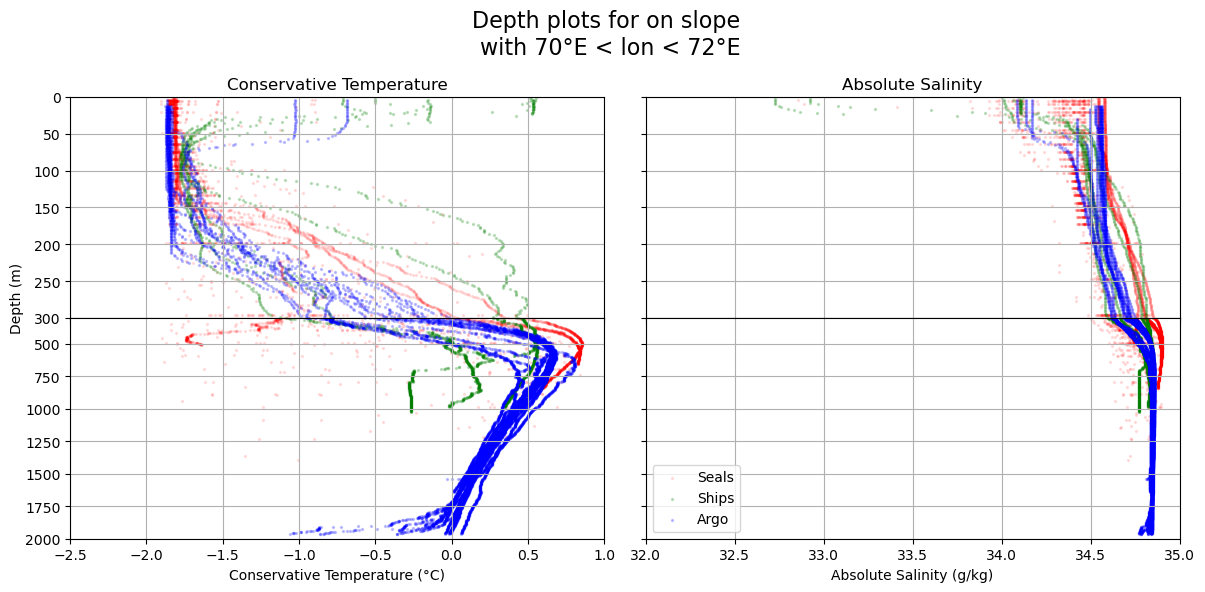

In [222]:
# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))


# Plot Temperature vs. Depth on the top left subplot (ax1)
ax1.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='red', alpha=0.1, s=2, label='Seals')
ax1.scatter(ships_cons_temperature_in_range, ships_depth_in_range, c='green', alpha=0.2, s=2, label='Ships')
ax1.scatter(argo_cons_temperature_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 300)
ax1.set_xlim(-2.5, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom left subplot (ax3)
ax3.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='red', alpha=0.1, s=2, label='Seals')
ax3.scatter(ships_cons_temperature_in_range, ships_depth_in_range, c='green', alpha=0.2, s=2, label='Ships')
ax3.scatter(argo_cons_temperature_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(300, 2000)
ax3.set_xlim(-2.5, 1)
ax3.invert_yaxis()  # Flip the y-axis


# Plot Salinity vs. Depth on the top right subplot (ax2)
ax2.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='red', alpha=0.1, s=2, label='Seals')
ax2.scatter(ships_abs_salinity_in_range, ships_depth_in_range, c='green', alpha=0.2, s=2, label='Ships')
ax2.scatter(argo_abs_salinity_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 300)
ax2.set_xlim(32, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom right subplot (ax4)
ax4.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='red', alpha=0.1, s=2, label='Seals')
ax4.scatter(ships_abs_salinity_in_range, ships_depth_in_range, c='green', alpha=0.2, s=2, label='Ships')
ax4.scatter(argo_abs_salinity_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(300, 2000)
ax4.set_xlim(32, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')



# Add a large title that spans both subplots
fig.suptitle(f'Depth plots for on slope \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

#Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


In [223]:
#calculate mean line 

# Combine the data for both seals and ships
all_depths = np.concatenate((seals_depth_in_range, ships_depth_in_range, argo_depth_in_range))
all_salinity = np.concatenate((seals_abs_salinity_in_range, ships_abs_salinity_in_range, argo_abs_salinity_in_range))
all_temperature = np.concatenate((seals_cons_temperature_in_range, ships_cons_temperature_in_range, argo_cons_temperature_in_range))

# Define depth bins with 10-meter width
depth_bins = np.arange(0, np.max(all_depths) + 25, 25)

# Assign each depth value to a bin
depth_bin_indices = np.digitize(all_depths, depth_bins)

# Calculate the mean or median salinity and temperature for each depth bin
mean_salinity = [np.nanmean(all_salinity[depth_bin_indices == i]) for i in range(1, len(depth_bins)+1)]
mean_temperature = [np.nanmean(all_temperature[depth_bin_indices == i]) for i in range(1, len(depth_bins)+1)]
mean_depths = (depth_bins[depth_bin_indices] + depth_bins[depth_bin_indices-1])*0.5 

/tmp/ipykernel_446986/2414656330.py:15: RuntimeWarning: Mean of empty slice
  mean_salinity = [np.nanmean(all_salinity[depth_bin_indices == i]) for i in range(1, len(depth_bins)+1)]
/tmp/ipykernel_446986/2414656330.py:16: RuntimeWarning: Mean of empty slice
  mean_temperature = [np.nanmean(all_temperature[depth_bin_indices == i]) for i in range(1, len(depth_bins)+1)]


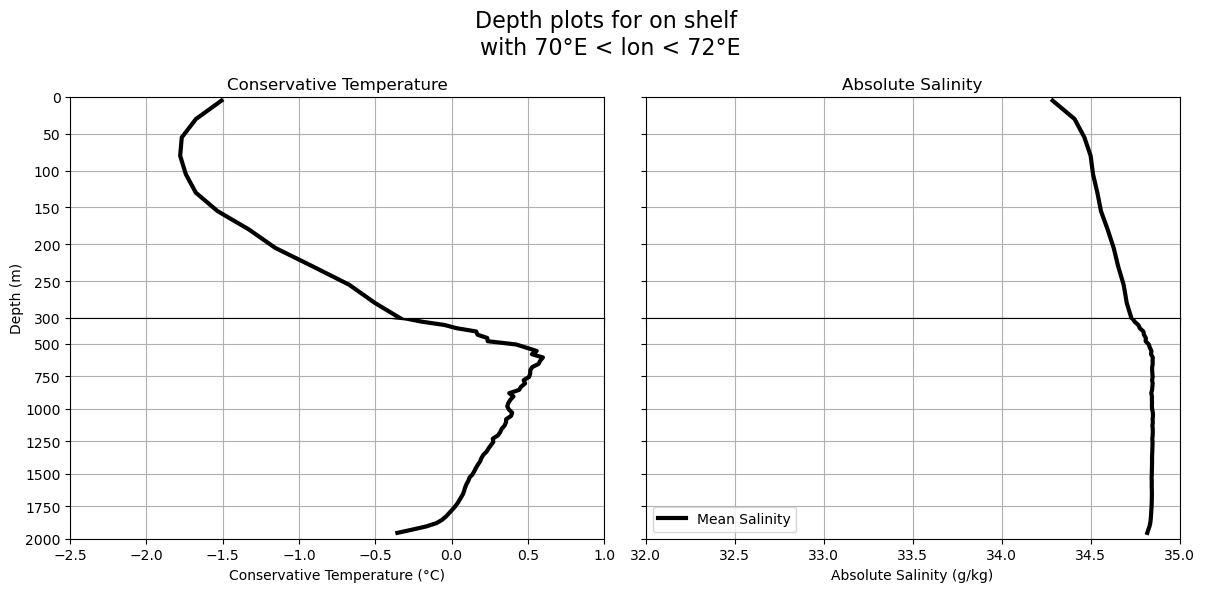

In [224]:
# Visualise mean 


# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))


# Plot Temperature vs. Depth on the top right subplot (ax2)
ax1.plot(mean_temperature, depth_bins+5, label='Mean Temperature', color = 'black', linewidth = 3)
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 300)
ax1.set_xlim(-2.5, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom right subplot (ax4)
ax3.plot(mean_temperature, depth_bins+5, label='Mean Temperature', color = 'black', linewidth = 3)
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(300, 2000)
ax3.set_xlim(-2.5, 1)
ax3.invert_yaxis()  # Flip the y-axis


# Plot Salinity vs. Depth on the top left subplot (ax1)
ax2.plot(mean_salinity, depth_bins+5, label='Mean Salinity', color = 'black', linewidth = 3)
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 300)
ax2.set_xlim(32, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom left subplot (ax3)
ax4.plot(mean_salinity, depth_bins+5, label='Mean Salinity', color = 'black', linewidth = 3)
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(300, 2000)
ax4.set_xlim(32, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')



# Add a large title that spans both subplots
fig.suptitle(f'Depth plots for on shelf \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

#Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


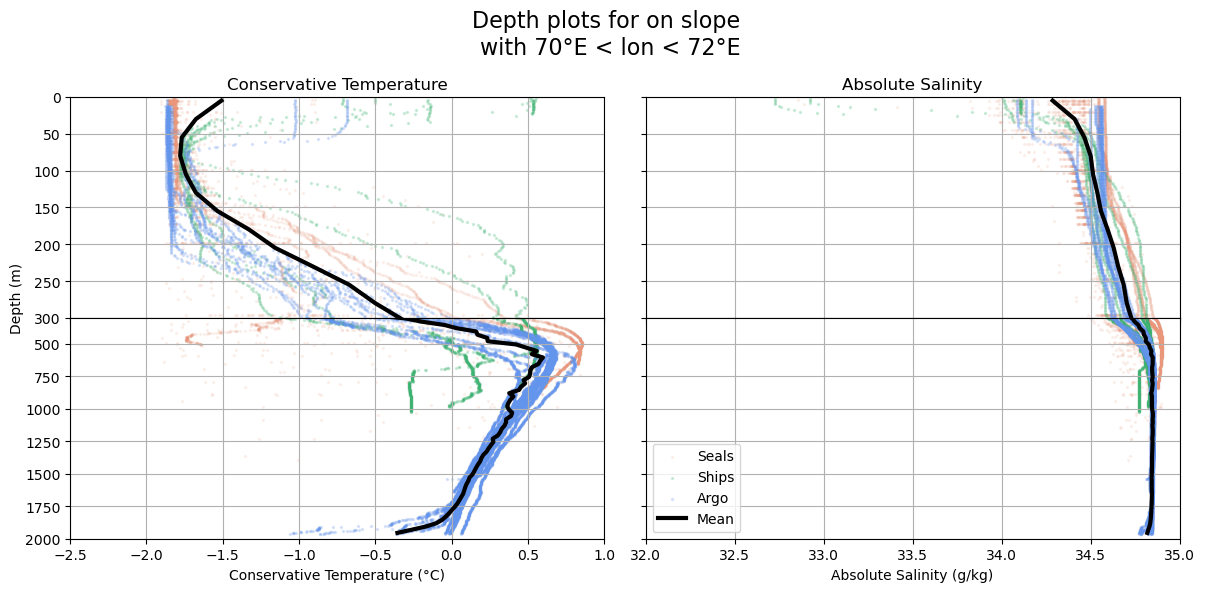

In [225]:
# Combine mean & raw data


# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))


# Plot Temperature vs. Depth on the top left subplot (ax1)
ax1.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='darksalmon', alpha=0.1, s=2, label='Seals')
ax1.scatter(ships_cons_temperature_in_range, ships_depth_in_range, c='mediumseagreen', alpha=0.2, s=2, label='Ships')
ax1.scatter(argo_cons_temperature_in_range, argo_depth_in_range, c='cornflowerblue', alpha=0.2, s=2, label='Argo')
ax1.plot(mean_temperature, depth_bins+5, label='Mean Temperature', color = 'black', linewidth = 3)
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 300)
ax1.set_xlim(-2.5, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom left subplot (ax3)
ax3.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='darksalmon', alpha=0.1, s=2, label='Seals')
ax3.scatter(ships_cons_temperature_in_range, ships_depth_in_range, c='mediumseagreen', alpha=0.2, s=2, label='Ships')
ax3.scatter(argo_cons_temperature_in_range, argo_depth_in_range, c='cornflowerblue', alpha=0.2, s=2, label='Argo')
ax3.plot(mean_temperature, depth_bins+5, label='Mean Temperature', color = 'black', linewidth = 3)
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(300, 2000)
ax3.set_xlim(-2.5, 1)
ax3.invert_yaxis()  # Flip the y-axis


# Plot Salinity vs. Depth on the top right subplot (ax2)
ax2.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='darksalmon', alpha=0.1, s=2, label='Seals')
ax2.scatter(ships_abs_salinity_in_range, ships_depth_in_range, c='mediumseagreen', alpha=0.2, s=2, label='Ships')
ax2.scatter(argo_abs_salinity_in_range, argo_depth_in_range, c='cornflowerblue', alpha=0.2, s=2, label='Argo')
ax2.plot(mean_salinity, depth_bins+5, label='Mean', color = 'black', linewidth = 3)
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 300)
ax2.set_xlim(32, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom right subplot (ax4)
ax4.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='darksalmon', alpha=0.1, s=2, label='Seals')
ax4.scatter(ships_abs_salinity_in_range, ships_depth_in_range, c='mediumseagreen', alpha=0.2, s=2, label='Ships')
ax4.scatter(argo_abs_salinity_in_range, argo_depth_in_range, c='cornflowerblue', alpha=0.2, s=2, label='Argo')
ax4.plot(mean_salinity, depth_bins+5, label='Mean', color = 'black', linewidth = 3)
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(300, 2000)
ax4.set_xlim(32, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')



# Add a large title that spans both subplots
fig.suptitle(f'Depth plots for on slope \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

#Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


In [208]:
# west
average_abs_salinity_slope_west = mean_salinity
average_cons_temperature_slope_west = mean_temperature
average_depth_slope_west = depth_bins+5

In [217]:
# central
average_abs_salinity_slope_central = mean_salinity
average_cons_temperature_slope_central = mean_temperature
average_depth_slope_central = depth_bins+5

In [226]:
# east
average_abs_salinity_slope_east = mean_salinity
average_cons_temperature_slope_east = mean_temperature
average_depth_slope_east = depth_bins+5

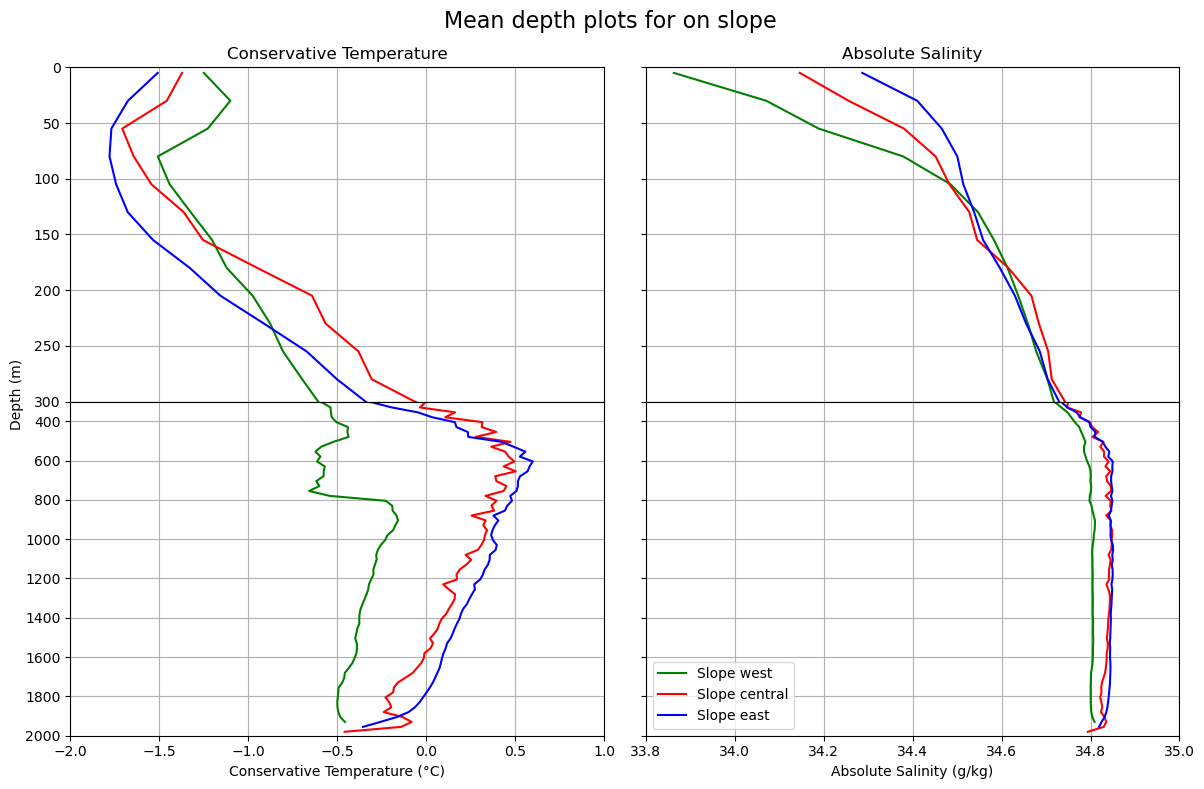

In [274]:
# Combine all means

# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Plot Temperature vs. Depth on the top left subplot (ax1)
ax1.plot(average_cons_temperature_slope_west, average_depth_slope_west, color='green', label='Slope west')
ax1.plot(average_cons_temperature_slope_central, average_depth_slope_central, color='red', label='Slope central')
ax1.plot(average_cons_temperature_slope_east, average_depth_slope_east, color='blue', label='Slope east')
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 300)
ax1.set_xlim(-2, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom left subplot (ax3)
ax3.plot(average_cons_temperature_slope_west, average_depth_slope_west, color='green', label='Slope west')
ax3.plot(average_cons_temperature_slope_central, average_depth_slope_central, color='red', label='Slope central')
ax3.plot(average_cons_temperature_slope_east, average_depth_slope_east, color='blue', label='Slope east')
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(300, 2000)
ax3.set_xlim(-2, 1)
ax3.invert_yaxis()  # Flip the y-axis

# Plot Salinity vs. Depth on the top right subplot (ax2)
ax2.plot(average_abs_salinity_slope_west, average_depth_slope_west, color='green', label='Slope west')
ax2.plot(average_abs_salinity_slope_central, average_depth_slope_central, color='red', label='Slope central')
ax2.plot(average_abs_salinity_slope_east, average_depth_slope_east, color='blue', label='Slope east')
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 300)
ax2.set_xlim(33.8, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom right subplot (ax4)
ax4.plot(average_abs_salinity_slope_west, average_depth_slope_west, color='green', label='Slope west')
ax4.plot(average_abs_salinity_slope_central, average_depth_slope_central, color='red', label='Slope central')
ax4.plot(average_abs_salinity_slope_east, average_depth_slope_east, color='blue', label='Slope east')
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(300, 2000)
ax4.set_xlim(33.8, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')

# Add a large title that spans both subplots
fig.suptitle(f'Mean depth plots for on slope', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


In [ ]:
########################################################################################################
########################################################################################################
####################################### create offshore contour mask ###################################
########################################################################################################
########################################################################################################

In [16]:
# Load in the shelf polygon coordinates from the CSV
polygon_offshore_coords = pd.read_csv('polygon_offshore.csv')

# Create a Shapely Polygon from the coordinates
polygon_offshore = Polygon(zip(polygon_offshore_coords['X'], polygon_offshore_coords['Y']))

# Extract X and Y coordinates
x = polygon_offshore_coords['X'].tolist()
y = polygon_offshore_coords['Y'].tolist()

<Figure size 640x480 with 0 Axes>

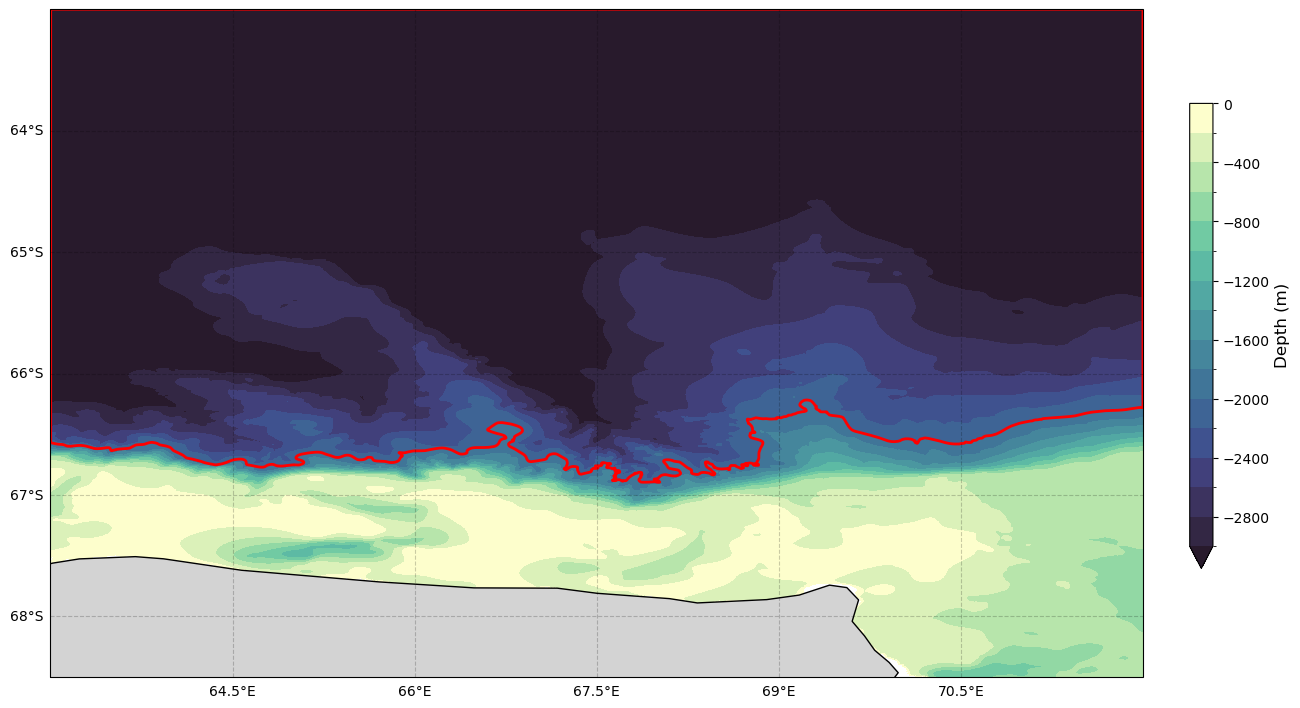

In [231]:
#This plots the polygon on the map to check it works

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Add a contour line for the 600m isobath
##contour_line_coordinates comes from 'CTD mapping seals and CTD with type' notebook. 
#ax.plot(contour_line_coordinates[:, 0], contour_line_coordinates[:, 1], color='white', linewidth=3)

# # Plot the result using Matplotlib
# x, y = polygon.exterior.xy

# Plot the contour polygon
ax.plot(x, y, color='red', linewidth=2)

# Create a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.show()

In [35]:
# #west
# lon_min = 63
# lon_max = 66.5

#central
lon_min = 66.5
lon_max = 70

# #east
# lon_min = 70
# lon_max = 72

In [ ]:
#this crops the data with the offshore polygon and finds data inside, and outside of this polygon
#Choose is you want east, central or west by changing the cell above

In [36]:
################################ SEALS ################################
# Initialize lists to store indices for data within and outside the polygon
seals_indices_in_range = []
seals_indices_out_range = []

# Loop through your data points (assuming latitude and longitude are numpy arrays)
for i in range(len(seals_latitude)):
    latitude = seals_latitude[i]
    longitude = seals_longitude[i]
    point = Point(longitude, latitude)
    
    # # Check if the point is within the polygon (use this if you just want on offshore, slope & offshore)
    # if polygon_offshore.contains(point):
    #     seals_indices_in_range.append(i)
    # else:
    #     seals_indices_out_range.append(i)
    
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_offshore.contains(point) and lon_min <= longitude <= lon_max:
        seals_indices_in_range.append(i)
    else:
        seals_indices_out_range.append(i)

# Convert the index lists to NumPy arrays for indexing
seals_indices_in_range = np.array(seals_indices_in_range)
seals_indices_out_range = np.array(seals_indices_out_range)

# Crop the data based on the indices
seals_cons_temperature_in_range = seals_cons_temperature[seals_indices_in_range]
seals_abs_salinity_in_range = seals_abs_salinity[seals_indices_in_range]
seals_depth_in_range = seals_depth[seals_indices_in_range]
seals_neutral_density_in_range = seals_neutral_density[seals_indices_in_range]
seals_time_in_range = seals_time[seals_indices_in_range]
seals_lat_in_range = seals_latitude[seals_indices_in_range]
seals_lon_in_range = seals_longitude[seals_indices_in_range]

seals_cons_temperature_out_range = seals_cons_temperature[seals_indices_out_range]
seals_abs_salinity_out_range = seals_abs_salinity[seals_indices_out_range]
seals_depth_out_range = seals_depth[seals_indices_out_range]
seals_neutral_density_out_range = seals_neutral_density[seals_indices_out_range]
seals_time_out_range = seals_time[seals_indices_out_range]
seals_lat_out_range = seals_latitude[seals_indices_out_range]
seals_lon_out_range = seals_longitude[seals_indices_out_range]


In [37]:
################################ SHIPS ################################

# Initialize lists to store indices for data within and outside the polygon
ships_indices_in_range = []
ships_indices_out_range = []

for i in range(len(ships_latitude)):
    latitude = ships_latitude[i]
    longitude = ships_longitude[i]
    point = Point(longitude, latitude)
    
    # # Check if the point is within the polygon (use this if you just want on offshore, slope & offshore)
    # if polygon_offshore.contains(point):
    #     ships_indices_in_range.append(i)
    # else:
    #     ships_indices_out_range.append(i)
    
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_offshore.contains(point) and lon_min <= longitude <= lon_max:
        ships_indices_in_range.append(i)
    else:
        ships_indices_out_range.append(i)

# Convert the index lists to NumPy arrays for indexing
ships_indices_in_range = np.array(ships_indices_in_range)
ships_indices_out_range = np.array(ships_indices_out_range)

# Crop the data based on the indices
ships_cons_temperature_in_range = ships_cons_temperature[ships_indices_in_range]
ships_abs_salinity_in_range = ships_abs_salinity[ships_indices_in_range]
ships_depth_in_range = ships_depth[ships_indices_in_range]
ships_neutral_density_in_range = ships_neutral_density[ships_indices_in_range]
ships_time_in_range = ships_time[ships_indices_in_range]
ships_lat_in_range = ships_latitude[ships_indices_in_range]
ships_lon_in_range = ships_longitude[ships_indices_in_range]

ships_cons_temperature_out_range = ships_cons_temperature[ships_indices_out_range]
ships_abs_salinity_out_range = ships_abs_salinity[ships_indices_out_range]
ships_depth_out_range = ships_depth[ships_indices_out_range]
ships_neutral_density_out_range = ships_neutral_density[ships_indices_out_range]
ships_time_out_range = ships_time[ships_indices_out_range]
ships_lat_out_range = ships_latitude[ships_indices_out_range]
ships_lon_out_range = ships_longitude[ships_indices_out_range]

In [38]:
################################ ARGO ################################

# Initialize lists to store indices for data within and outside the polygon
argo_indices_in_range = []
argo_indices_out_range = []

for i in range(len(argo_latitude)):
    latitude = argo_latitude[i]
    longitude = argo_longitude[i]
    point = Point(longitude, latitude)
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_offshore.contains(point) and lon_min <= longitude <= lon_max:
        argo_indices_in_range.append(i)
    else:
        argo_indices_out_range.append(i)

# Convert the index lists to NumPy arrays for indexing
argo_indices_in_range = np.array(argo_indices_in_range)
argo_indices_out_range = np.array(argo_indices_out_range)

# Crop the data based on the indices
argo_cons_temperature_in_range = argo_cons_temperature[argo_indices_in_range]
argo_abs_salinity_in_range = argo_abs_salinity[argo_indices_in_range]
argo_depth_in_range = argo_depth[argo_indices_in_range]
argo_neutral_density_in_range = argo_neutral_density[argo_indices_in_range]
argo_time_in_range = argo_time[argo_indices_in_range]
argo_lat_in_range = argo_latitude[argo_indices_in_range]
argo_lon_in_range = argo_longitude[argo_indices_in_range]

argo_cons_temperature_out_range = argo_cons_temperature[argo_indices_out_range]
argo_abs_salinity_out_range = argo_abs_salinity[argo_indices_out_range]
argo_depth_out_range = argo_depth[argo_indices_out_range]
argo_neutral_density_out_range = argo_neutral_density[argo_indices_out_range]
argo_time_out_range = argo_time[argo_indices_out_range]
argo_lat_out_range = argo_latitude[argo_indices_out_range]
argo_lon_out_range = argo_longitude[argo_indices_out_range]


In [34]:
# export offshore west

# Create a dictionary to store the values
data = {
    "seals_cons_temperature_in_range": seals_cons_temperature_in_range,
    "seals_abs_salinity_in_range": seals_abs_salinity_in_range,
    "seals_depth_in_range": seals_depth_in_range,
    "seals_neutral_density_in_range": seals_neutral_density_in_range,
    "seals_time_in_range": seals_time_in_range,
    "seals_lat_in_range": seals_lat_in_range,
    "seals_lon_in_range": seals_lon_in_range,
    "seals_cons_temperature_out_range": seals_cons_temperature_out_range,
    "seals_abs_salinity_out_range": seals_abs_salinity_out_range,
    "seals_depth_out_range": seals_depth_out_range,
    "seals_neutral_density_out_range": seals_neutral_density_out_range,
    "seals_time_out_range": seals_time_out_range,
    "seals_lat_out_range": seals_lat_out_range,
    "seals_lon_out_range": seals_lon_out_range,
    "ships_cons_temperature_in_range": ships_cons_temperature_in_range,
    "ships_abs_salinity_in_range": ships_abs_salinity_in_range,
    "ships_depth_in_range": ships_depth_in_range,
    "ships_neutral_density_in_range": ships_neutral_density_in_range,
    "ships_time_in_range": ships_time_in_range,
    "ships_lat_in_range": ships_lat_in_range,
    "ships_lon_in_range": ships_lon_in_range,
    "ships_cons_temperature_out_range": ships_cons_temperature_out_range,
    "ships_abs_salinity_out_range": ships_abs_salinity_out_range,
    "ships_depth_out_range": ships_depth_out_range,
    "ships_neutral_density_out_range": ships_neutral_density_out_range,
    "ships_time_out_range": ships_time_out_range,
    "ships_lat_out_range": ships_lat_out_range,
    "ships_lon_out_range": ships_lon_out_range,
    "argo_cons_temperature_in_range": argo_cons_temperature_in_range,
    "argo_abs_salinity_in_range": argo_abs_salinity_in_range,
    "argo_depth_in_range": argo_depth_in_range,
    "argo_neutral_density_in_range": argo_neutral_density_in_range,
    "argo_time_in_range": argo_time_in_range,
    "argo_lat_in_range": argo_lat_in_range,
    "argo_lon_in_range": argo_lon_in_range,
    "argo_cons_temperature_out_range": argo_cons_temperature_out_range,
    "argo_abs_salinity_out_range": argo_abs_salinity_out_range,
    "argo_depth_out_range": argo_depth_out_range,
    "argo_neutral_density_out_range": argo_neutral_density_out_range,
    "argo_time_out_range": argo_time_out_range,
    "argo_lat_out_range": argo_lat_out_range
}


# Save the data to a file using pickle
with open('offshore_west_seals_ships_argo_data.pkl', 'wb') as file:
    pickle.dump(data, file)

In [39]:
# export offshore central

# Create a dictionary to store the values
data = {
    "seals_cons_temperature_in_range": seals_cons_temperature_in_range,
    "seals_abs_salinity_in_range": seals_abs_salinity_in_range,
    "seals_depth_in_range": seals_depth_in_range,
    "seals_neutral_density_in_range": seals_neutral_density_in_range,
    "seals_time_in_range": seals_time_in_range,
    "seals_lat_in_range": seals_lat_in_range,
    "seals_lon_in_range": seals_lon_in_range,
    "seals_cons_temperature_out_range": seals_cons_temperature_out_range,
    "seals_abs_salinity_out_range": seals_abs_salinity_out_range,
    "seals_depth_out_range": seals_depth_out_range,
    "seals_neutral_density_out_range": seals_neutral_density_out_range,
    "seals_time_out_range": seals_time_out_range,
    "seals_lat_out_range": seals_lat_out_range,
    "seals_lon_out_range": seals_lon_out_range,
    "ships_cons_temperature_in_range": ships_cons_temperature_in_range,
    "ships_abs_salinity_in_range": ships_abs_salinity_in_range,
    "ships_depth_in_range": ships_depth_in_range,
    "ships_neutral_density_in_range": ships_neutral_density_in_range,
    "ships_time_in_range": ships_time_in_range,
    "ships_lat_in_range": ships_lat_in_range,
    "ships_lon_in_range": ships_lon_in_range,
    "ships_cons_temperature_out_range": ships_cons_temperature_out_range,
    "ships_abs_salinity_out_range": ships_abs_salinity_out_range,
    "ships_depth_out_range": ships_depth_out_range,
    "ships_neutral_density_out_range": ships_neutral_density_out_range,
    "ships_time_out_range": ships_time_out_range,
    "ships_lat_out_range": ships_lat_out_range,
    "ships_lon_out_range": ships_lon_out_range,
    "argo_cons_temperature_in_range": argo_cons_temperature_in_range,
    "argo_abs_salinity_in_range": argo_abs_salinity_in_range,
    "argo_depth_in_range": argo_depth_in_range,
    "argo_neutral_density_in_range": argo_neutral_density_in_range,
    "argo_time_in_range": argo_time_in_range,
    "argo_lat_in_range": argo_lat_in_range,
    "argo_lon_in_range": argo_lon_in_range,
    "argo_cons_temperature_out_range": argo_cons_temperature_out_range,
    "argo_abs_salinity_out_range": argo_abs_salinity_out_range,
    "argo_depth_out_range": argo_depth_out_range,
    "argo_neutral_density_out_range": argo_neutral_density_out_range,
    "argo_time_out_range": argo_time_out_range,
    "argo_lat_out_range": argo_lat_out_range
}


# Save the data to a file using pickle
with open('offshore_central_seals_ships_argo_data.pkl', 'wb') as file:
    pickle.dump(data, file)

In [25]:
# export offshore east

# Create a dictionary to store the values
data = {
    "seals_cons_temperature_in_range": seals_cons_temperature_in_range,
    "seals_abs_salinity_in_range": seals_abs_salinity_in_range,
    "seals_depth_in_range": seals_depth_in_range,
    "seals_neutral_density_in_range": seals_neutral_density_in_range,
    "seals_time_in_range": seals_time_in_range,
    "seals_lat_in_range": seals_lat_in_range,
    "seals_lon_in_range": seals_lon_in_range,
    "seals_cons_temperature_out_range": seals_cons_temperature_out_range,
    "seals_abs_salinity_out_range": seals_abs_salinity_out_range,
    "seals_depth_out_range": seals_depth_out_range,
    "seals_neutral_density_out_range": seals_neutral_density_out_range,
    "seals_time_out_range": seals_time_out_range,
    "seals_lat_out_range": seals_lat_out_range,
    "seals_lon_out_range": seals_lon_out_range,
    "ships_cons_temperature_in_range": ships_cons_temperature_in_range,
    "ships_abs_salinity_in_range": ships_abs_salinity_in_range,
    "ships_depth_in_range": ships_depth_in_range,
    "ships_neutral_density_in_range": ships_neutral_density_in_range,
    "ships_time_in_range": ships_time_in_range,
    "ships_lat_in_range": ships_lat_in_range,
    "ships_lon_in_range": ships_lon_in_range,
    "ships_cons_temperature_out_range": ships_cons_temperature_out_range,
    "ships_abs_salinity_out_range": ships_abs_salinity_out_range,
    "ships_depth_out_range": ships_depth_out_range,
    "ships_neutral_density_out_range": ships_neutral_density_out_range,
    "ships_time_out_range": ships_time_out_range,
    "ships_lat_out_range": ships_lat_out_range,
    "ships_lon_out_range": ships_lon_out_range,
    "argo_cons_temperature_in_range": argo_cons_temperature_in_range,
    "argo_abs_salinity_in_range": argo_abs_salinity_in_range,
    "argo_depth_in_range": argo_depth_in_range,
    "argo_neutral_density_in_range": argo_neutral_density_in_range,
    "argo_time_in_range": argo_time_in_range,
    "argo_lat_in_range": argo_lat_in_range,
    "argo_lon_in_range": argo_lon_in_range,
    "argo_cons_temperature_out_range": argo_cons_temperature_out_range,
    "argo_abs_salinity_out_range": argo_abs_salinity_out_range,
    "argo_depth_out_range": argo_depth_out_range,
    "argo_neutral_density_out_range": argo_neutral_density_out_range,
    "argo_time_out_range": argo_time_out_range,
    "argo_lat_out_range": argo_lat_out_range
}


# Save the data to a file using pickle
with open('offshore_east_seals_ships_argo_data.pkl', 'wb') as file:
    pickle.dump(data, file)

In [17]:
# Load offshore west data
with open('offshore_west_seals_ships_argo_data.pkl', 'rb') as file:
    data = pickle.load(file)

#west
lon_min = 63
lon_max = 66.5

In [255]:
# Load offshore central data
with open('offshore_central_seals_ships_argo_data.pkl', 'rb') as file:
    data = pickle.load(file)

#central
lon_min = 66.5
lon_max = 70

In [264]:
# Load offshore east data
with open('offshore_east_seals_ships_argo_data.pkl', 'rb') as file:
    data = pickle.load(file)

#east
lon_min = 70
lon_max = 72

In [18]:
## access the variables

# Seals data
seals_cons_temperature_in_range = data["seals_cons_temperature_in_range"]
seals_abs_salinity_in_range = data["seals_abs_salinity_in_range"]
seals_depth_in_range = data["seals_depth_in_range"]
seals_neutral_density_in_range = data["seals_neutral_density_in_range"]
seals_time_in_range = data["seals_time_in_range"]
seals_lat_in_range = data["seals_lat_in_range"]
seals_lon_in_range = data["seals_lon_in_range"]
seals_cons_temperature_out_range = data["seals_cons_temperature_out_range"]
seals_abs_salinity_out_range = data["seals_abs_salinity_out_range"]
seals_depth_out_range = data["seals_depth_out_range"]
seals_neutral_density_out_range = data["seals_neutral_density_out_range"]
seals_time_out_range = data["seals_time_out_range"]
seals_lat_out_range = data["seals_lat_out_range"]
seals_lon_out_range = data["seals_lon_out_range"]

# Ships data
ships_cons_temperature_in_range = data["ships_cons_temperature_in_range"]
ships_abs_salinity_in_range = data["ships_abs_salinity_in_range"]
ships_depth_in_range = data["ships_depth_in_range"]
ships_neutral_density_in_range = data["ships_neutral_density_in_range"]
ships_time_in_range = data["ships_time_in_range"]
ships_lat_in_range = data["ships_lat_in_range"]
ships_lon_in_range = data["ships_lon_in_range"]
ships_cons_temperature_out_range = data["ships_cons_temperature_out_range"]
ships_abs_salinity_out_range = data["ships_abs_salinity_out_range"]
ships_depth_out_range = data["ships_depth_out_range"]
ships_neutral_density_out_range = data["ships_neutral_density_out_range"]
ships_time_out_range = data["ships_time_out_range"]
ships_lat_out_range = data["ships_lat_out_range"]
ships_lon_out_range = data["ships_lon_out_range"]

# Argo data
argo_cons_temperature_in_range = data["argo_cons_temperature_in_range"]
argo_abs_salinity_in_range = data["argo_abs_salinity_in_range"]
argo_depth_in_range = data["argo_depth_in_range"]
argo_neutral_density_in_range = data["argo_neutral_density_in_range"]
argo_time_in_range = data["argo_time_in_range"]
argo_lat_in_range = data["argo_lat_in_range"]
argo_lon_in_range = data["argo_lon_in_range"]
argo_cons_temperature_out_range = data["argo_cons_temperature_out_range"]
argo_abs_salinity_out_range = data["argo_abs_salinity_out_range"]
argo_depth_out_range = data["argo_depth_out_range"]
argo_neutral_density_out_range = data["argo_neutral_density_out_range"]
argo_time_out_range = data["argo_time_out_range"]
argo_lat_out_range = data["argo_lat_out_range"]

<Figure size 640x480 with 0 Axes>

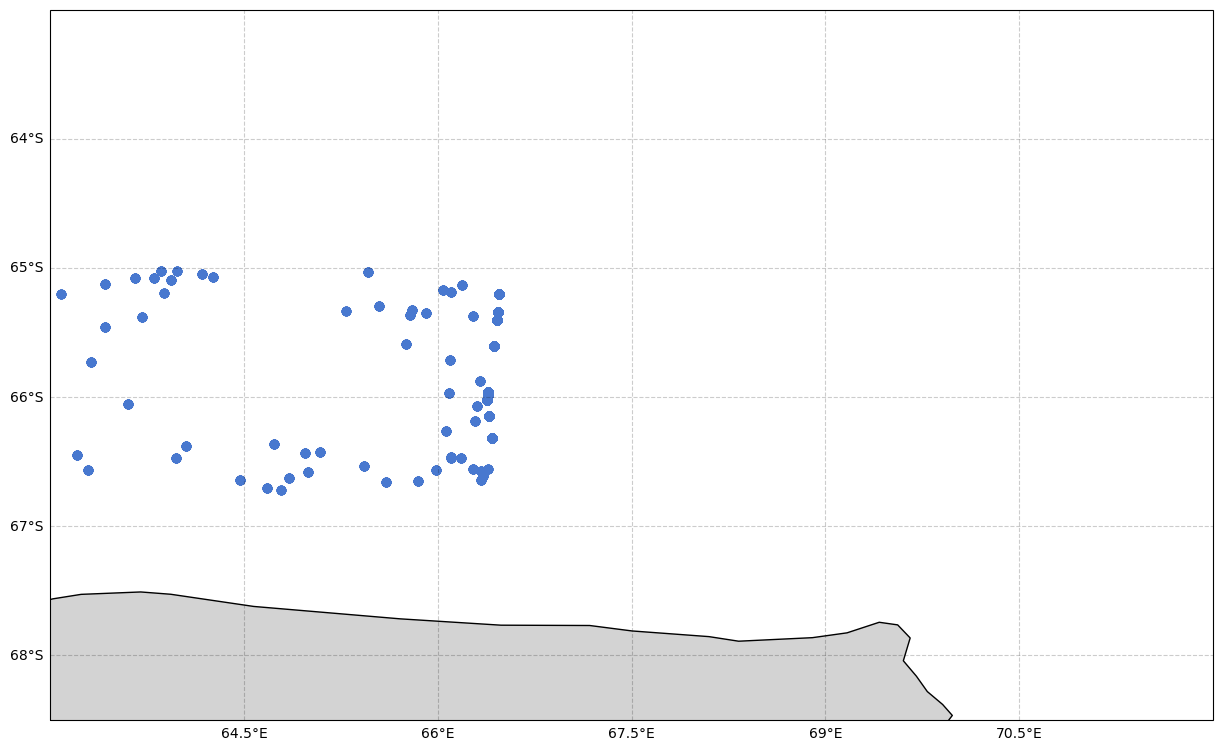

In [19]:
#Check the data has been cropped correctly


# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
#im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

plt.scatter(seals_lon_in_range, seals_lat_in_range)

ax = plt.gca()

plt.show()

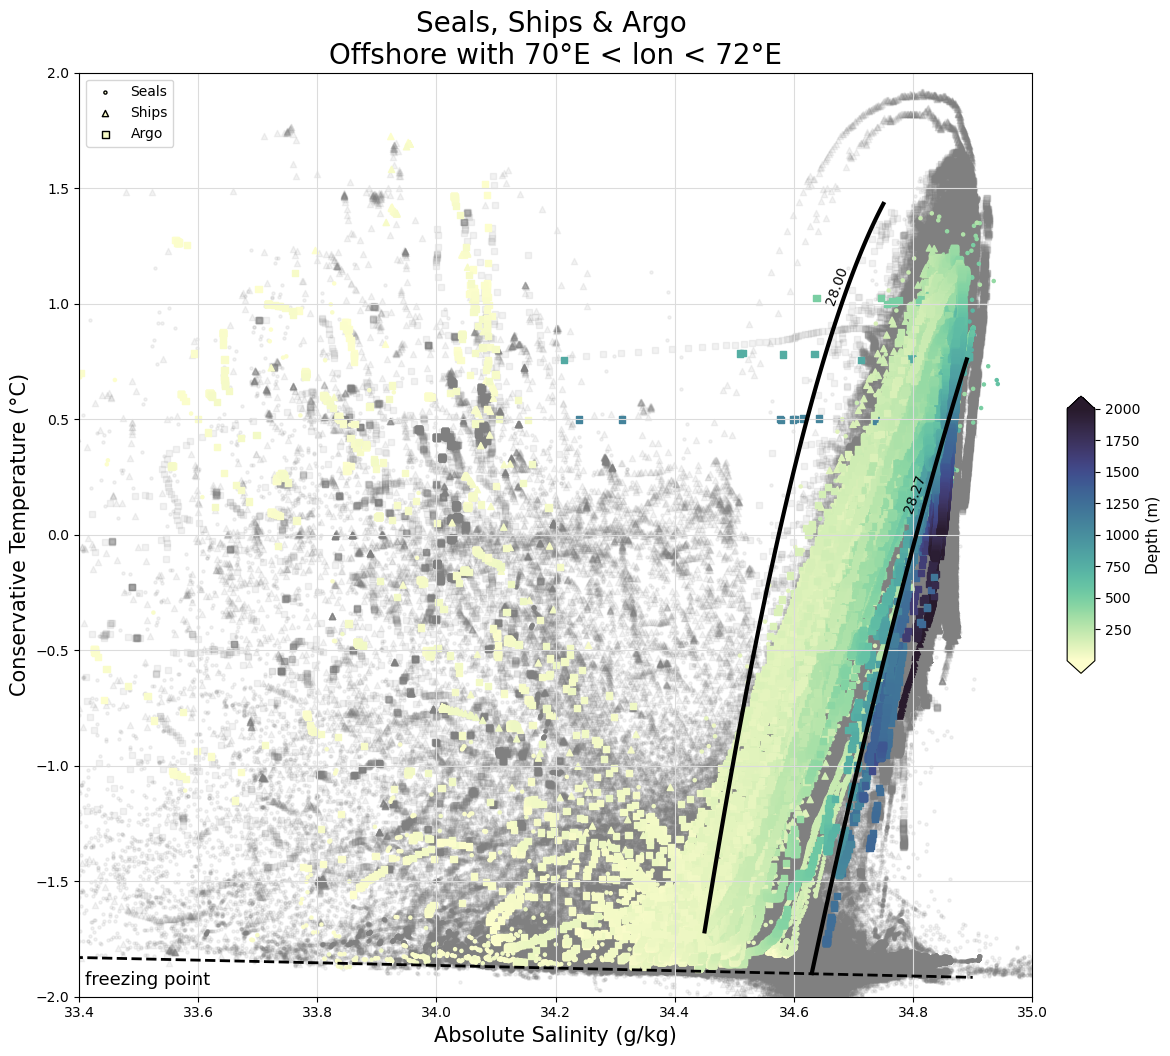

In [267]:
########################################################################################################################
####################################################plotting############################################################
########################################################################################################################


#set the size of the figure
plt.figure(figsize=(15, 12)) 


# Define custom color boundaries
vmin1 = 27
vmax2 = 28
vmax3 = 28.27
vmax4 = 29


# Define colors for different ranges
#colors = [(0.7, 0.7, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
colors = [(0.5, 0.5, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
#colors = [(0.7, 0.7, 0.7), (0, 0, 1), (0.3, 0.3, 0.3)]  # Light blue, blue, dark blue
#cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
cmap_custom = mcolors.ListedColormap(colors)

# Normalize the colormap
norm = mcolors.BoundaryNorm([vmin1, vmax2, vmax3, vmax4], cmap_custom.N)





# # Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter_out_range = plt.scatter(seals_abs_salinity_out_range, seals_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=5, marker='o')

ships_scatter_out_range = plt.scatter(ships_abs_salinity_out_range, ships_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=20, marker='^')

argo_scatter_out_range = plt.scatter(argo_abs_salinity_out_range, argo_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=20, marker='s')


seals_scatter_in_range = plt.scatter(seals_abs_salinity_in_range, seals_cons_temperature_in_range,
                           s=5, c=seals_depth_in_range, cmap=cmap_deep, vmax=2000, marker='o', label='Seals')

ships_scatter_in_range = plt.scatter(ships_abs_salinity_in_range, ships_cons_temperature_in_range,
                           s=20, c=ships_depth_in_range, cmap=cmap_deep, vmax=2000, marker='^', label='Ships')

argo_scatter_in_range = plt.scatter(argo_abs_salinity_in_range, argo_cons_temperature_in_range,
                          s=20, c=argo_depth_in_range, cmap=cmap_deep, vmax=2000, marker='s', label='Argo')





#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'black', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.78,0.1,'28.27', rotation=70, fontsize=10)
plt.text(34.65,1,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.95,'freezing point', fontsize=13, color = 'black')

#Plot the potential density contour lines
# comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Absolute Salinity (g/kg)',  fontsize=15)
plt.ylabel('Conservative Temperature (°C)',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
cbar = plt.colorbar(seals_scatter_in_range, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_custom),orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)
cbar.set_label('Depth (m)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')

#plot the 2 neutral density lines
plt.plot(x_curve1, y_curve1, color='black', linewidth=3, label='Contour Line')
plt.plot(x_curve2, y_curve2, color='black', linewidth=3, label='Contour Line')

# Add a dynamic title
plt.title(f'Seals, Ships & Argo \nOffshore with {lon_min}°E < lon < {lon_max}°E', fontsize=20)

plt.show()

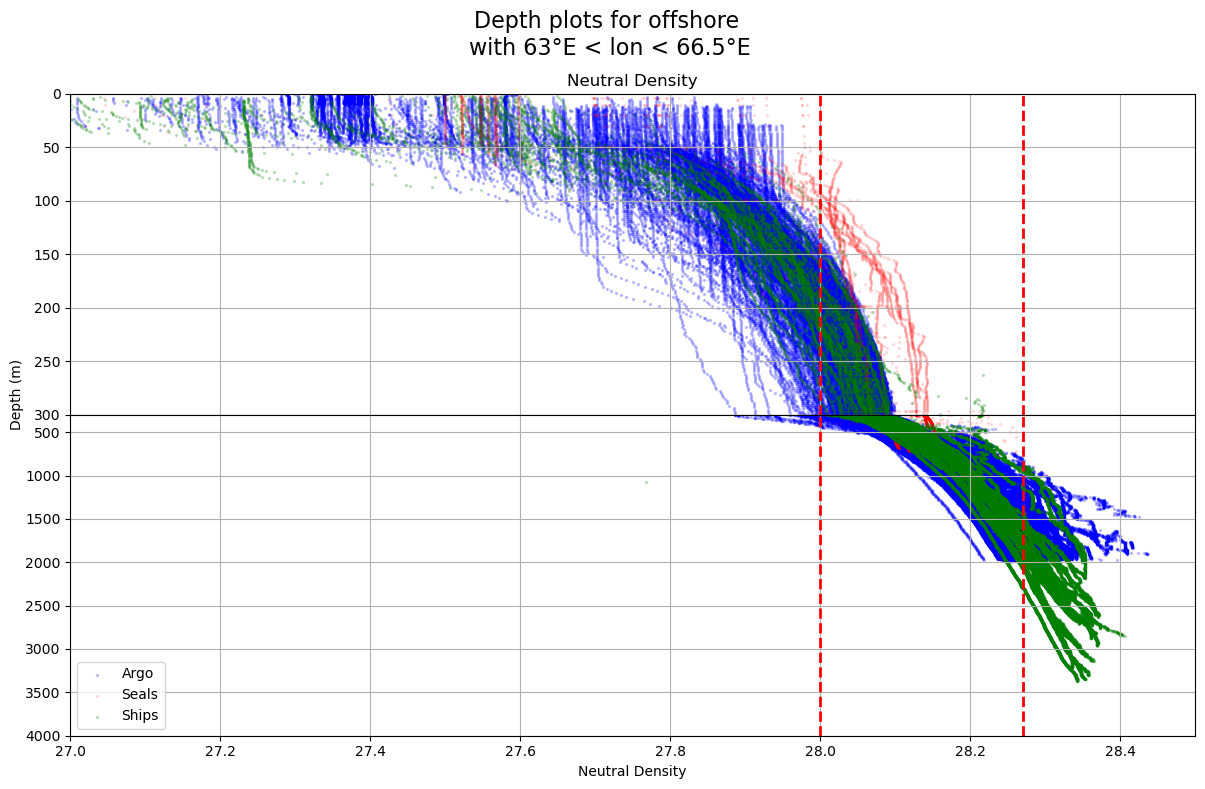

In [24]:
# Combine the data for both seals and ships
all_depths = np.concatenate((seals_depth_in_range, ships_depth_in_range, argo_depth_in_range))
all_density = np.concatenate((seals_neutral_density_in_range, ships_neutral_density_in_range, argo_neutral_density_in_range))

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot Neutral Density vs. Depth on the top left subplot (ax1)
ax1.scatter(argo_neutral_density_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax1.scatter(seals_neutral_density_in_range, seals_depth_in_range, c='red', alpha=0.1, s=2, label='Seals')
ax1.scatter(ships_neutral_density_in_range, ships_depth_in_range, c='green', alpha=0.2, s=2, label='Ships')
ax1.set_title('Neutral Density')
ax1.grid(True)
ax1.set_ylim(0, 300)
ax1.set_xlim(27, 28.5)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Neutral Density vs. Depth on the bottom left subplot (ax2)
ax2.scatter(argo_neutral_density_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax2.scatter(seals_neutral_density_in_range, seals_depth_in_range, c='red', alpha=0.1, s=2, label='Seals')
ax2.scatter(ships_neutral_density_in_range, ships_depth_in_range, c='green', alpha=0.2, s=2, label='Ships')
ax2.set_xlabel('Neutral Density')
ax2.grid(True)
ax2.set_ylim(300, 4000)
ax2.set_xlim(27, 28.5)
ax2.invert_yaxis()  # Flip the y-axis
ax2.legend(loc='lower left')


# Add vertical lines to both subplots
ax1.axvline(x=28, color='red', linestyle='--', linewidth=2)
ax1.axvline(x=28.27, color='red', linestyle='--', linewidth=2)

ax2.axvline(x=28, color='red', linestyle='--', linewidth=2)
ax2.axvline(x=28.27, color='red', linestyle='--', linewidth=2)



# Add a large title that spans both subplots
fig.suptitle(f'Depth plots for offshore \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


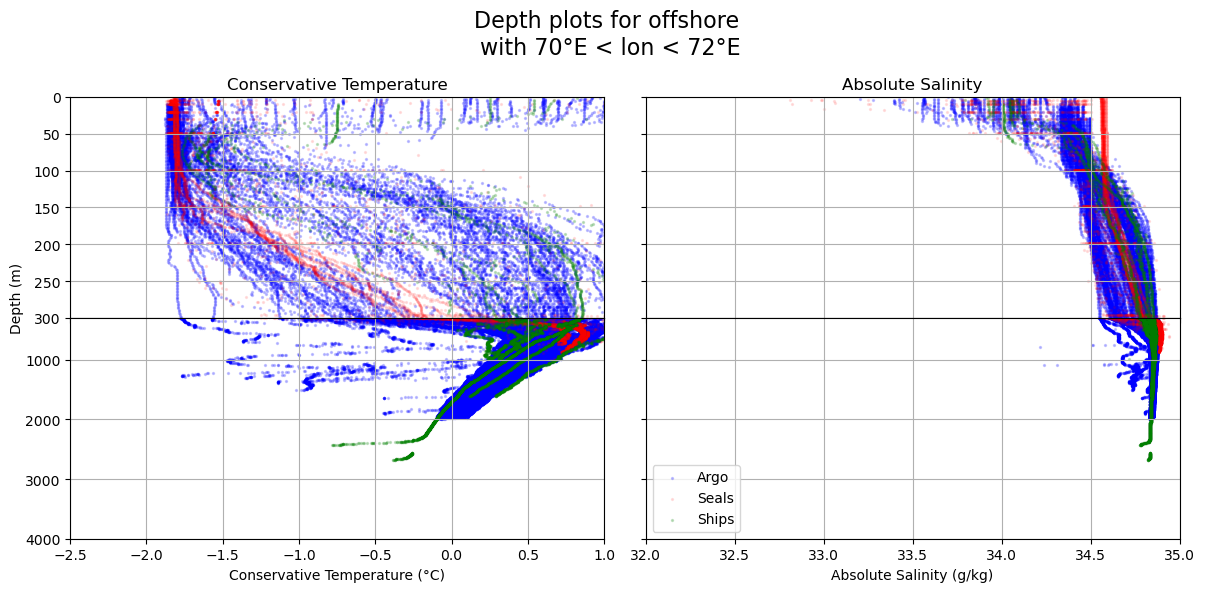

In [268]:
# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))


# Plot Temperature vs. Depth on the top left subplot (ax1)
ax1.scatter(argo_cons_temperature_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax1.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='red', alpha=0.1, s=2, label='Seals')
ax1.scatter(ships_cons_temperature_in_range, ships_depth_in_range, c='green', alpha=0.2, s=2, label='Ships')
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 300)
ax1.set_xlim(-2.5, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom left subplot (ax3)
ax3.scatter(argo_cons_temperature_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax3.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='red', alpha=0.1, s=2, label='Seals')
ax3.scatter(ships_cons_temperature_in_range, ships_depth_in_range, c='green', alpha=0.2, s=2, label='Ships')
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(300, 4000)
ax3.set_xlim(-2.5, 1)
ax3.invert_yaxis()  # Flip the y-axis


# Plot Salinity vs. Depth on the top right subplot (ax2)
ax2.scatter(argo_abs_salinity_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax2.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='red', alpha=0.1, s=2, label='Seals')
ax2.scatter(ships_abs_salinity_in_range, ships_depth_in_range, c='green', alpha=0.2, s=2, label='Ships')
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 300)
ax2.set_xlim(32, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom right subplot (ax4)
ax4.scatter(argo_abs_salinity_in_range, argo_depth_in_range, c='blue', alpha=0.2, s=2, label='Argo')
ax4.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='red', alpha=0.1, s=2, label='Seals')
ax4.scatter(ships_abs_salinity_in_range, ships_depth_in_range, c='green', alpha=0.2, s=2, label='Ships')
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(300, 4000)
ax4.set_xlim(32, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')



# Add a large title that spans both subplots
fig.suptitle(f'Depth plots for offshore \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

#Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


In [269]:
#calculate mean line 

# Combine the data for both seals and ships
all_depths = np.concatenate((seals_depth_in_range, ships_depth_in_range, argo_depth_in_range))
all_salinity = np.concatenate((seals_abs_salinity_in_range, ships_abs_salinity_in_range, argo_abs_salinity_in_range))
all_temperature = np.concatenate((seals_cons_temperature_in_range, ships_cons_temperature_in_range, argo_cons_temperature_in_range))

# Find the maximum depth value in your data
max_depth = np.nanmax(all_depths)

# Define depth bins with a 10-meter width up to the maximum depth
depth_bins = np.arange(0, max_depth + 25, 25)


# Assign each depth value to a bin
depth_bin_indices = np.digitize(all_depths, depth_bins)

# Calculate the mean or median salinity and temperature for each depth bin
mean_salinity = [np.nanmean(all_salinity[depth_bin_indices == i]) for i in range(1, len(depth_bins)+1)]
mean_temperature = [np.nanmean(all_temperature[depth_bin_indices == i]) for i in range(1, len(depth_bins)+1)]
#mean_depths = (depth_bins[depth_bin_indices] + depth_bins[depth_bin_indices-1])*0.5 

/tmp/ipykernel_446986/40195977.py:19: RuntimeWarning: Mean of empty slice
  mean_salinity = [np.nanmean(all_salinity[depth_bin_indices == i]) for i in range(1, len(depth_bins)+1)]
/tmp/ipykernel_446986/40195977.py:20: RuntimeWarning: Mean of empty slice
  mean_temperature = [np.nanmean(all_temperature[depth_bin_indices == i]) for i in range(1, len(depth_bins)+1)]


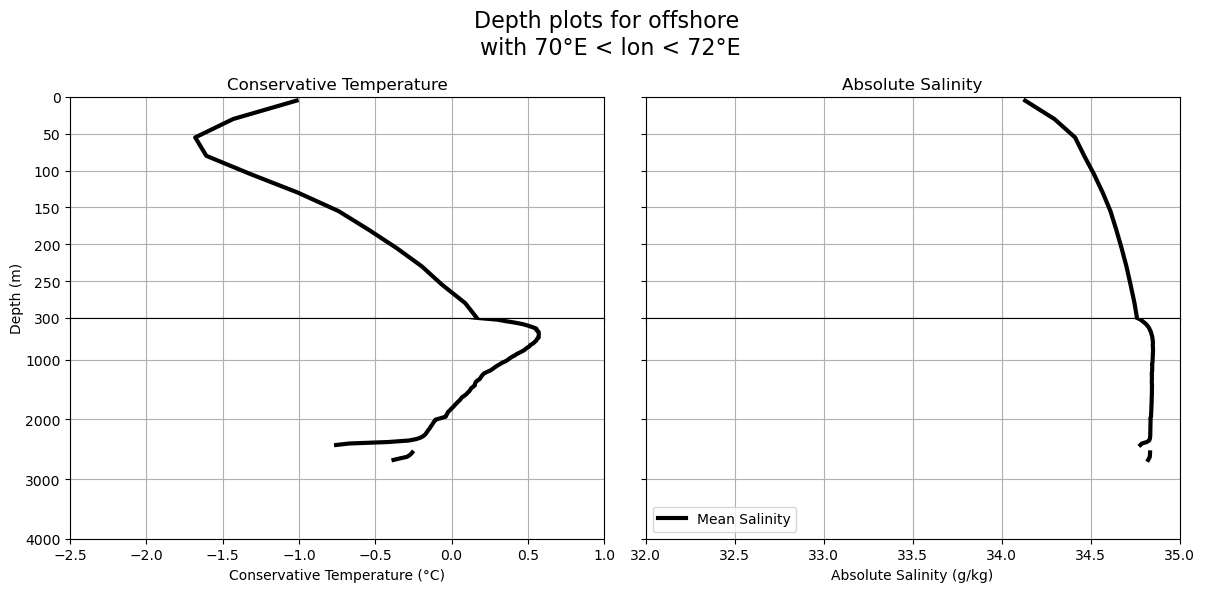

In [270]:
# Visualise mean 


# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))


# Plot Temperature vs. Depth on the top right subplot (ax2)
ax1.plot(mean_temperature, depth_bins+5, label='Mean Temperature', color = 'black', linewidth = 3)
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 300)
ax1.set_xlim(-2.5, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom right subplot (ax4)
ax3.plot(mean_temperature, depth_bins+5, label='Mean Temperature', color = 'black', linewidth = 3)
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(300, 4000)
ax3.set_xlim(-2.5, 1)
ax3.invert_yaxis()  # Flip the y-axis


# Plot Salinity vs. Depth on the top left subplot (ax1)
ax2.plot(mean_salinity, depth_bins+5, label='Mean Salinity', color = 'black', linewidth = 3)
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 300)
ax2.set_xlim(32, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom left subplot (ax3)
ax4.plot(mean_salinity, depth_bins+5, label='Mean Salinity', color = 'black', linewidth = 3)
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(300, 4000)
ax4.set_xlim(32, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')



# Add a large title that spans both subplots
fig.suptitle(f'Depth plots for offshore \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

#Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


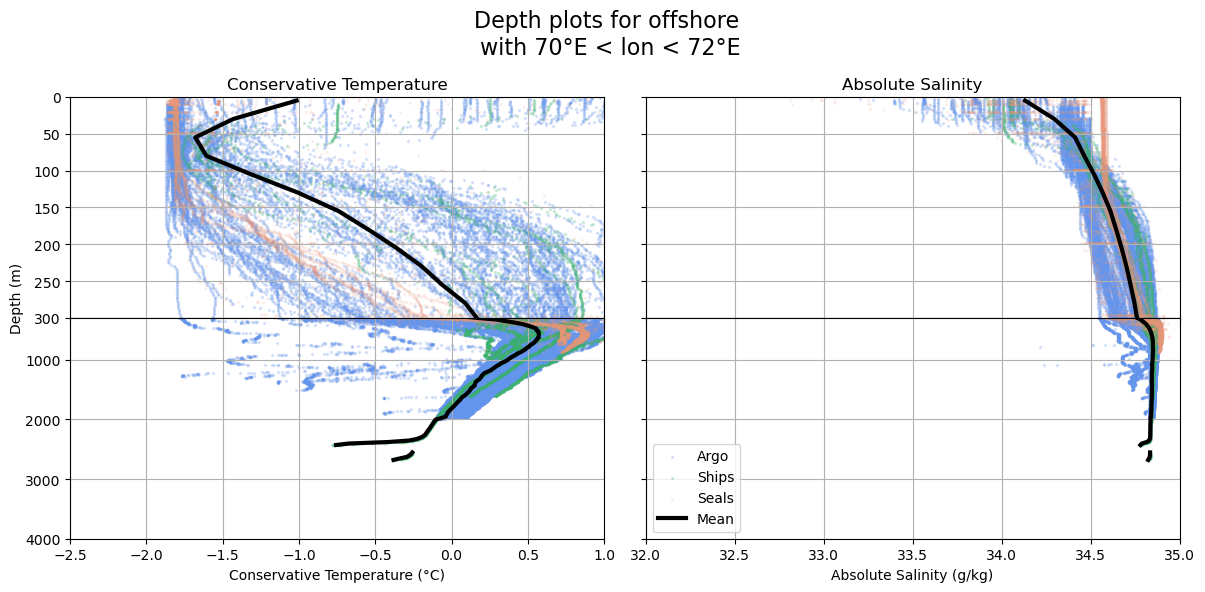

In [271]:
# Combine mean & raw data


# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))


# Plot Temperature vs. Depth on the top left subplot (ax1)
ax1.scatter(argo_cons_temperature_in_range, argo_depth_in_range, c='cornflowerblue', alpha=0.2, s=2, label='Argo')
ax1.scatter(ships_cons_temperature_in_range, ships_depth_in_range, c='mediumseagreen', alpha=0.2, s=2, label='Ships')
ax1.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='darksalmon', alpha=0.1, s=2, label='Seals')
ax1.plot(mean_temperature, depth_bins+5, label='Mean Temperature', color = 'black', linewidth = 3)
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 300)
ax1.set_xlim(-2.5, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom left subplot (ax3)
ax3.scatter(argo_cons_temperature_in_range, argo_depth_in_range, c='cornflowerblue', alpha=0.2, s=2, label='Argo')
ax3.scatter(ships_cons_temperature_in_range, ships_depth_in_range, c='mediumseagreen', alpha=0.2, s=2, label='Ships')
ax3.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='darksalmon', alpha=0.1, s=2, label='Seals')
ax3.plot(mean_temperature, depth_bins+5, label='Mean Temperature', color = 'black', linewidth = 3)
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(300, 4000)
ax3.set_xlim(-2.5, 1)
ax3.invert_yaxis()  # Flip the y-axis


# Plot Salinity vs. Depth on the top right subplot (ax2)
ax2.scatter(argo_abs_salinity_in_range, argo_depth_in_range, c='cornflowerblue', alpha=0.2, s=2, label='Argo')
ax2.scatter(ships_abs_salinity_in_range, ships_depth_in_range, c='mediumseagreen', alpha=0.2, s=2, label='Ships')
ax2.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='darksalmon', alpha=0.1, s=2, label='Seals')
ax2.plot(mean_salinity, depth_bins+5, label='Mean', color = 'black', linewidth = 3)
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 300)
ax2.set_xlim(32, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom right subplot (ax4)
ax4.scatter(argo_abs_salinity_in_range, argo_depth_in_range, c='cornflowerblue', alpha=0.2, s=2, label='Argo')
ax4.scatter(ships_abs_salinity_in_range, ships_depth_in_range, c='mediumseagreen', alpha=0.2, s=2, label='Ships')
ax4.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='darksalmon', alpha=0.1, s=2, label='Seals')
ax4.plot(mean_salinity, depth_bins+5, label='Mean', color = 'black', linewidth = 3)
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(300, 4000)
ax4.set_xlim(32, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')



# Add a large title that spans both subplots
fig.suptitle(f'Depth plots for offshore \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

#Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


In [241]:
# west
average_abs_salinity_offshore_west = mean_salinity
average_cons_temperature_offshore_west = mean_temperature
average_depth_offshore_west = depth_bins+5

In [263]:
# central
average_abs_salinity_offshore_central = mean_salinity
average_cons_temperature_offshore_central = mean_temperature
average_depth_offshore_central = depth_bins+5

In [272]:
# east
average_abs_salinity_offshore_east = mean_salinity
average_cons_temperature_offshore_east = mean_temperature
average_depth_offshore_east = depth_bins+5

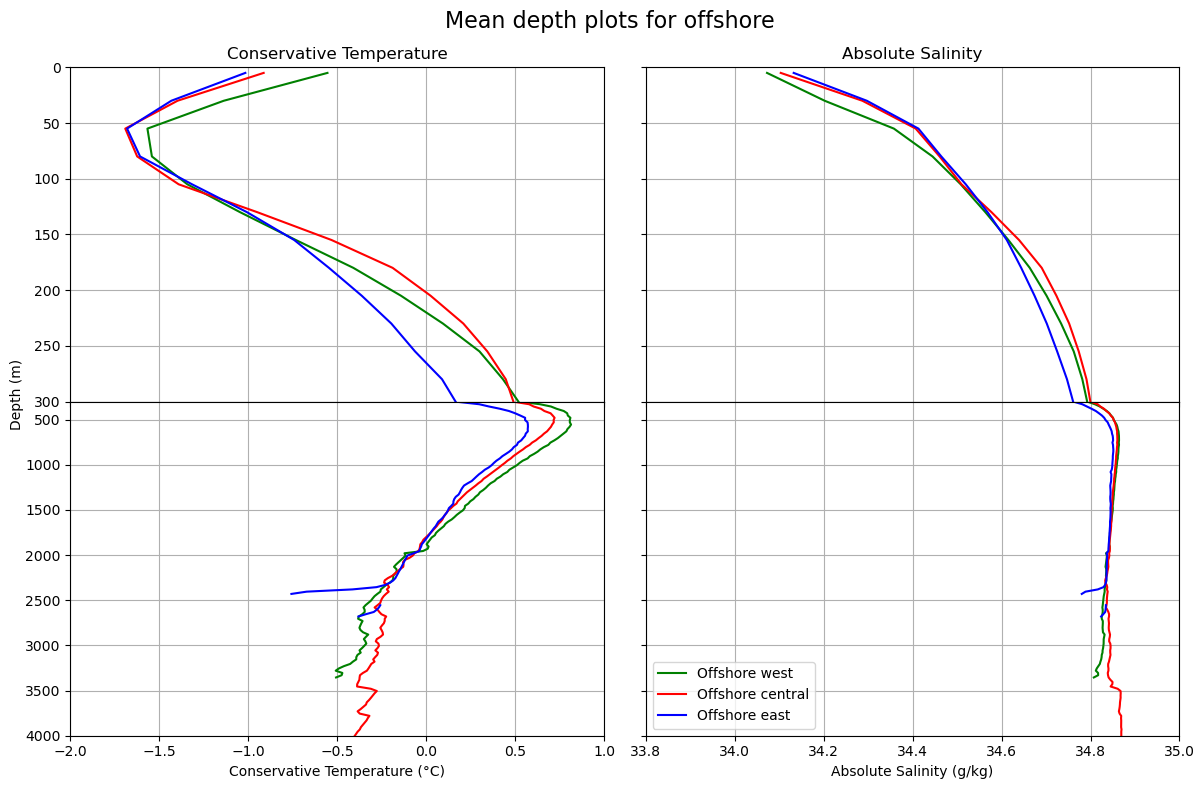

In [273]:
# Combine all means

# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Plot Temperature vs. Depth on the top left subplot (ax1)
ax1.plot(average_cons_temperature_offshore_west, average_depth_offshore_west, color='green', label='Offshore west')
ax1.plot(average_cons_temperature_offshore_central, average_depth_offshore_central, color='red', label='Offshore central')
ax1.plot(average_cons_temperature_offshore_east, average_depth_offshore_east, color='blue', label='Offshore east')
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 300)
ax1.set_xlim(-2, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom left subplot (ax3)
ax3.plot(average_cons_temperature_offshore_west, average_depth_offshore_west, color='green', label='Offshore west')
ax3.plot(average_cons_temperature_offshore_central, average_depth_offshore_central, color='red', label='Offshore central')
ax3.plot(average_cons_temperature_offshore_east, average_depth_offshore_east, color='blue', label='Offshore east')
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(300, 4000)
ax3.set_xlim(-2, 1)
ax3.invert_yaxis()  # Flip the y-axis

# Plot Salinity vs. Depth on the top right subplot (ax2)
ax2.plot(average_abs_salinity_offshore_west, average_depth_offshore_west, color='green', label='Offshore west')
ax2.plot(average_abs_salinity_offshore_central, average_depth_offshore_central, color='red', label='Offshore central')
ax2.plot(average_abs_salinity_offshore_east, average_depth_offshore_east, color='blue', label='Offshore east')
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 300)
ax2.set_xlim(33.8, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom right subplot (ax4)
ax4.plot(average_abs_salinity_offshore_west, average_depth_offshore_west, color='green', label='Offshore west')
ax4.plot(average_abs_salinity_offshore_central, average_depth_offshore_central, color='red', label='Offshore central')
ax4.plot(average_abs_salinity_offshore_east, average_depth_offshore_east, color='blue', label='Offshore east')
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(300, 4000)
ax4.set_xlim(33.8, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')

# Add a large title that spans both subplots
fig.suptitle(f'Mean depth plots for offshore', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


In [41]:
# export the mean lines 

# Create a dictionary to store the values
data = {
    "average_abs_salinity_offshore_west": average_abs_salinity_offshore_west,
    "average_cons_temperature_offshore_west": average_cons_temperature_offshore_west,
    "average_depth_offshore_west": average_depth_offshore_west,
    "average_abs_salinity_offshore_central": average_abs_salinity_offshore_central,
    "average_cons_temperature_offshore_central": average_cons_temperature_offshore_central,
    "average_depth_offshore_central": average_depth_offshore_central,
    "average_abs_salinity_offshore_east": average_abs_salinity_offshore_east,
    "average_cons_temperature_offshore_east": average_cons_temperature_offshore_east,
    "average_depth_offshore_east": average_depth_offshore_east
}

# Save the data to a file using pickle
with open('mean_depth_profile_data_offshore.pkl', 'wb') as file:
    pickle.dump(data, file)

In [3]:
# Load the mean depth profile data from the file
with open('mean_depth_profile_data.pkl', 'rb') as file:
    data = pickle.load(file)

# Access the values
average_abs_salinity_shelf_west = data["average_abs_salinity_shelf_west"]
average_cons_temperature_shelf_west = data["average_cons_temperature_shelf_west"]
average_depth_shelf_west = data["average_depth_shelf_west"]
average_abs_salinity_shelf_central = data["average_abs_salinity_shelf_central"]
average_cons_temperature_shelf_central = data["average_cons_temperature_shelf_central"]
average_depth_shelf_central = data["average_depth_shelf_central"]
average_abs_salinity_shelf_east = data["average_abs_salinity_shelf_east"]
average_cons_temperature_shelf_east = data["average_cons_temperature_shelf_east"]
average_depth_shelf_east = data["average_depth_shelf_east"]


average_abs_salinity_slope_west = data["average_abs_salinity_slope_west"]
average_cons_temperature_slope_west = data["average_cons_temperature_slope_west"]
average_depth_slope_west = data["average_depth_slope_west"]
average_abs_salinity_slope_central = data["average_abs_salinity_slope_central"]
average_cons_temperature_slope_central = data["average_cons_temperature_slope_central"]
average_depth_slope_central = data["average_depth_slope_central"]
average_abs_salinity_slope_east = data["average_abs_salinity_slope_east"]
average_cons_temperature_slope_east = data["average_cons_temperature_slope_east"]
average_depth_slope_east = data["average_depth_slope_east"]



average_abs_salinity_offshore_west = data["average_abs_salinity_offshore_west"]
average_cons_temperature_offshore_west = data["average_cons_temperature_offshore_west"]
average_depth_offshore_west = data["average_depth_offshore_west"]
average_abs_salinity_offshore_central = data["average_abs_salinity_offshore_central"]
average_cons_temperature_offshore_central = data["average_cons_temperature_offshore_central"]
average_depth_offshore_central = data["average_depth_offshore_central"]
average_abs_salinity_offshore_east = data["average_abs_salinity_offshore_east"]
average_cons_temperature_offshore_east = data["average_cons_temperature_offshore_east"]
average_depth_offshore_east = data["average_depth_offshore_east"]

KeyError: 'average_abs_salinity_shelf_west'

In [4]:
# Load the mean depth profile data from the file
with open('mean_depth_profile_data.pkl', 'rb') as file:
    data = pickle.load(file)

print(data)

{'average_abs_salinity_slope_west': [33.81116280449045, 33.88681368748488, 34.00415443466011, 34.03084666906349, 34.11087366853378, 34.138869042243336, 34.212747813334275, 34.28140840495269, 34.34357342994118, 34.43061148706175, 34.459092078163955, 34.49488162794953, 34.52338175687043, 34.5412407420657, 34.560103712446555, 34.573257298971676, 34.58678832456223, 34.597137331514254, 34.61191953631838, 34.61791354644608, 34.6317170808999, 34.639747907572456, 34.65003691122857, 34.65681742114528, 34.66388469001731, 34.67281436301104, 34.68080672512466, 34.69068368423442, 34.70075791512708, 34.707420417410184, 34.71621356373939, 34.72198322360819, 34.728290249948934, 34.73704338592698, 34.73501237521271, 34.74497246319032, 34.750645240339566, 34.750785584359356, 34.75780629126069, 34.757480675020425, 34.76301534656884, 34.765834525900324, 34.76874719244703, 34.775541159370256, 34.775477783098864, 34.77567990013496, 34.779409537625156, 34.78401416983237, 34.78504510666106, 34.78376442742725,

In [1]:
# Combine all means

# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))

# Plot Temperature vs. Depth on the top left subplot (ax1)
ax1.plot(average_cons_temperature_shelf_west, average_depth_shelf_west, color='green', label='Shelf west')
ax1.plot(average_cons_temperature_shelf_central, average_depth_shelf_central, color='red', label='Shelf central')
ax1.plot(average_cons_temperature_shelf_east, average_depth_shelf_east, color='blue', label='Shelf east')
ax1.plot(average_cons_temperature_slope_west, average_depth_slope_west, color='limegreen', label='Slope west')
ax1.plot(average_cons_temperature_slope_central, average_depth_slope_central, color='indianred', label='Slope central')
ax1.plot(average_cons_temperature_slope_east, average_depth_slope_east, color='cornflowerblue', label='Slope east')
ax1.plot(average_cons_temperature_offshore_west, average_depth_offshore_west, color='yellowgreen', label='Offshore west')
ax1.plot(average_cons_temperature_offshore_central, average_depth_offshore_central, color='pink', label='Offshore central')
ax1.plot(average_cons_temperature_offshore_east, average_depth_offshore_east, color='lavender', label='Offshore east')
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 500)
ax1.set_xlim(-2, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom left subplot (ax3)
ax3.plot(average_cons_temperature_shelf_west, average_depth_shelf_west, color='green', label='Shelf west')
ax3.plot(average_cons_temperature_shelf_central, average_depth_shelf_central, color='red', label='Shelf central')
ax3.plot(average_cons_temperature_shelf_east, average_depth_shelf_east, color='blue', label='Shelf east')
ax3.plot(average_cons_temperature_slope_west, average_depth_slope_west, color='limegreen', label='Slope west')
ax3.plot(average_cons_temperature_slope_central, average_depth_slope_central, color='indianred', label='Slope central')
ax3.plot(average_cons_temperature_slope_east, average_depth_slope_east, color='cornflowerblue', label='Slope east')
ax3.plot(average_cons_temperature_offshore_west, average_depth_offshore_west, color='yellowgreen', label='Offshore west')
ax3.plot(average_cons_temperature_offshore_central, average_depth_offshore_central, color='pink', label='Offshore central')
ax3.plot(average_cons_temperature_offshore_east, average_depth_offshore_east, color='lavender', label='Offshore east')
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(500, 4000)
ax3.set_xlim(-2, 1)
ax3.invert_yaxis()  # Flip the y-axis

# Plot Salinity vs. Depth on the top right subplot (ax2)
ax2.plot(average_abs_salinity_shelf_west, average_depth_shelf_west, color='green', label='Shelf west')
ax2.plot(average_abs_salinity_shelf_central, average_depth_shelf_central, color='red', label='Shelf central')
ax2.plot(average_abs_salinity_shelf_east, average_depth_shelf_east, color='blue', label='Shelf east')
ax2.plot(average_abs_salinity_slope_west, average_depth_slope_west, color='limegreen', label='Slope west')
ax2.plot(average_abs_salinity_slope_central, average_depth_slope_central, color='indianred', label='Slope central')
ax2.plot(average_abs_salinity_slope_east, average_depth_slope_east, color='cornflowerblue', label='Slope east')
ax2.plot(average_abs_salinity_offshore_west, average_depth_offshore_west, color='yellowgreen', label='Offshore west')
ax2.plot(average_abs_salinity_offshore_central, average_depth_offshore_central, color='pink', label='Offshore central')
ax2.plot(average_abs_salinity_offshore_east, average_depth_offshore_east, color='lavender', label='Offshore east')
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 500)
ax2.set_xlim(33.5, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom right subplot (ax4)
ax4.plot(average_abs_salinity_shelf_west, average_depth_shelf_west, color='green', label='Shelf west')
ax4.plot(average_abs_salinity_shelf_central, average_depth_shelf_central, color='red', label='Shelf central')
ax4.plot(average_abs_salinity_shelf_east, average_depth_shelf_east, color='blue', label='Shelf east')
ax4.plot(average_abs_salinity_slope_west, average_depth_slope_west, color='limegreen', label='Slope west')
ax4.plot(average_abs_salinity_slope_central, average_depth_slope_central, color='indianred', label='Slope central')
ax4.plot(average_abs_salinity_slope_east, average_depth_slope_east, color='cornflowerblue', label='Slope east')
ax4.plot(average_abs_salinity_offshore_west, average_depth_offshore_west, color='yellowgreen', label='Offshore west')
ax4.plot(average_abs_salinity_offshore_central, average_depth_offshore_central, color='pink', label='Offshore central')
ax4.plot(average_abs_salinity_offshore_east, average_depth_offshore_east, color='lavender', label='Offshore east')
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(500, 4000)
ax4.set_xlim(33.5, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')

# Add a large title that spans both subplots
fig.suptitle(f'Mean depth plots for all regions', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


NameError: name 'plt' is not defined

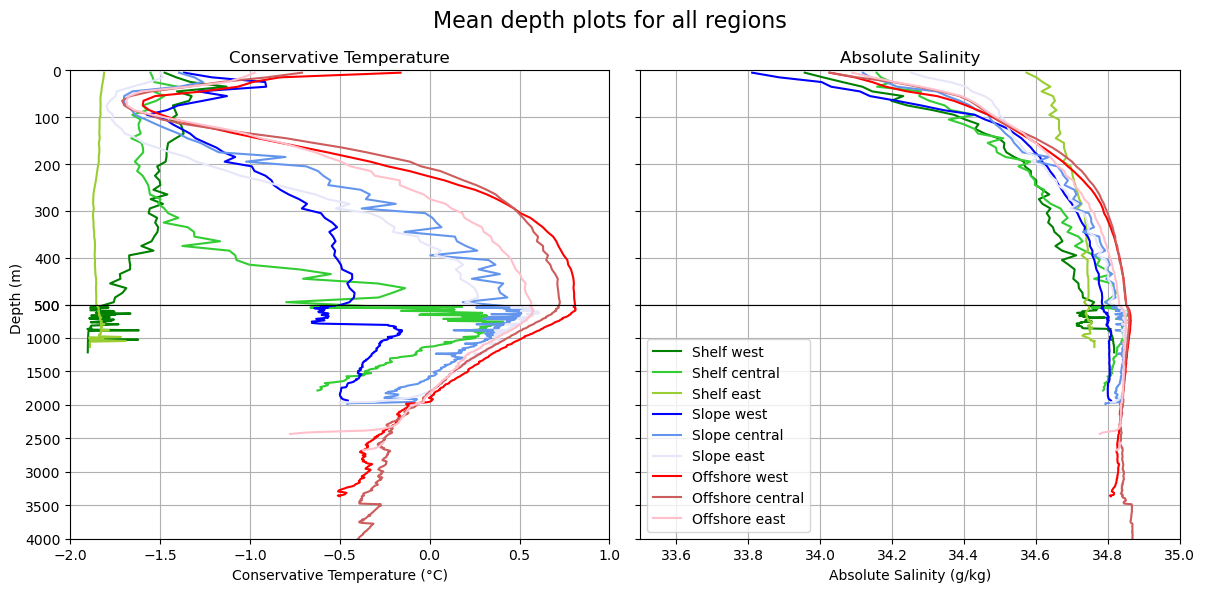

In [258]:
# Combine all means

# Create the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))

# Plot Temperature vs. Depth on the top left subplot (ax1)
ax1.plot(average_cons_temperature_shelf_west, average_depth_shelf_west, color='green', label='Shelf west')
ax1.plot(average_cons_temperature_shelf_central, average_depth_shelf_central, color='limegreen', label='Shelf central')
ax1.plot(average_cons_temperature_shelf_east, average_depth_shelf_east, color='yellowgreen', label='Shelf east')
ax1.plot(average_cons_temperature_slope_west, average_depth_slope_west, color='blue', label='Slope west')
ax1.plot(average_cons_temperature_slope_central, average_depth_slope_central, color='cornflowerblue', label='Slope central')
ax1.plot(average_cons_temperature_slope_east, average_depth_slope_east, color='lavender', label='Slope east')
ax1.plot(average_cons_temperature_offshore_west, average_depth_offshore_west, color='red', label='Offshore west')
ax1.plot(average_cons_temperature_offshore_central, average_depth_offshore_central, color='indianred', label='Offshore central')
ax1.plot(average_cons_temperature_offshore_east, average_depth_offshore_east, color='pink', label='Offshore east')
ax1.set_title('Conservative Temperature')
ax1.grid(True)
ax1.set_ylim(0, 500)
ax1.set_xlim(-2, 1)
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels([])  # Remove x-axis labels

# Plot Temperature vs. Depth on the bottom left subplot (ax3)
ax3.plot(average_cons_temperature_shelf_west, average_depth_shelf_west, color='green', label='Shelf west')
ax3.plot(average_cons_temperature_shelf_central, average_depth_shelf_central, color='limegreen', label='Shelf central')
ax3.plot(average_cons_temperature_shelf_east, average_depth_shelf_east, color='yellowgreen', label='Shelf east')
ax3.plot(average_cons_temperature_slope_west, average_depth_slope_west, color='blue', label='Slope west')
ax3.plot(average_cons_temperature_slope_central, average_depth_slope_central, color='cornflowerblue', label='Slope central')
ax3.plot(average_cons_temperature_slope_east, average_depth_slope_east, color='lavender', label='Slope east')
ax3.plot(average_cons_temperature_offshore_west, average_depth_offshore_west, color='red', label='Offshore west')
ax3.plot(average_cons_temperature_offshore_central, average_depth_offshore_central, color='indianred', label='Offshore central')
ax3.plot(average_cons_temperature_offshore_east, average_depth_offshore_east, color='pink', label='Offshore east')
ax3.set_xlabel('Conservative Temperature (°C)')
ax3.grid(True)
ax3.set_ylim(500, 4000)
ax3.set_xlim(-2, 1)
ax3.invert_yaxis()  # Flip the y-axis

# Plot Salinity vs. Depth on the top right subplot (ax2)
ax2.plot(average_abs_salinity_shelf_west, average_depth_shelf_west, color='green', label='Shelf west')
ax2.plot(average_abs_salinity_shelf_central, average_depth_shelf_central, color='limegreen', label='Shelf central')
ax2.plot(average_abs_salinity_shelf_east, average_depth_shelf_east, color='yellowgreen', label='Shelf east')
ax2.plot(average_abs_salinity_slope_west, average_depth_slope_west, color='blue', label='Slope west')
ax2.plot(average_abs_salinity_slope_central, average_depth_slope_central, color='cornflowerblue', label='Slope central')
ax2.plot(average_abs_salinity_slope_east, average_depth_slope_east, color='lavender', label='Slope east')
ax2.plot(average_abs_salinity_offshore_west, average_depth_offshore_west, color='red', label='Offshore west')
ax2.plot(average_abs_salinity_offshore_central, average_depth_offshore_central, color='indianred', label='Offshore central')
ax2.plot(average_abs_salinity_offshore_east, average_depth_offshore_east, color='pink', label='Offshore east')
ax2.set_title('Absolute Salinity')
ax2.grid(True)
ax2.set_ylim(0, 500)
ax2.set_xlim(33.5, 35)
ax2.invert_yaxis()  # Flip the y-axis
ax2.set_yticklabels([])  # Remove y-axis ticks
ax2.set_xticklabels([])  # Remove x-axis labels

# Plot Salinity vs. Depth on the bottom right subplot (ax4)
ax4.plot(average_abs_salinity_shelf_west, average_depth_shelf_west, color='green', label='Shelf west')
ax4.plot(average_abs_salinity_shelf_central, average_depth_shelf_central, color='limegreen', label='Shelf central')
ax4.plot(average_abs_salinity_shelf_east, average_depth_shelf_east, color='yellowgreen', label='Shelf east')
ax4.plot(average_abs_salinity_slope_west, average_depth_slope_west, color='blue', label='Slope west')
ax4.plot(average_abs_salinity_slope_central, average_depth_slope_central, color='cornflowerblue', label='Slope central')
ax4.plot(average_abs_salinity_slope_east, average_depth_slope_east, color='lavender', label='Slope east')
ax4.plot(average_abs_salinity_offshore_west, average_depth_offshore_west, color='red', label='Offshore west')
ax4.plot(average_abs_salinity_offshore_central, average_depth_offshore_central, color='indianred', label='Offshore central')
ax4.plot(average_abs_salinity_offshore_east, average_depth_offshore_east, color='pink', label='Offshore east')
ax4.set_xlabel('Absolute Salinity (g/kg)')
ax4.grid(True)
ax4.set_ylim(500, 4000)
ax4.set_xlim(33.5, 35)
ax4.invert_yaxis()  # Flip the y-axis
ax4.set_yticklabels([])  # Remove y-axis labels
ax4.legend(loc='lower left')

# Add a large title that spans both subplots
fig.suptitle(f'Mean depth plots for all regions', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Add y-axis title between the subplots
fig.text(0, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

plt.show()  # Display the subplot


In [ ]:
#filter data by season

# Define the time range you want to plot

# #Autumn
# time_min = 60
# time_max = 151

# #Winter
# time_min = 152
# time_max = 212

# #Spring
# time_min = 213
# time_max = 334

#summer 
time_min = 335
time_max = 59



# Filter the data based on latitude
#use this line for autumn, spring & winter
#indices_in_range = np.where((time >= time_min) & (time <= time_max))[0]
#use this line for summer
indices_in_range = np.where(((time >= 331) & (time <= 365)) | ((time >= 0) & (time <= 60)))[0]
season_cons_temperature_in_range = cons_temperature[indices_in_range]
season_abs_salinity_in_range = abs_salinity[indices_in_range]
season_depth_in_range = depth[indices_in_range]
season_filtered_latitude_in_range = latitude[indices_in_range]
season_filtered_longitude_in_range = longitude[indices_in_range]
season_filtered_neutral_density_in_range = neutral_density[indices_in_range]


#use this line for autumn, spring & winter
#indices_out_range = np.where((time < time_min) | (time > time_max))[0]
#use this line for summer
indices_out_range = np.where((time < 0) | ((time > 60) & (time < 331)) | (time > 365))[0]
season_cons_temperature_out_range = cons_temperature[indices_out_range]
season_abs_salinity_out_range = abs_salinity[indices_out_range]
season_depth_out_range = depth[indices_out_range]
season_filtered_latitude_out_range = latitude[indices_out_range]
season_filtered_longitude_out_range = longitude[indices_out_range]
season_filtered_neutral_density_out_range = neutral_density[indices_out_range]

len(season_filtered_longitude_in_range)